In [12]:
# requires
# pip install git+https://github.com/Phylliida/MambaLens.git

# do PCA (and projective PCA?)
# todo: for each name look at its PCA (make a colored graph for different components?)
# train projection from PCA space to classifier space?

from mamba_lens import HookedMamba # this will take a little while to import
import torch
model_path = "state-spaces/mamba-370m"
model = HookedMamba.from_pretrained(model_path, device='cuda')
torch.set_grad_enabled(False)

# idea: cluster edges by which inputs and output edges they have1

/opt/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


In [13]:
# remember to do
# pip install -e .
# in the root directory of this repo
# also
# to install graphviz:
# sudo apt-get update
# sudo apt-get install graphviz xdg-utils

from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
from acdc.data.utils import generate_dataset

num_patching_pairs = 200
seed = 27
valid_seed = 28
constrain_to_answers = True
# this makes our data size 800, first 400 is each (a,b) pair, and then second 400 is each pair swapped to be (b,a)
has_symmetric_patching = True

from acdc.data.ioi import BABA_TEMPLATES
templates = ABC_TEMPLATES
patching_formats = list(get_all_single_name_abc_patching_formats())


data = generate_dataset(model=model,
                  data_generator=ioi_data_generator,
                  num_patching_pairs=num_patching_pairs,
                  seed=seed,
                  valid_seed=valid_seed,
                  constrain_to_answers=constrain_to_answers,
                  has_symmetric_patching=has_symmetric_patching, 
                  varying_data_lengths=True,
                  templates=templates,
                  patching_formats=patching_formats)


import acdc.data.ioi
from collections import defaultdict
name_positions_map = defaultdict(lambda: [])
for template in templates:
    name = acdc.data.ioi.good_names[0]
    template_filled_in = template.replace("[NAME]", name)
    template_filled_in = template_filled_in.replace("[PLACE]", acdc.data.ioi.good_nouns['[PLACE]'][0])
    template_filled_in = template_filled_in.replace("[OBJECT]", acdc.data.ioi.good_nouns['[OBJECT]'][0])
    # get the token positions of the [NAME] in the prompt
    name_positions = tuple([(i) for (i,s) in enumerate(model.to_str_tokens(torch.tensor(model.tokenizer.encode(template_filled_in)))) if s == f' {name}'])
    name_positions_map[name_positions].append(template)
sorted_by_frequency = sorted(list(name_positions_map.items()), key=lambda x: -len(x[1]))
most_frequent_name_positions, templates = sorted_by_frequency[0]
print("using templates")
for template in templates:
    print(template)
print(f"with name positions {most_frequent_name_positions}")

data = generate_dataset(model=model,
              data_generator=ioi_data_generator,
              num_patching_pairs=num_patching_pairs,
              seed=seed,
              valid_seed=valid_seed,
              constrain_to_answers=constrain_to_answers,
              has_symmetric_patching=has_symmetric_patching, 
              varying_data_lengths=True,
              templates=templates,
              patching_formats=patching_formats)



using templates
Then, [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
Afterwards [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
Friends [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
with name positions (2, 4, 6, 12, 14)


In [14]:
# from tqdm import tqdm
from functools import partial
from jaxtyping import Float
from transformer_lens.hook_points import HookPoint
from mamba_lens.input_dependent_hooks import clean_hooks
from tqdm import tqdm

model_kwargs = {
    'fast_ssm': False,
    'fast_conv': True
}
BATCH_SIZE = 30

# removes all hooks including "leftover" ones that might stick around due to interrupting the model at certain times
clean_hooks(model)

def normalized_logit_diff_metric(patched_logits, unpatched_logits, corrupted_logits, patched_correct, corrupted_correct, also_return_acc=False):
    B,V = patched_logits.size()

    #print(data.unpatched.logits.size(), data.patched.logits.size(), data.corrupted.logits.size())
    A_logits_unpatched = unpatched_logits[torch.arange(B), patched_correct]
    A_logits_patched = patched_logits[torch.arange(B), patched_correct]
    A_logits_corrupted = corrupted_logits[torch.arange(B), patched_correct]

    B_logits_unpatched = unpatched_logits[torch.arange(B), corrupted_correct]
    B_logits_patched = patched_logits[torch.arange(B), corrupted_correct]
    B_logits_corrupted = corrupted_logits[torch.arange(B), corrupted_correct]

    # A and B are two potential outputs
    # if A patched > B patched, we are correct
    # else we are incorrect

    # thus we could just return A_logits_patched - B_logits_patched

    # however it is useful to "normalize" these values

    # in the worst case, our patching causes us to act like corrupted, and our diff will be
    # A_logits_corrupted - B_logits_corrupted
    # this will result in a small, negative value
    
    # in the best case, our patching will do nothing (cause us to act like unpatched), and our diff will be
    # A_logits_unpatched - B_logits_unpatched
    # this will result in a large, positive value

    # thus we can treat those as the "min" and "max" and normalize accordingly
    
    min_diff = A_logits_corrupted - B_logits_corrupted
    max_diff = A_logits_unpatched - B_logits_unpatched

    # the abs ensures that if it's wrong we don't try and make it more wrong
    possible_range = torch.abs(max_diff-min_diff)
    possible_range[possible_range == 0] = 1.0 # prevent divide by zero
    
    diff = A_logits_patched - B_logits_patched
    
    normalized_diff = (diff-min_diff)/possible_range

    # as described, 1.0 corresponds to acting like unpatched,
    # and 0.0 corresponds to acting like corrupted
    res = torch.mean(normalized_diff)
    
    if also_return_acc:
        num_correct = A_logits_patched > B_logits_patched
        acc = torch.sum(num_correct)/B
        return res, acc
    else:
        return res


# there's a subtle bug if you aren't careful:
# consider what happens when we do edge attribution patching and patch every edge
# what we want to happen is that it's identical to corrupted
# however this is not what happens!
# Start with layer 0:
# layer 0 will be patched
#    we subtract uncorrupted embed and add corrupted embed
#    in other words, the embed input to layer 0 will be from the corrupted run
# this results in layer 0 having an output of corrupted, as desired
# now consider layer 1
#    subtract uncorrupted embed and add corrupted embed
#      this is fine and results in embed input to layer 1 of corrupted
#    subtract uncorrupted layer 0 and add corrupted layer 0
#      layer 0 is already corrupted, so this has the effect of the output of layer 0 being
#          2*corrupted layer 0 - uncorrupted layer 0
#          this is not the same as corrupted!

# two ways to fix this:
# 1. fetch stored layer_input from uncorrupted run, and use that instead of the layer_input given in fwd_diff
#   this works, but then the gradients won't propogate properly (maybe? todo: test)
# 2. mark which edges are patched and don't "double patch" them
#   if we are patching all edges, this means that we simply apply only the embed diff to all layers,
#   as that'll result in all layers being patched
# 3. just subtract the outputs in the same forward pass, instead of a cached "unpatched" run
#  we do 3

global alpha
alpha = 1

def cache_output_hook( # hook_layer_output
    layer_output : Float[torch.Tensor, "B L D"],
    hook : HookPoint,
    layer : int,
    cached_outputs : Float[torch.Tensor, "NLayers+1 B L D"]):
    global alpha
    #print(f"running cache with alpha {alpha} and layer {layer}") 
    # the first one is embed, so layer+1
    # this patches all edges going into this one
    # actually, see the above note,
    # only apply the embed diff, do this to all layers
    cached_outputs[layer+1] = layer_output
    return layer_output

def fwd_diff_hook( # hook_layer_input
    layer_input : Float[torch.Tensor, "B L D"],
    hook : HookPoint,
    layer : int,
    cached_outputs : Float[torch.Tensor, "NLayers+1 B L D"],
    corrupted_outputs : Float[torch.Tensor, "NLayers+1 B L D"]):
    global alpha
    #print(f"running fwd with alpha {alpha} and layer {layer}") 
    # the first one is embed, so layer+1
    # this patches all edges going into this one
    # actually, see the above note,
    # only apply the embed diff, do this to all layers
    # actually, once we make diffs be (-current forward pass layer_output + corrupted) then it's fine to do this
    return layer_input + (-cached_outputs[:layer+1]+corrupted_outputs[:layer+1]).sum(dim=0)*alpha
    #patched = layer_input + diffs[:layer+1].sum(dim=0)
    #unpatched = layer_input
    # alpha * layer_input + alpha*diffs + layer_input - alpha*layer_input
    # they cancel out and it's just
    # layer_input + alpha*diffs
    #return alpha * patched + (1-alpha)*unpatched

def bwd_diff_hook( # hook_layer_input
    grad : Float[torch.Tensor, "B L D"],
    hook: HookPoint,
    layer : int,
    batch_start: int,
    batch_end: int,
    cached_outputs : Float[torch.Tensor, "NLayers+1 B L D"],
    corrupted_outputs : Float[torch.Tensor, "NLayers+1 B L D"]):
    #print(f"running bwd with alpha {alpha} and layer {layer}") 
    
    # [N_upstream, B, L, D]
    upstream_diffs = (-cached_outputs[:layer+1]+corrupted_outputs[:layer+1])
    # grad is [B,L,D]

    # to do a taylor approximation of metric with respect to diff_0, we
    # multiply diffs and grad, then
    # sum over the L and D dimensions (this is doing a dot product of vectors of size L*D)
    # now we have attr of size [N_upstream, B, L]
    attr = (grad*upstream_diffs).sum(dim=-1)
    # [B, N_upstream, L]           [N_upstream, B, L]
    attr         =   torch.transpose(attr, 0, 1)
    # [B, N_upstream, L]
    attr = attr.clone().detach()
    if POSITIONS:
        attributions[batch_start:batch_end,:layer+1,layer+1] += attr
    else:
        #[B, N_upstream]
        attr = attr.sum(dim=-1)
        attributions[batch_start:batch_end,:layer+1,layer+1] += attr

B,L = data.data.size()
# our data is pairs of unpatched, corrupted
n_patching_pairs = B//2

# attributions[b,i+1,j+1] is the (i->j) edge attribution for patching pair b
# attributions[b,0,j] is the (embed->j) edge attribution for patching pair b
# attributions[b,i,-1] is the (i->output) edge attribution for patching pair b
POSITIONS = False
if POSITIONS:
    attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers+2, model.cfg.n_layers+2, L], device=model.cfg.device)
else:
    attributions = torch.zeros([n_patching_pairs, model.cfg.n_layers+2, model.cfg.n_layers+2], device=model.cfg.device)

input_names = [f'blocks.{i}.hook_layer_input' for i in range(model.cfg.n_layers)]
output_names = [f'blocks.{i}.hook_out_proj' for i in range(model.cfg.n_layers)]


for batch_start in range(0, n_patching_pairs, BATCH_SIZE):
    batch_end = min(batch_start + BATCH_SIZE, n_patching_pairs)
    print(batch_start, batch_end)
    # we don't need grad for these forward passes
    torch.set_grad_enabled(False)
    embed_name = 'hook_embed'

    clean_hooks(model)
    # forward passes to get unpatched and corrupted
    unpatched_logits, unpatched_layer_outputs = model.run_with_cache(data.data[::2][batch_start:batch_end], names_filter=[embed_name] + output_names, **model_kwargs)
    corrupted_logits, corrupted_layer_outputs = model.run_with_cache(data.data[1::2][batch_start:batch_end], names_filter=[embed_name] + output_names, **model_kwargs)
    
    batch_size,L,D = unpatched_layer_outputs[output_names[0]].size()
    
    # get only the last token position (logit for next predicted token)
    # this is needed to support data of varying lengths
    unpatched_logits = unpatched_logits[torch.arange(batch_size), data.last_token_position[::2][batch_start:batch_end]]
    corrupted_logits = corrupted_logits[torch.arange(batch_size), data.last_token_position[1::2][batch_start:batch_end]]
    
    clean_hooks(model)

    # backward pass to compute grad of diff
    torch.set_grad_enabled(True)
    
    
    corrupted_outputs = torch.zeros([model.cfg.n_layers+1,batch_size,L,D], device=model.cfg.device)
    corrupted_outputs.requires_grad = False
    # first one is for embed
    corrupted_outputs[0] = corrupted_layer_outputs[embed_name]
    for layer in range(model.cfg.n_layers):
        output_name = output_names[layer]
        corrupted_outputs[layer+1] = corrupted_layer_outputs[output_name]

    

    
    for param in model.parameters():
        param.requires_grad = True
        param.grad = None # reset grads
    
    last_layer = model.cfg.n_layers-1
    # forward pass to do partial patches
    cached_outputs = torch.zeros([model.cfg.n_layers+1,batch_size,L,D], device=model.cfg.device)
    cached_outputs.requires_grad = False
    cache_output_hooks = [(embed_name,
                           partial(cache_output_hook,
                                   layer=-1,
                                   cached_outputs=cached_outputs))]
    
    cache_output_hooks += [(output_names[layer],
                            partial(cache_output_hook,
                                    layer=layer,
                                    cached_outputs=cached_outputs)) for layer in range(model.cfg.n_layers)]
    
    fwd_hooks = cache_output_hooks
    fwd_hooks += [(input_names[layer],
                  partial(
                      fwd_diff_hook,
                      layer=layer,
                      cached_outputs=cached_outputs,
                      corrupted_outputs=corrupted_outputs,
                  )) for layer in range(model.cfg.n_layers)]
    bwd_hooks = [(input_names[layer],
                  partial(bwd_diff_hook,
                          layer=layer,
                          cached_outputs=cached_outputs,
                          corrupted_outputs=corrupted_outputs,
                          batch_start=batch_start,
                          batch_end=batch_end)) for layer in range(model.cfg.n_layers)]
    # extra hook for the very last layer
    fwd_hooks.append((f'blocks.{last_layer}.hook_resid_post',
                      partial(fwd_diff_hook,
                              layer=last_layer+1,
                              cached_outputs=cached_outputs,
                              corrupted_outputs=corrupted_outputs,
                             )))
    bwd_hooks.append((f'blocks.{last_layer}.hook_resid_post',
                      partial(bwd_diff_hook,
                              layer=last_layer+1,
                              cached_outputs=cached_outputs,
                              corrupted_outputs=corrupted_outputs,
                              batch_start=batch_start,
                              batch_end=batch_end,
                             )))

    for fwd in fwd_hooks:
        model.add_hook(*fwd, "fwd")

    for bwd in bwd_hooks:
        model.add_hook(*bwd, "bwd")
    
    # with integrated gradients
    # simply sums over doing "partial patches" like 0.2 patch and 0.8 unpatched 
    # ITERS = 1 is just edge attribution patching (without integraded gradients)
    ITERS = 5
    for i in range(ITERS):
        global alpha
        # alpha ranges from 0 to 1
        if ITERS > 1:
            alpha = i/float(ITERS-1)
        elif ITERS == 1: # no integrated gradients, set alpha to 1
            alpha = 1.0

        # it tries to propogate gradients to these, detach them
        cached_outputs[:] = 0
        cached_outputs.grad = None
        cached_outputs.detach_()
        corrupted_outputs.grad = None
        corrupted_outputs.detach_()
        model.zero_grad()
        for param in model.parameters():
            param.grad = None
        logits = model(data.data[::2][batch_start:batch_end], **model_kwargs)
        logits = logits[torch.arange(batch_size), data.last_token_position[::2][batch_start:batch_end]]
        metric = normalized_logit_diff_metric(
            patched_logits=logits,
            unpatched_logits=unpatched_logits,
            corrupted_logits=corrupted_logits,
            patched_correct=data.correct[::2][batch_start:batch_end][:,0],
            corrupted_correct=data.correct[1::2][batch_start:batch_end][:,0]
        )
        print(f"alpha {alpha} metric {metric}")
        # run backward pass, which adds to attributions
        metric.backward()

# todo: maybe the diffs should have alpha in the backward pass? No, that would mean alpha of 0 gives all zero attrs

# average over all the samples
attributions[:] = attributions[:]/ITERS


# don't need grad for rest of this
torch.set_grad_enabled(False)

clean_hooks(model)




0 30
alpha 0.0 metric 1.0
alpha 0.25 metric 0.39601418375968933
alpha 0.5 metric 0.08676499873399734
alpha 0.75 metric 0.010888022370636463
alpha 1.0 metric -5.74837999423039e-09
30 60
alpha 0.0 metric 1.0
alpha 0.25 metric 0.37620702385902405
alpha 0.5 metric 0.08132590353488922
alpha 0.75 metric 0.01024048775434494
alpha 1.0 metric 6.777784733458248e-08
60 90
alpha 0.0 metric 1.0
alpha 0.25 metric 0.39597615599632263
alpha 0.5 metric 0.08992055803537369
alpha 0.75 metric 0.011775696650147438
alpha 1.0 metric 1.2134648841310991e-08
90 120
alpha 0.0 metric 1.0
alpha 0.25 metric 0.3865799903869629
alpha 0.5 metric 0.08268946409225464
alpha 0.75 metric 0.010380798019468784
alpha 1.0 metric 8.326380473988593e-09
120 150
alpha 0.0 metric 1.0
alpha 0.25 metric 0.38332077860832214
alpha 0.5 metric 0.08523042500019073
alpha 0.75 metric 0.010738296434283257
alpha 1.0 metric -9.041420412359003e-08
150 180
alpha 0.0 metric 1.0
alpha 0.25 metric 0.37772563099861145
alpha 0.5 metric 0.081463411450

In [15]:
from functools import partial

eval_kwargs = {
    "fast_ssm": True,
    "fast_conv": True
}

if POSITIONS:
    positions = list(range(L))
else:
    positions = [None]

def test_graph(keeping_edges, valid=False):
    edges_patching = []
    keeping_edges_set = set(keeping_edges)
    
    for pos in positions:
        for i in range(model.cfg.n_layers):
            edge = ('embed', i, pos)
            if not edge in keeping_edges_set:
                edges_patching.append(edge)
            for j in range(i+1, model.cfg.n_layers):
                edge = (i, j, pos)
                if not edge in keeping_edges_set:
                    edges_patching.append(edge)
            edge = (i, 'output', pos)
            if not edge in keeping_edges_set:
                edges_patching.append(edge)
        edge = ('embed', 'output', pos)
        if not edge in keeping_edges_set:
            edges_patching.append(edge)
    
    storage = {}
    clean_hooks(model)

    metrics = []
    accs = []
    for batch_start in range(0, n_patching_pairs, BATCH_SIZE):
        batch_end = min(batch_start + BATCH_SIZE, n_patching_pairs)
        batch_size = batch_end-batch_start
        clean_hooks(model)
        if valid:
            unpatched_logits, unpatched_layer_outputs = model.run_with_cache(data.valid_data[::2][batch_start:batch_end], names_filter=['hook_embed'] + output_names, **eval_kwargs)
            corrupted_logits, corrupted_layer_outputs = model.run_with_cache(data.valid_data[1::2][batch_start:batch_end], names_filter=['hook_embed'] + output_names, **eval_kwargs)
            # get only the last token position (logit for next predicted token)
            unpatched_logits = unpatched_logits[torch.arange(batch_size), data.valid_last_token_position[::2][batch_start:batch_end]]
            corrupted_logits = corrupted_logits[torch.arange(batch_size), data.valid_last_token_position[1::2][batch_start:batch_end]]
        else:
            unpatched_logits, unpatched_layer_outputs = model.run_with_cache(data.data[::2][batch_start:batch_end], names_filter=['hook_embed'] + output_names, **eval_kwargs)
            corrupted_logits, corrupted_layer_outputs = model.run_with_cache(data.data[1::2][batch_start:batch_end], names_filter=['hook_embed'] + output_names, **eval_kwargs)
            # get only the last token position (logit for next predicted token)
            unpatched_logits = unpatched_logits[torch.arange(batch_size), data.last_token_position[::2][batch_start:batch_end]]
            corrupted_logits = corrupted_logits[torch.arange(batch_size), data.last_token_position[1::2][batch_start:batch_end]]
        global cache
        cache = {}
        def caching_hook(
            x,
            hook):
            global cache
            cache[hook.name] = x
        
        # for every edge (i->j) that we patch, we should:
        # to compute the input for layer j:
        # subtract current forward pass output of layer i
        # and add cached corrupted output of layer i
        # that has the effect of removing whatever that layer might have outputted
        # and instead, the outputs from that 
        def patching_hook(
            x,
            hook,
            edge_input_hook,
            position):
            global cache
            #print(hook.name, edge_input_hook)
            if position is None:
                x = x - cache[edge_input_hook] + corrupted_layer_outputs[edge_input_hook] 
            else:
                x[:,position] = x[:,position] - cache[edge_input_hook][:,position] + corrupted_layer_outputs[edge_input_hook][:,position]
            return x

        # need to handle the embed -> i, i->j, and j->output
        def get_edge_input_hook(input_layer):
            if input_layer == 'embed':
                return f'hook_embed'
            else:
                return f'blocks.{input_layer}.hook_out_proj'

        def get_edge_output_hook(output_layer):
            if output_layer == 'output':
                return f'blocks.{model.cfg.n_layers-1}.hook_resid_post'
            else:
                return f'blocks.{output_layer}.hook_layer_input'
        hooks = []
        cache = {}
        for input_layer, output_layer, position in edges_patching:            
            hooks.append((get_edge_output_hook(output_layer), partial(patching_hook, edge_input_hook=get_edge_input_hook(input_layer), position=position)))

        hooks.append((get_edge_input_hook('embed'), partial(caching_hook)))
        for layer in range(model.cfg.n_layers):
            hooks.append((get_edge_input_hook(layer), partial(caching_hook)))
        
        clean_hooks(model)
        if valid:
            patched_logits = model.run_with_hooks(data.valid_data[::2][batch_start:batch_end], fwd_hooks=hooks, **model_kwargs)
            # get only the last token position (logit for next predicted token)
            patched_logits = patched_logits[torch.arange(batch_size), data.valid_last_token_position[::2][batch_start:batch_end]]
            
            metric = normalized_logit_diff_metric(
                patched_logits=patched_logits,
                unpatched_logits=unpatched_logits,
                corrupted_logits=corrupted_logits,
                patched_correct=data.valid_correct[::2][batch_start:batch_end][:,0],
                corrupted_correct=data.valid_correct[1::2][batch_start:batch_end][:,0],
                also_return_acc=False
            )
            from acdc import index_into, get_pad_token
            
            pad = get_pad_token(tokenizer=model.tokenizer)
            patched_logits[:,pad] = -torch.inf # manually set pad pr to -inf logit because sometimes we need to pad num correct or num incorrect

            correct_logits = index_into(patched_logits, data.valid_correct[::2][batch_start:batch_end])
            incorrect_logits = index_into(patched_logits, data.valid_incorrect[::2][batch_start:batch_end])
            _, n_correct = data.valid_correct.size()
            _, n_incorrect = data.valid_incorrect.size()
            # [n_data, n_correct + n_incorrect]
            combined_logits = torch.concatenate([correct_logits, incorrect_logits], dim=1)
            combined_prs = torch.softmax(combined_logits, dim=1)
            biggest = torch.argsort(-combined_prs, dim=1)
            # if biggest pr is in the correct, we are correct, otherwise, we are not
            top_is_correct = biggest[:,0] < n_correct
            correct_prs, incorrect_prs = combined_prs.split([n_correct, n_incorrect], dim=1)
            acc = torch.sum(top_is_correct) / float(batch_end-batch_start)
        else:
            patched_logits = model.run_with_hooks(data.data[::2][batch_start:batch_end], fwd_hooks=hooks, **model_kwargs)
            # get only the last token position (logit for next predicted token)
            patched_logits = patched_logits[torch.arange(batch_size), data.last_token_position[::2][batch_start:batch_end]]
                
            metric = normalized_logit_diff_metric(
                patched_logits=patched_logits,
                unpatched_logits=unpatched_logits,
                corrupted_logits=corrupted_logits,
                patched_correct=data.correct[::2][batch_start:batch_end][:,0],
                corrupted_correct=data.correct[1::2][batch_start:batch_end][:,0],
                also_return_acc=False
            )
            from acdc import index_into, get_pad_token
            
            pad = get_pad_token(tokenizer=model.tokenizer)
            patched_logits[:,pad] = -torch.inf # manually set pad pr to -inf logit because sometimes we need to pad num correct or num incorrect

            correct_logits = index_into(patched_logits, data.correct[::2][batch_start:batch_end])
            incorrect_logits = index_into(patched_logits, data.incorrect[::2][batch_start:batch_end])
            _, n_correct = data.correct.size()
            _, n_incorrect = data.incorrect.size()
            # [n_data, n_correct + n_incorrect]
            combined_logits = torch.concatenate([correct_logits, incorrect_logits], dim=1)
            combined_prs = torch.softmax(combined_logits, dim=1)
            biggest = torch.argsort(-combined_prs, dim=1)
            # if biggest pr is in the correct, we are correct, otherwise, we are not
            top_is_correct = biggest[:,0] < n_correct
            correct_prs, incorrect_prs = combined_prs.split([n_correct, n_incorrect], dim=1)
            acc = torch.sum(top_is_correct) / float(batch_end-batch_start)
    
        metrics.append(metric.item())
        accs.append(acc.item())

    metric, acc = torch.mean(torch.tensor(metrics)), torch.mean(torch.tensor(accs))
    return metric, acc

# mean over all batches
attrs = attributions.mean(dim=0)

_, L = data.data.size()
edges = []
for pos in positions:
    print(pos)
    # embed -> i
    for i in range(model.cfg.n_layers):
        edges.append((attrs[0,i+1,pos].flatten()[0], 'embed', i, pos))
    # i -> j
    for i in range(model.cfg.n_layers):
        for j in range(i+1, model.cfg.n_layers):
            edges.append((attrs[i+1,j+1,pos].flatten()[0], i, j, pos))
    # j -> output
    for j in range(model.cfg.n_layers):
        edges.append((attrs[j+1,model.cfg.n_layers+1,pos].flatten()[0], j, 'output', pos))
    # embed -> output
    edges.append((attrs[0,model.cfg.n_layers+1,pos].flatten()[0], 'embed', 'output', pos))
print("got edges")
# they can have positive or negative effect, either matters for the circuit
# 10 iters:
# needs top 248 for 0.9 acc thresh when abs
# needs top 227 for 0.9 acc thresh when no abs
# 30 iters:
# needs top 249 for 0.9 acc thresh when abs
# needs top 243 for 0.9 acc thresh when no abs

# after we fix things:
# flipping 1.0 and zero by subtracting max_diff and multiplying by negative one:
# no abs needs negative or almost all edges)
# 1 iters:
# needs top 299 for 0.9 acc thresh when abs (also 299 for restored normalized logit diff)
# needs top 325 for 0.9 acc thresh when no abs (Also 335)
# 5 iters:
# needs top 204 for 0.9 acc thresh when abs (also 204)
# needs top 180 for 0.9 acc thresh when no abs (also 180)
# 10 iters:
# needs top 200 for 0.9 acc thresh when abs
# needs top 183 for 0.9 acc thresh when no abs
# 30 iters:
# needs top 195 for 0.9 acc thresh when abs
# needs top 181 for 0.9 acc thresh when no abs

#edges.sort(key=lambda x: -abs(x[0]))
edges.sort(key=lambda x: x[0])

edges_with_improvements = []
    
prev_metric = 0

# binary search for minimum number of edges that passes desired threshold
pos = len(edges)//2
jump_size = len(edges)//4

import math
def test_pos(pos):
    print(f"testing pos {pos}")
    edges_to_keep = [(in_edge,out_edge,posf) for (score, in_edge, out_edge, posf) in edges[:pos]]
    metric, acc = test_graph(edges_to_keep)
    print(f"testing pos {pos} got metric {metric} and acc {acc}")
    return acc.item()

# from https://en.wikipedia.org/wiki/Binary_search_algorithm
def binary_search(n, T):
    L = 0
    R = n - 1
    while L != R:
        m = math.ceil((L + R) / 2)
        if test_pos(m) > T:
            R = m - 1
        else:
            L = m
    # go one further because this gives us below thresh
    return min(n-1, L+1)

ACC_THRESH = 0.85

cutoff = binary_search(len(edges), T=ACC_THRESH)

edges_to_keep = [(in_edge,out_edge,pos) for (score, in_edge, out_edge,pos) in edges[:cutoff]]
scores = [score for (score, in_edge, out_edge,pos) in edges[:cutoff]]
print(f"keeping top {cutoff} edges {edges_to_keep}")
metric, acc = test_graph(edges_to_keep)
print(f"got metric {metric} and acc {acc}")    

metric, acc = test_graph(edges_to_keep, valid=True)
print(f"got valid metric {metric} and acc {acc}")    

'''
for i in range(0, len(edges), 1):
    score, layer_input, layer_output = edges[i]
    edges_to_keep = [(in_edge,out_edge) for (score, in_edge, out_edge) in edges[:i]]
    print(f"keeping top {i} edges {edges_to_keep}")
    metric, acc = test_graph(edges_to_keep)
    edges_with_improvements.append((layer_input, layer_output, score, metric, acc))
    if acc > 0.9: break # arbitrary "good enough" threshold
'''

None
got edges
testing pos 612
testing pos 612 got metric 0.9686607122421265 and acc 0.938095211982727
testing pos 306
testing pos 306 got metric 0.8999476432800293 and acc 0.9000000357627869
testing pos 153
testing pos 153 got metric 0.8125618696212769 and acc 0.8333333730697632
testing pos 229
testing pos 229 got metric 0.8701068162918091 and acc 0.8833333849906921
testing pos 191
testing pos 191 got metric 0.8448281288146973 and acc 0.8571428656578064
testing pos 172
testing pos 172 got metric 0.83445805311203 and acc 0.8452380895614624
testing pos 181
testing pos 181 got metric 0.840114414691925 and acc 0.8499999642372131
testing pos 186
testing pos 186 got metric 0.8427672982215881 and acc 0.8476190567016602
testing pos 188
testing pos 188 got metric 0.8432875871658325 and acc 0.8523809313774109
testing pos 187
testing pos 187 got metric 0.8427674174308777 and acc 0.8476190567016602
keeping top 188 edges [(39, 'output', None), ('embed', 0, None), (0, 39, None), ('embed', 39, None)

'\nfor i in range(0, len(edges), 1):\n    score, layer_input, layer_output = edges[i]\n    edges_to_keep = [(in_edge,out_edge) for (score, in_edge, out_edge) in edges[:i]]\n    print(f"keeping top {i} edges {edges_to_keep}")\n    metric, acc = test_graph(edges_to_keep)\n    edges_with_improvements.append((layer_input, layer_output, score, metric, acc))\n    if acc > 0.9: break # arbitrary "good enough" threshold\n'

In [16]:
'''
(0, '<|endoftext|>')
(1, 'F')
(2, 'riends')
(3, ' Isaac')
(4, ',')
(5, ' Lucas')
(6, ' and')
(7, ' Lauren')
(8, ' went')
(9, ' to')
(10, ' the')
(11, ' office')
(12, '.')
(13, ' Isaac')
(14, ' and')
(15, ' Lucas')
(16, ' gave')
(17, ' a')
(18, ' necklace')
(19, ' to')
'''
from importlib import reload
reload(acdc.acdc)
reload(acdc)
map_to = {}
for i in range(20):
    map_to[i] = f'pos{i}'
map_to[3] = '1'
map_to[5] = '2'
map_to[7] = '3'
map_to[13] = '4'
map_to[15] = '5'
map_to[19] = 'out'

class EdgeHolder(object):
    def __init__(self, input_node, output_node, label, score_diff_when_patched):
        self.input_node = input_node
        self.output_node = output_node
        self.label = str(map_to[int(label)])
        self.score_diff_when_patched = ""# score_diff_when_patched
        self.checked = True
        self.patching = False
        self.is_default_edge = lambda: False
edges_by_layer = defaultdict(lambda: [])
edges_by_pos = defaultdict(lambda: [])
edges_totes = []
for score, (ine,oute,pos) in zip(scores, edges_to_keep):
    if ine in [33,39, 35, 'embed', 0] or oute in [33,39, 35, 'embed', 0]:
        continue
    edge_class = EdgeHolder(input_node=str(ine), output_node=str(oute), label=str(pos), score_diff_when_patched=score)
    edges_totes.append(edge_class)
    edges_by_pos[pos].append(edge_class)
    edges_by_layer[ine].append(edge_class)
    edges_by_layer[oute].append(edge_class)
from acdc import LOG_LEVEL_INFO, ACDCConfig
cfg = ACDCConfig(
    ckpt_directory = "bees",
    thresh = 0.00001,
    rollback_thresh = 0.00001,
    metric=None,
    # extra inference args
    model_kwargs=model_kwargs,
    # these are needed for doing graph pruning
    input_node="embed",
    output_node="output",
    # batch size for evaluating data points
    batch_size=1,
    log_level=LOG_LEVEL_INFO,
    # if False, will be equivalent to batch_size=1
    batched = True,
    # set these two to false to use traditional ACDC
    # recursive will try patching multiple at a time (this is faster sometimes)
    recursive = False,
    # try_patching_multiple_at_same_time will evaluate many different patchings before commiting to any
    # and includes a rollback scheme if after patching one, the others get worse
    try_patching_multiple_at_same_time = False,
    ## if true, you metric will also have the logits from a run with no patching available
    # (useful for normalized logit diff)
    store_unpatched_logits = True,
)
for i, (pos, edges_ayy) in enumerate([('all', edges_totes)] + list(edges_by_pos.items()) + list(edges_by_layer.items())):
    dot = acdc.get_graphviz_graph(edges=edges_ayy, cfg=cfg)
    output_name = 'first pass result totes' + str(pos)
    dot.render(output_name, format="png") # it automatically appends png
    display(Image(filename=output_name + ".png"))
    display(FileLink(output_name + ".png"))

ValueError: invalid literal for int() with base 10: 'None'

In [34]:

for k in list(enumerate(model.to_str_tokens(data.data[0]))): print(k)

(0, '<|endoftext|>')
(1, 'F')
(2, 'riends')
(3, ' Isaac')
(4, ',')
(5, ' Lucas')
(6, ' and')
(7, ' Lauren')
(8, ' went')
(9, ' to')
(10, ' the')
(11, ' office')
(12, '.')
(13, ' Isaac')
(14, ' and')
(15, ' Lucas')
(16, ' gave')
(17, ' a')
(18, ' necklace')
(19, ' to')


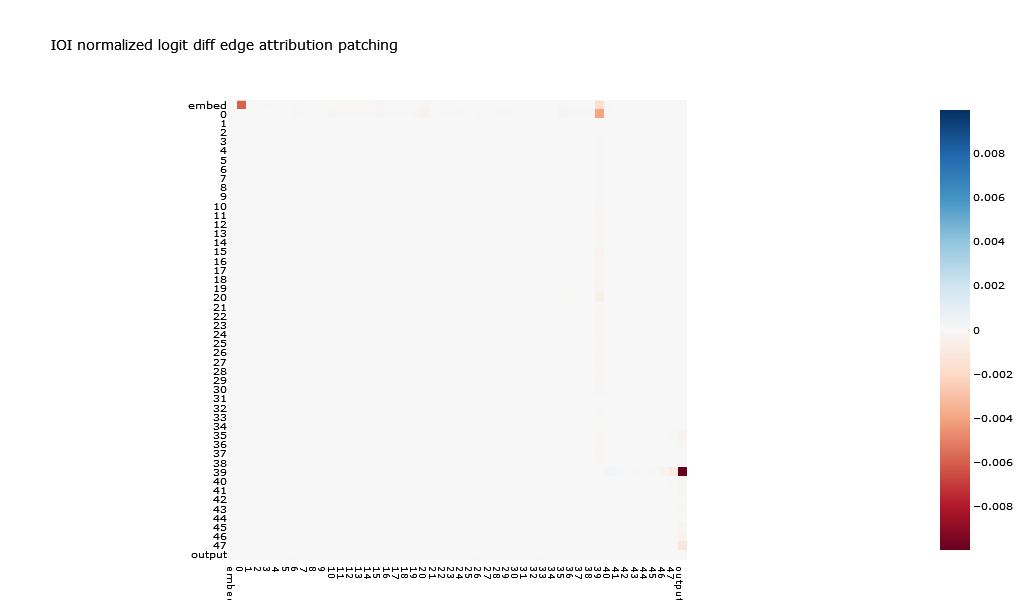

In [30]:

def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    plot_args = {
        'width': 800,
        'height': 600,
        "autosize": False,
        'showlegend': True,
        'margin': {"l":0,"r":0,"t":100,"b":0}
    }
    
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    if show:
        fig.show(renderer)
    else:
        return fig


layer_names = list(map(str, range(model.cfg.n_layers)))
layer_names = ['embed'] + layer_names + ['output']
imshow(attributions.mean(dim=0), x=layer_names, y=layer_names, color_continuous_midpoint=0, font_size=10, title='IOI normalized logit diff edge attribution patching')

In [11]:
import torch




[(1, 2), (4, 5), (21, 22)]

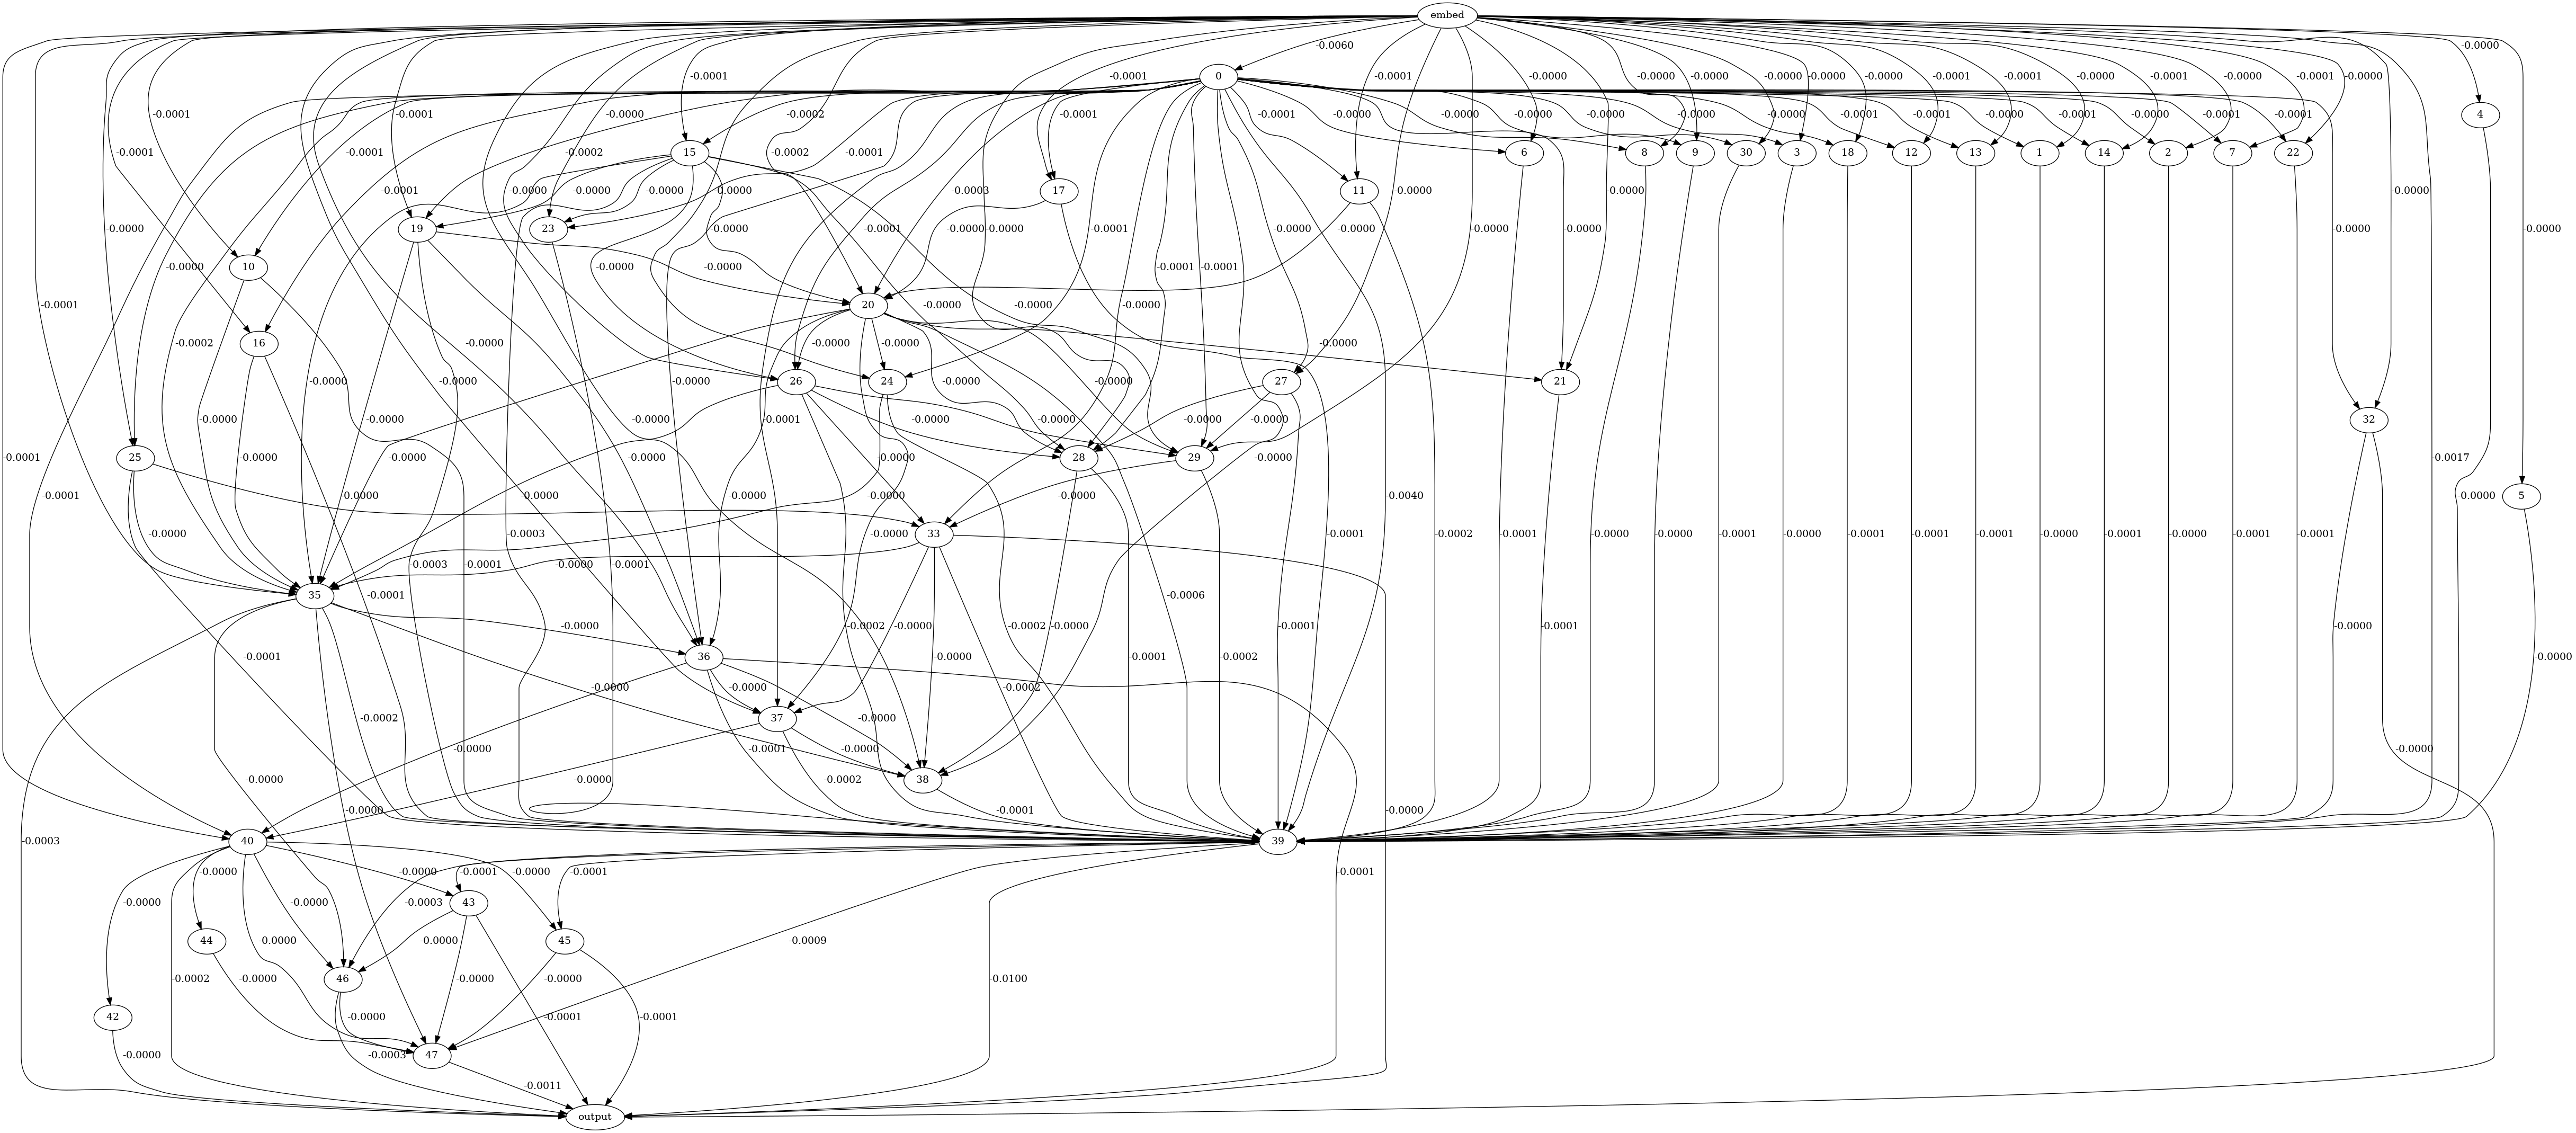

/home/dev/mamba_interp/pruned dot 0.85.png

pruned graph gets metric 0.8432875871658325 and acc 0.8523809313774109
unpruned graph gets metric 0.8432875871658325 and acc 0.8523809313774109


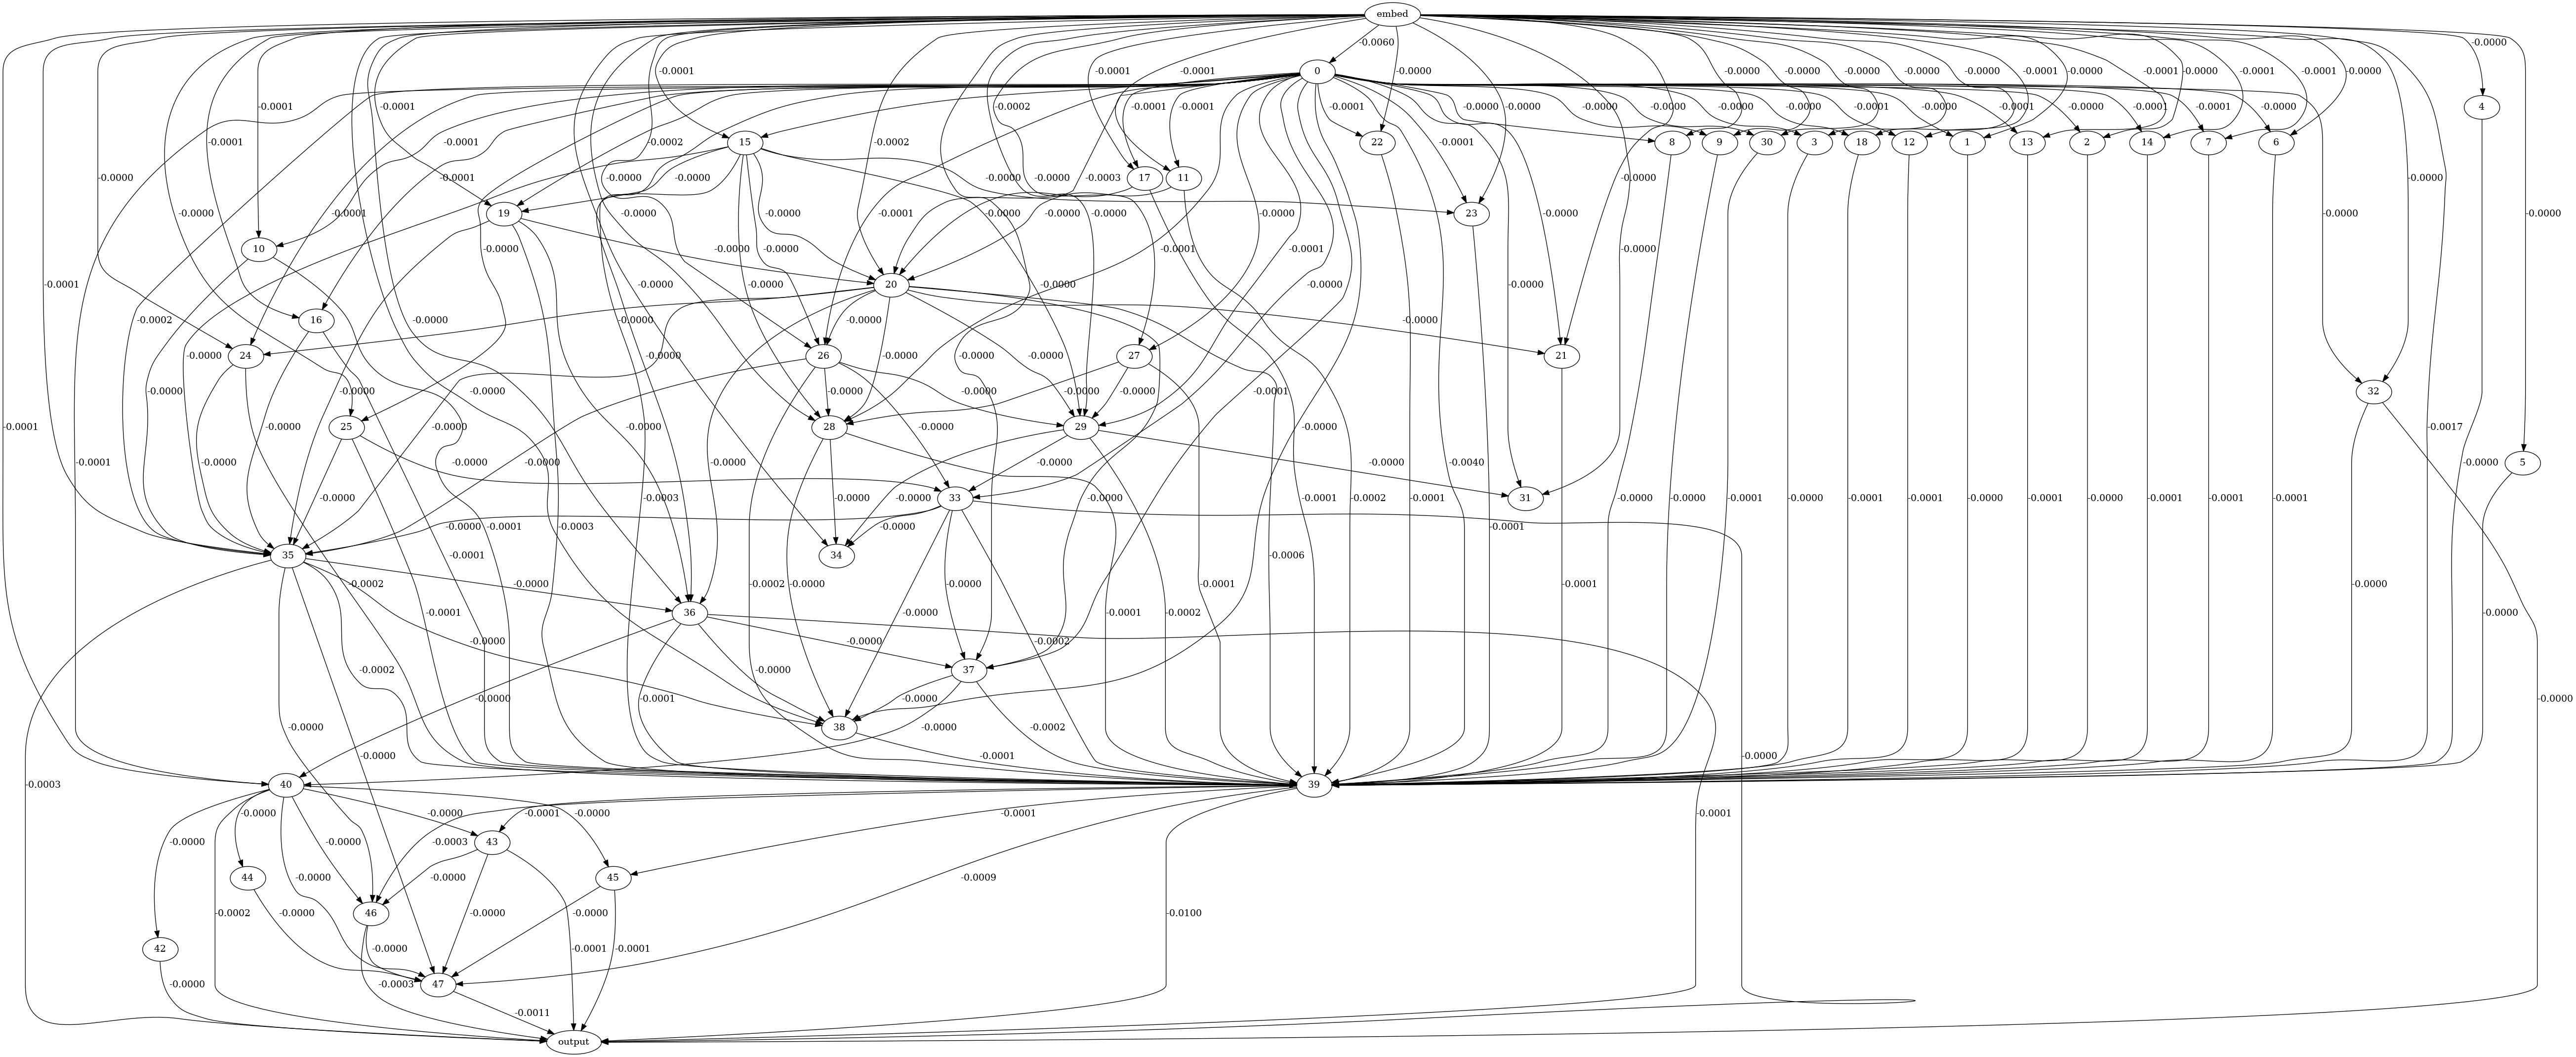

/home/dev/mamba_interp/dot 0.85.png

In [18]:
'''
import graphviz
from IPython.display import Image, display, clear_output, FileLink

attrib_dot = graphviz.Digraph('Attributions')
metric_dot = graphviz.Digraph('Metric improvements')
acc_dot = graphviz.Digraph('Acc improvements')
all_dot = graphviz.Digraph('All improvements')
prev_acc = 0
prev_metric = 0

def top_4_digits(f):
    return "{:.4f}".format(f)

def update(metric_thresh, stats_to_display):
    with output:
        clear_output()
        for input_layer, output_layer, attrib, metric, acc in edges_with_improvements:
            if metric >= metric_thresh:
                print(f"graph has accuracy {acc.item()}")
                break
            input_layer_str = str(input_layer)
            output_layer_str = str(output_layer)
            metric_improvement = metric - prev_metric
            acc_improvement = acc - prev_acc
            attrib_str = top_4_digits(attrib.item())
            attrib_dot.edge(input_layer_str, output_layer_str, label=attrib_str)
            metric_str = top_4_digits(metric_improvement.item())
            metric_dot.edge(input_layer_str, output_layer_str, label=metric_str)
            acc_str = top_4_digits(acc_improvement.item())
            acc_dot.edge(input_layer_str, output_layer_str, label=acc_str)
            all_dot.edge(input_layer_str, output_layer_str, label=f"t:{attrib_str},m:{metric_str},a:{acc_str}")
        
        for name, dot in zip(['attrib_dot', 'metric_dot', 'acc_dot', 'all_dot'], [attrib_dot, metric_dot, acc_dot, all_dot]):
            if stats_to_display == name:
                dot.render(name, format="png") # it automatically appends png
                display(Image(filename=name + ".png"))
                display(FileLink(name + ".png"))




import ipywidgets

output = ipywidgets.Output()

display(ipywidgets.interactive(update, metric_thresh=sorted(list(set([m.item() for _, _, _, m, _ in edges_with_improvements]))), stats_to_display=['attrib_dot', 'metric_dot', 'acc_dot', 'all_dot']))
display(output)
'''
import networkx as nx
def get_nx_graph(edges) -> nx.DiGraph:
    '''
    Converts the edges into a networkx graph
    only edges that have checked == True and patching == False are included
    if include_unchecked=True, any edge that has checked == False is also included
    '''
    G = nx.DiGraph()
    for score, (edge_input, edge_output, pos) in edges:
        G.add_edge(str(edge_input), str(edge_output), label=str(pos))
    return G

def prune_edges(edges, input_node, output_node):
    import networkx as nx
    G = get_nx_graph(edges=edges)
    connected_edges = []
    for score, (edge_input, edge_output,pos) in edges:
        connected_to_input = False
        try:
            to_input = nx.shortest_path(G, source=str(input_node), target=str(edge_input))
            connected_to_input = True
        except nx.NetworkXNoPath:
            pass
        except nx.NodeNotFound:
            raise ValueError(f"Graph does not have input node {input_node}")
        
        connected_to_output = False
        try:
            to_output = nx.shortest_path(G, source=str(edge_output), target=str(output_node))
            connected_to_output = True
        except nx.NetworkXNoPath:
            pass
        except nx.NodeNotFound:
            raise ValueError(f"Graph does not have output node {output_node}")
        if connected_to_input and connected_to_output:
            connected_edges.append((score, (edge_input, edge_output,pos)))
    return connected_edges


import graphviz
from IPython.display import Image, display, clear_output, FileLink

def top_4_digits(f):
    return "{:.4f}".format(f)

pruned_edges = prune_edges(list(zip(scores, edges_to_keep)), input_node='embed', output_node='output')

pruned_dot = graphviz.Digraph('graph')
for score, (i,o,pos) in pruned_edges:
    if pos is None:
        pruned_dot.edge(str(i),str(o), label=top_4_digits(score))
    else:
        pruned_dot.edge(str(i),str(o), label=f"{pos}[{top_4_digits(score)}]")
output_name = f'pruned dot {ACC_THRESH}'
pruned_dot.render(output_name, format="png") # it automatically appends png
display(Image(filename=output_name + ".png"))
display(FileLink(output_name + ".png"))




dot = graphviz.Digraph('graph')
for score, (i,o,pos) in zip(scores, edges_to_keep):
    if pos is None:
        dot.edge(str(i),str(o),label=top_4_digits(score))
    else:
        dot.edge(str(i),str(o),label=f"{pos}[{top_4_digits(score)}]")
metric, acc = test_graph([x[1] for x in pruned_edges])
print(f"pruned graph gets metric {metric} and acc {acc}")
metric, acc = test_graph(edges_to_keep)
print(f"unpruned graph gets metric {metric} and acc {acc}")
output_name = f'dot {ACC_THRESH}'
dot.render(output_name, format="png") # it automatically appends png
display(Image(filename=output_name + ".png"))
display(FileLink(output_name + ".png"))

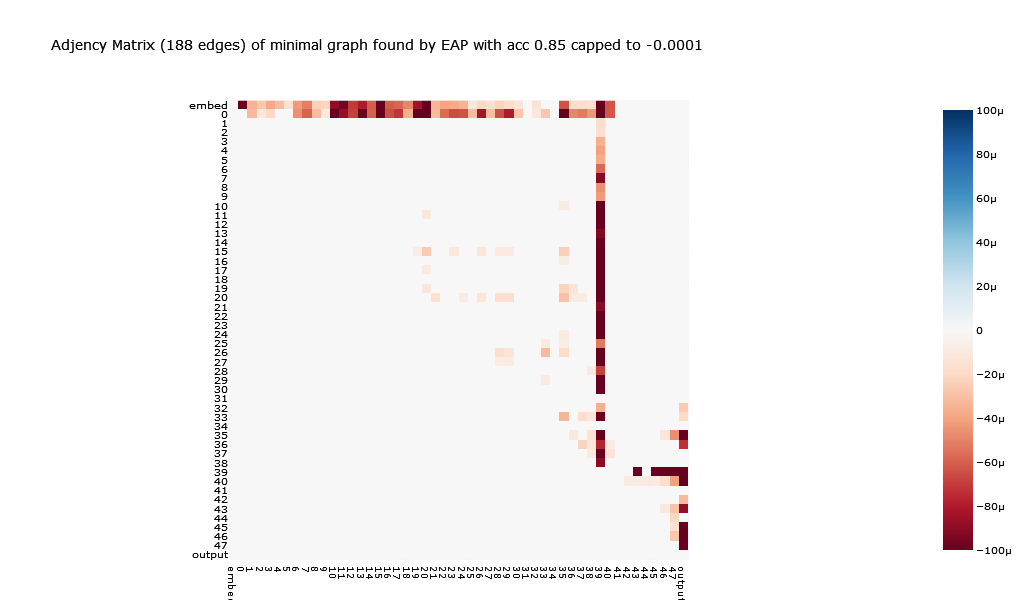

In [43]:

def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    plot_args = {
        'width': 800,
        'height': 600,
        "autosize": False,
        'showlegend': True,
        'margin': {"l":0,"r":0,"t":100,"b":0}
    }
    
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    if show:
        fig.show(renderer)
    else:
        return fig
import torch

def edge_to_i(edge):
    if edge == 'embed': return 0
    elif edge == 'output': return model.cfg.n_layers+1
    else: return edge+1

_, L = data.data.size()
if not POSITIONS:
    L = 1
adjacency_matrix = torch.zeros([model.cfg.n_layers+2,model.cfg.n_layers+2,L])
for score, (i,o,pos) in pruned_edges:
    adjacency_matrix[edge_to_i(i),edge_to_i(o),pos] = max(score, -0.0001)
layer_names = ['embed'] + list(map(str, range(model.cfg.n_layers))) + ['output']
for l in range(L):
    pos_str = f' for pos {l}'
    if not POSITIONS:
        pos_str = ""
    imshow(adjacency_matrix[:,:,l], x=layer_names, y=layer_names, color_continuous_midpoint=0, font_size=10, title=f'Adjency Matrix ({len(edges_to_keep)} edges) of minimal graph found by EAP with acc {ACC_THRESH} capped to -0.0001')

using templates
Then, [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
Afterwards [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
Friends [NAME], [NAME] and [NAME] went to the [PLACE]. [NAME] and [NAME] gave a [OBJECT] to
with name positions (2, 4, 6, 12, 14)
[('0', '1'), ('0', '10'), ('0', '11'), ('0', '12'), ('0', '13'), ('0', '14'), ('0', '15'), ('0', '16'), ('0', '17'), ('0', '18'), ('0', '19'), ('0', '2'), ('0', '20'), ('0', '21'), ('0', '22'), ('0', '23'), ('0', '24'), ('0', '25'), ('0', '26'), ('0', '27'), ('0', '28'), ('0', '29'), ('0', '3'), ('0', '30'), ('0', '32'), ('0', '33'), ('0', '35'), ('0', '36'), ('0', '37'), ('0', '38'), ('0', '39'), ('0', '40'), ('0', '6'), ('0', '7'), ('0', '8'), ('0', '9'), ('1', '39'), ('10', '35'), ('10', '39'), ('11', '20'), ('11', '39'), ('12', '39'), ('13', '39'), ('14', '39'), ('15', '19'), ('15', '20'), ('15', '23'), ('15', '26'), ('15', '28'), ('15', '29'), ('15', '35')

wandb: Currently logged in as: phylliidadev. Use `wandb login --relogin` to force relogin


starting new run 6yw970rm


all nodes: ['0.conv', '0.i', '0.o', '0.skip', '0.ssm', '1.conv', '1.i', '1.o', '1.skip', '1.ssm', '10.conv', '10.i', '10.o', '10.skip', '10.ssm', '11.conv', '11.i', '11.o', '11.skip', '11.ssm', '12.conv', '12.i', '12.o', '12.skip', '12.ssm', '13.conv', '13.i', '13.o', '13.skip', '13.ssm', '14.conv', '14.i', '14.o', '14.skip', '14.ssm', '15.conv', '15.i', '15.o', '15.skip', '15.ssm', '16.conv', '16.i', '16.o', '16.skip', '16.ssm', '17.conv', '17.i', '17.o', '17.skip', '17.ssm', '18.conv', '18.i', '18.o', '18.skip', '18.ssm', '19.conv', '19.i', '19.o', '19.skip', '19.ssm', '2.conv', '2.i', '2.o', '2.skip', '2.ssm', '20.conv', '20.i', '20.o', '20.skip', '20.ssm', '21.conv', '21.i', '21.o', '21.skip', '21.ssm', '22.conv', '22.i', '22.o', '22.skip', '22.ssm', '23.conv', '23.i', '23.o', '23.skip', '23.ssm', '24.conv', '24.i', '24.o', '24.skip', '24.ssm', '25.conv', '25.i', '25.o', '25.skip', '25.ssm', '26.conv', '26.i', '26.o', '26.skip', '26.ssm', '27.conv', '27.i', '27.o', '27.skip', '27.s

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([0.8434, 0.1307, 0.8311, 0.7309], device='cuda:0')
splitting 2 edges into two edge sets, as they have score 0.8433764576911926 which has diff 0.002015531063079834 > 0.0001
splitting 3 edges into two edge sets, as they have score 0.1306745707988739 which has diff 0.7147173881530762 > 0.0001
splitting 3 edges into two edge sets, as they have score 0.8310650587081909 which has diff 0.014326930046081543 > 0.0001
splitting 3 edges into two edge sets, as they have score 0.7308688163757324 which has diff 0.11452317237854004 > 0.0001
patching 1044 edges, keeping 96 edges, 469 remain
baseline score 0.8453919887542725
[1, 1, 1, 2, 1, 2, 1, 2] sized edge sets remaining


  0%|          | 0/8 [00:00<?, ?it/s]

got scores tensor([0.8443, 0.8445, 0.8318, 0.1443, 0.8379, 0.8385, 0.8379, 0.7384],
       device='cuda:0')
keeping edge edge  32.o -> output (('blocks.32.hook_out_proj', <function storage_hook at 0x7f49bbd09cf0>) -> ('blocks.47.hook_resid_post', functools.partial(<function resid_patching_hook at 0x7f49c468d480>, position=None)))) with score 0.8442645072937012 which has diff 0.001127481460571289 > 0.0001
keeping edge edge  33.o -> output (('blocks.33.hook_out_proj', <function storage_hook at 0x7f49bbd09cf0>) -> ('blocks.47.hook_resid_post', functools.partial(<function resid_patching_hook at 0x7f49c468d480>, position=None)))) with score 0.8445037603378296 which has diff 0.0008882284164428711 > 0.0001
keeping edge edge  35.o -> output (('blocks.35.hook_out_proj', <function storage_hook at 0x7f49bbd09cf0>) -> ('blocks.47.hook_resid_post', functools.partial(<function resid_patching_hook at 0x7f49c468d480>, position=None)))) with score 0.8317539691925049 which has diff 0.013638019561767578 

  0%|          | 0/6 [00:00<?, ?it/s]

got scores tensor([0.8426, 0.1471, 0.8454, 0.8386, 0.8224, 0.7614], device='cuda:0')
keeping edge edge  36.o -> output (('blocks.36.hook_out_proj', <function storage_hook at 0x7f49bbd09cf0>) -> ('blocks.47.hook_resid_post', functools.partial(<function resid_patching_hook at 0x7f49c468d480>, position=None)))) with score 0.8425776362419128 which has diff 0.002814352512359619 > 0.0001
keeping edge edge  39.o -> output (('blocks.39.hook_out_proj', <function storage_hook at 0x7f49bbd09cf0>) -> ('blocks.47.hook_resid_post', functools.partial(<function resid_patching_hook at 0x7f49c468d480>, position=None)))) with score 0.14712636172771454 which has diff 0.6982656121253967 > 0.0001
keeping edge edge  43.o -> output (('blocks.43.hook_out_proj', <function storage_hook at 0x7f49bbd09cf0>) -> ('blocks.47.hook_resid_post', functools.partial(<function resid_patching_hook at 0x7f49c468d480>, position=None)))) with score 0.8385641574859619 which has diff 0.006827831268310547 > 0.0001
keeping edge edg

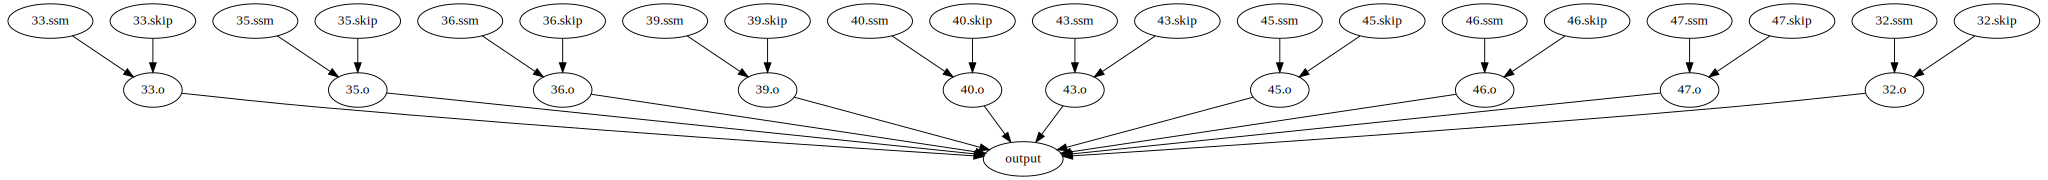

saved to checkpoint 6yw970rm/checkpoint 0.pkl
patching 1053 edges, keeping 98 edges, 458 remain
patching 1053 edges, keeping 98 edges, 458 remain
baseline score 0.8453720808029175
[1, 1] sized edge sets remaining
got scores tensor([0.8133, 0.7934], device='cuda:0')
keeping edge edge  47.conv -> 47.ssm (None -> [('blocks.47.hook_h.0', <function overwrite_h_hook at 0x7f49c468d240>), ('blocks.47.hook_h.1', <function overwrite_h_hook at 0x7f49c468d240>), ('blocks.47.hook_h.2', <function overwrite_h_hook at 0x7f49c468d240>), ('blocks.47.hook_h.3', <function overwrite_h_hook at 0x7f49c468d240>), ('blocks.47.hook_h.4', <function overwrite_h_hook at 0x7f49c468d240>), ('blocks.47.hook_h.5', <function overwrite_h_hook at 0x7f49c468d240>), ('blocks.47.hook_h.6', <function overwrite_h_hook at 0x7f49c468d240>), ('blocks.47.hook_h.7', <function overwrite_h_hook at 0x7f49c468d240>), ('blocks.47.hook_h.8', <function overwrite_h_hook at 0x7f49c468d240>), ('blocks.47.hook_h.9', <function overwrite_h_hoo

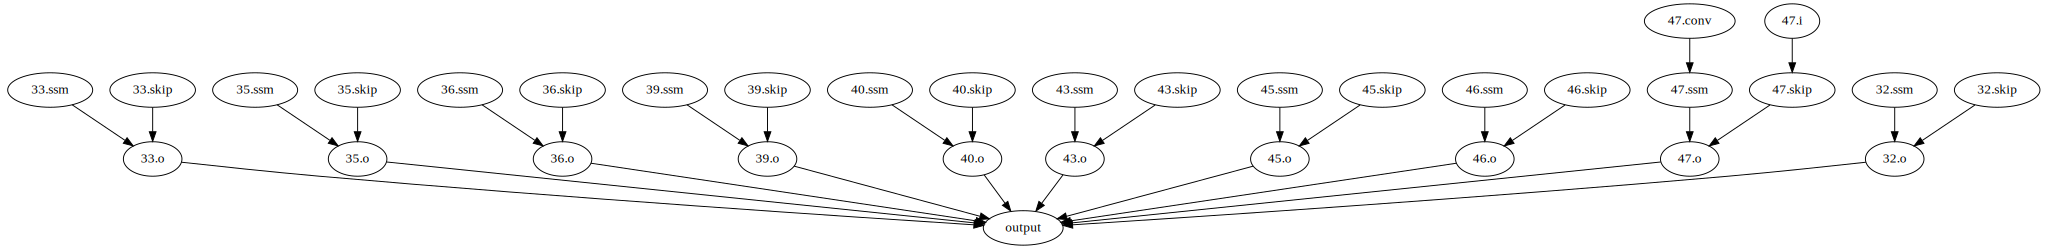

saved to checkpoint 6yw970rm/checkpoint 1.pkl
patching 1053 edges, keeping 100 edges, 456 remain
patching 1053 edges, keeping 100 edges, 456 remain
baseline score 0.8453720808029175
[4] sized edge sets remaining


TypeError: conv_patching_hook() missing 1 required positional argument: 'computing_attribution'

In [19]:
import sys
import torch
import os
import sys
import wandb
import os
import signal
import acdc
from tqdm import tqdm
from typing import Any  
from transformer_lens.hook_points import HookPoint
from acdc import (
    Edge,
    ACDCConfig,
    LOG_LEVEL_INFO,
    LOG_LEVEL_DEBUG,
    run_acdc,
    ACDCEvalData,
    load_checkpoint,
    get_most_recent_checkpoint
)


from acdc import get_pad_token

from functools import partial


global storage
def storage_hook(
    x,
    hook: HookPoint,
    **kwargs,
):
    global storage
    #if hook.name == 'hook_embed':
    #    for k in list(storage.keys()):
    #        del storage[k]
    storage[hook.name] = x
    return x

def resid_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    global storage
    x_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
    x_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
    if position is None: # if position not specified, apply to all positions
        x[batch_start:batch_end:2] = x[batch_start:batch_end:2] - x_uncorrupted + x_corrupted
    else:
        x[batch_start:batch_end:2,position] = x[batch_start:batch_end:2,position] - x_uncorrupted[:,position] + x_corrupted[:,position]
    return x

def overwrite_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    x_corrupted = x[batch_start+1:batch_end:2]
    if position is None: # if position not specified, apply to all positions
        x[batch_start:batch_end:2] = x_corrupted
    else:
        if x_corrupted.size()[1] != L: raise ValueError(f'warning: in hook {hook.name} with input_hook_name {input_hook_name} you are patching on position in the second index but size is {x_corrupted.size()}')
        x[batch_start:batch_end:2,position] = x_corrupted[:,position]
    return x


def overwrite_h_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    x[batch_start:batch_end:2] = x[batch_start+1:batch_end:2]
    return x

# we do a hacky thing where this first hook clears the global storage
# second hook stores all the hooks
# then third hook computes the output (over all the hooks)
# this avoids recomputing and so is much faster
CONV_HOOKS = "conv hooks"
CONV_BATCHES = "conv batches"
def conv_patching_init_hook(
    x,
    hook: HookPoint,
    batch_start: int,
    batch_end: int,
    **kwargs
):
    # we need to clear this here
    # i tried having a "current layer" variable in the conv_storage that only clears when it doesn't match
    # but that doesn't work if you only patch the same layer over and over,
    # as stuff gets carried over
    # this way of doing things is much safer and lets us assume it'll be empty
    # well not quite, note that conv_patching_hook will be called with different batch_start and batch_end inputs during one forward pass
    # so we need to account for that in the keys we use
    global conv_storage
    conv_storage = {CONV_BATCHES: set()}
    return x

# hook h has a weird index!!!!!

def conv_patching_storage_hook(
    x,
    hook: HookPoint,
    conv_filter_i: int,
    position: int,
    layer: int,
    batch_start: int,
    batch_end: int,
    **kwargs,
):
    global storage
    storage[hook.name] = x
    global conv_storage
    hooks_key = (CONV_HOOKS, batch_start, batch_end)
    if not hooks_key in conv_storage:
        conv_storage[hooks_key] = [] # we can't do this above because it'll be emptied again on the next batch before this is called
    conv_storage[hooks_key].append({"position": position, "conv_filter_i": conv_filter_i})
    conv_storage[CONV_BATCHES].add((batch_start, batch_end))
    return x

from jaxtyping import Float
from einops import rearrange


global storage_for_grad

global conv_storage
def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    input_hook_name: str,
    layer: int,
    computing_attribution: bool,
    **kwargs,
) -> Float[torch.Tensor, "B L E"]:
    global conv_storage
    global storage
    ### This is identical to what the conv is doing
    # but we break it apart so we can patch on individual filters

    # we have two input hooks, the second one is the one we want
    input_hook_name = input_hook_name[1]
    
    D_CONV = model.cfg.d_conv

    # given batches like [(2,4), (5,6)] and total size 7 this returns (0,2), (4,5), (6,7) 
    def get_missing_batches(batches, B):
        covered_i = torch.zeros([B])
        for batch_start, batch_end in batches:
            covered_i[batch_start:batch_end] = 1
    
        missing_batches = []
        missing_start = 0
        for i in range(B):
            if covered_i[i] == 1:
                if i != missing_start:
                    missing_batches.append((missing_start, i))
                missing_start = i+1
        if covered_i[B-1] == 0:
            missing_batches.append((missing_start, B))
        return missing_batches
    

    
    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    
    # don't recompute these if we don't need to
    # because we stored all the hooks and batches in conv_storage, we can just do them all at once
    output_key = f'output' # they need to share an output because they write to the same output tensor
    if not output_key in conv_storage:
        #print("layer", layer, "keys", conv_storage)
        apply_to_all_hooks = [] # this is important because otherwise the [0:None] would overwrite the previous results (or vice versa)
        apply_to_all_key = (CONV_HOOKS, 0, None)
        if apply_to_all_key in conv_storage:
            apply_to_all_hooks = conv_storage[apply_to_all_key]
            # we need to do this so it applies to the other batches that we aren't otherwise patching
            for batch_start, batch_end in get_missing_batches(conv_storage[CONV_BATCHES], conv_input.size()[0]):
                conv_storage[CONV_BATCHES].add(batch_start, batch_end)
                conv_storage[(CONV_HOOKS, batch_start, batch_end)] = []
        for batch_start, batch_end in conv_storage[CONV_BATCHES]:
            if batch_start == 0 and batch_end == None: continue # we cover this in the apply to all hooks above
            def get_filter_key(i):
                return f'filter_{i}'
            conv_input_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
            conv_input_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
            B, L, E = conv_input_uncorrupted.size()
            
            conv_input_uncorrupted = rearrange(conv_input_uncorrupted, 'B L E -> B E L')
            conv_input_corrupted = rearrange(conv_input_corrupted, 'B L E -> B E L')
            
            # pad zeros in front
            # [B,E,D_CONV-1+L]
            padded_input_uncorrupted = torch.nn.functional.pad(conv_input_uncorrupted, (D_CONV-1,0), mode='constant', value=0)
            padded_input_corrupted = torch.nn.functional.pad(conv_input_corrupted, (D_CONV-1,0), mode='constant', value=0)
    
            # compute the initial filter values
            for i in range(D_CONV):
                filter_key = get_filter_key(i)
                # [B,E,L]                      [E,1]                      [B,E,L]
                filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input_uncorrupted[:,:,i:i+L]
                conv_storage[filter_key] = filter_contribution
            
            # apply all the hooks
            for hook in conv_storage[(CONV_HOOKS, batch_start, batch_end)] + apply_to_all_hooks:
                position = hook['position']
                conv_filter_i = hook['conv_filter_i']
                #print(f"position {position} conv_filter_i {conv_filter_i} batch_start {batch_start} batch_end {batch_end}")
                filter_key = get_filter_key(conv_filter_i)
                # [1,E,L]                                   [E,1]                          # [B,E,L]
                corrupted_filter_contribution = conv_weight[:,0,conv_filter_i].view(E,1)*padded_input_corrupted[:,:,conv_filter_i:conv_filter_i+L]
                filter_contribution = conv_storage[filter_key]
                if position is None:
                    # [B,E,L]                    [B,E,L]
                    filter_contribution = corrupted_filter_contribution
                else:
                    # [B,E]                                                  [B,E]
                    filter_contribution[:,:,position] = corrupted_filter_contribution[:,:,position]
                conv_storage[filter_key] = filter_contribution
            
            # compute the output
            output = torch.sum([conv_storage[get_filter_key(i)] for i in range(D_CONV)])
            #output = torch.zeros([B,E,L], device=model.cfg.device)
            #print(f'B {B} B2 {B2} E {E} L {L} conv_storage keys {conv_storage.keys()} filter sizes {[(k,v.size()) for (k,v) in conv_storage.items() if not type(v) is int]}')
            for i in range(D_CONV):
                filter_key = get_filter_key(i)
                #output += conv_storage[filter_key]
                del conv_storage[filter_key] # clean up now we are done with it, just to be safe
                
            # bias is not dependent on input so no reason to patch on it, just apply it as normal
            output += conv_bias.view(E, 1)
            output = rearrange(output, 'B E L -> B L E')
            # interleave it back with the corrupted as every other
            conv_output[batch_start:batch_end:2] = output
        conv_storage[output_key] = conv_output
    return conv_storage[output_key]





# prunings for ioi
#limited_layers = [0, 8, 9, 11, 12, 14, 15, 18, 20, 21, 24, 25, 26, 27, 28, 33, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
#limited_layers = [0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 30, 31, 33, 39, 44, 45, 46, 47]
# limited_layers = [0, 7, 10, 11, 16, 17, 18, 19, 23, 24, 25, 28, 33, 39, 45, 46, 47]
# prunings for greater than
#limited_layers = [0, 11, 14, 15, 17, 21, 25, 28, 29, 30, 31, 33, 34, 35, 36, 37, 40, 41, 43, 44, 45, 46, 47]
#limited_layers = [0, 11, 15, 17, 20, 21, 24, 25, 26, 27, 28, 29, 31, 33, 34, 36, 37, 39, 43, 44, 45, 46, 47]

limited_layers = list(range(model.cfg.n_layers))


from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
from acdc.data.utils import generate_dataset

num_patching_pairs = 200
seed = 27
valid_seed = 28
constrain_to_answers = True
# this makes our data size 800, first 400 is each (a,b) pair, and then second 400 is each pair swapped to be (b,a)
has_symmetric_patching = True

from acdc.data.ioi import BABA_TEMPLATES
templates = ABC_TEMPLATES
patching_formats = list(get_all_single_name_abc_patching_formats())

    

# generate data once to populate good_names and good_nouns (holds single-token choices)
data = generate_dataset(model=model,
                  data_generator=ioi_data_generator,
                  num_patching_pairs=num_patching_pairs,
                  seed=seed,
                  valid_seed=valid_seed,
                  constrain_to_answers=constrain_to_answers,
                  has_symmetric_patching=has_symmetric_patching, 
                  varying_data_lengths=True,
                  templates=templates,
                  patching_formats=patching_formats)

import acdc.data.ioi
from collections import defaultdict
name_positions_map = defaultdict(lambda: [])
for template in templates:
    name = acdc.data.ioi.good_names[0]
    template_filled_in = template.replace("[NAME]", name)
    template_filled_in = template_filled_in.replace("[PLACE]", acdc.data.ioi.good_nouns['[PLACE]'][0])
    template_filled_in = template_filled_in.replace("[OBJECT]", acdc.data.ioi.good_nouns['[OBJECT]'][0])
    # get the token positions of the [NAME] in the prompt
    name_positions = tuple([(i) for (i,s) in enumerate(model.to_str_tokens(torch.tensor(model.tokenizer.encode(template_filled_in)))) if s == f' {name}'])
    name_positions_map[name_positions].append(template)
sorted_by_frequency = sorted(list(name_positions_map.items()), key=lambda x: -len(x[1]))
most_frequent_name_positions, templates = sorted_by_frequency[0]
print("using templates")
for template in templates:
    print(template)
print(f"with name positions {most_frequent_name_positions}")

data = generate_dataset(model=model,
              data_generator=ioi_data_generator,
              num_patching_pairs=num_patching_pairs,
              seed=seed,
              valid_seed=valid_seed,
              constrain_to_answers=constrain_to_answers,
              has_symmetric_patching=has_symmetric_patching, 
              varying_data_lengths=True,
              templates=templates,
              patching_formats=patching_formats)


## Setup edges for ACDC
edges = []
B,L = data.data.size()
#positions = list(range(L)) # 
positions = [None]

INPUT_HOOK = f'hook_embed'
INPUT_NODE = 'embed'

last_layer = model.cfg.n_layers-1
OUTPUT_HOOK = f'blocks.{last_layer}.hook_resid_post'
OUTPUT_NODE = 'output'

def input(layer):
    return f'{layer}.i'

def output(layer):
    return f'{layer}.o'

def conv(layer):
    return f'{layer}.conv'

def skip(layer):
    return f'{layer}.skip'

def ssm(layer):
    return f'{layer}.ssm'

# important to have storage be global and not passed into the hooks! Otherwise it gets very slow (tbh, i don't know why)
global storage
storage = {}

for pos in positions:
    # direct connections from embed to output
    edges.append(Edge(
            label=str(pos),
            input_node=INPUT_NODE,
            input_hook=(INPUT_HOOK, storage_hook),
            output_node=OUTPUT_NODE,
            output_hook=(OUTPUT_HOOK, partial(resid_patching_hook, position=pos)),
    ))

for layer in limited_layers:
    for pos_i, pos in enumerate(positions):
        # edge from embed to layer input
        edges.append(Edge(
                label=str(pos),
                input_node=INPUT_NODE,
                input_hook=(INPUT_HOOK, partial(storage_hook)),
                output_node=input(layer),
                output_hook=(f'blocks.{layer}.hook_layer_input', partial(resid_patching_hook, position=pos)),
        ))

        # input to conv
        for conv_i in range(model.cfg.d_conv):
            edges.append(Edge(
                    label=(f'[{pos}:{conv_i-model.cfg.d_conv+1}]'.replace("None:", "")), # [-D_CONV+1, -D_CONV+2, ..., -2, -1, 0]
                    input_node=input(layer),
                    input_hook=[
                        (f'blocks.{layer}.hook_layer_input', conv_patching_init_hook),
                        (f'blocks.{layer}.hook_in_proj', partial(conv_patching_storage_hook, position=pos, layer=layer, conv_filter_i=conv_i))
                    ],
                    output_node=conv(layer),
                    output_hook=(f'blocks.{layer}.hook_conv', partial(conv_patching_hook, position=pos, layer=layer, conv_filter_i=conv_i)),
            ))
        
        # conv to ssm
        if pos is None:
            # we need a seperate hook for each pos, but put them all into one edge
            hooks = []
            for other_pos in range(L):
                hooks.append((f'blocks.{layer}.hook_h.{other_pos}', overwrite_h_hook))
            edges.append(Edge(
                    input_node=conv(layer),
                    output_node=ssm(layer),
                    output_hook=hooks,
            ))
        else:
            edges.append(Edge(
                    label=f'{pos}',
                    input_node=conv(layer),
                    output_node=ssm(layer),
                    output_hook=(f'blocks.{layer}.hook_h.{pos}', overwrite_h_hook),
            ))

        if pos_i == 0: # we only need one of these
            # ssm to output
            edges.append(Edge(
                    input_node=ssm(layer),
                    output_node=output(layer),
            ))
        
        # input to skip
        edges.append(Edge(
                label=f'{pos}',
                input_node=input(layer),
                output_node=skip(layer),
                output_hook=(f'blocks.{layer}.hook_skip', partial(overwrite_patching_hook, position=pos)),
        ))

        if pos_i == 0: # we only need one of these
            # skip to output
            edges.append(Edge(
                    input_node=skip(layer),
                    output_node=output(layer),
            ))
        '''
        edges.append(Edge(
                input_node=input(layer),
                output_node=output(layer),
        ))
        '''
        for later_layer in limited_layers:
                if layer < later_layer:
                    # edge from layer output to other layer input
                    edges.append(Edge(
                            label=str(pos),
                            input_node=output(layer),
                            input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
                            output_node=input(later_layer),
                            output_hook=(f'blocks.{later_layer}.hook_layer_input', partial(resid_patching_hook, position=pos)),
                    ))
        
        # edge from layer output to final layer output
        edges.append(Edge(
                label=str(pos),
                input_node=output(layer),
                input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
                output_node=OUTPUT_NODE,
                output_hook=(OUTPUT_HOOK, partial(resid_patching_hook, position=pos)),
        ))

'''
layers_available = set()
for score, (input_layer, output_layer) in pruned_edges:
    layers_available.add(input_layer)
    layers_available.add(output_layer)

def get_possible_nodes_of_layer(layer):
    if layer == 'embed':
        return [INPUT_NODE]
    elif layer == 'output':
        return [OUTPUT_NODE]
    else:
        return [output(layer), input(layer), skip(layer), ssm(layer), conv(layer)]
'''

# we have edges between layers
# now, that is edges between output(input_layer) and input(output_layer)
# we can then allow pruning to remove stranded nodes

keeping_edges = set()
for score, (input_layer, output_layer, pos) in pruned_edges:
    keeping_edges.add((str(input_layer), str(output_layer)))

print(sorted(list(keeping_edges)))


totes_keep = []
for edge in edges:
    is_between_layers = False
    layer_input = None
    layer_output = None
    if edge.input_node == INPUT_NODE:
        is_between_layers = True
        layer_input = 'embed'
    if edge.output_node == OUTPUT_NODE:
        is_between_layers = True
        layer_output = 'output'

    if '.' in edge.input_node:
        input_layer, input_type = edge.input_node.split(".")
        if edge.input_node == output(input_layer):
            is_between_layers = True
            layer_input = str(input_layer)
    if '.' in edge.output_node:
        output_layer, output_type = edge.output_node.split(".")
        if edge.output_node == input(output_layer):
            is_between_layers = True
            layer_output = str(output_layer)
    if is_between_layers:
        if (layer_input, layer_output) in keeping_edges:
            edge.patching = False
            edge.checked = False
            totes_keep.append((edge.input_node, edge.output_node))
        else:
            edge.patching = True
            edge.checked = True
    else:
        edge.patching = False
        edge.checked = False

print(list(sorted(totes_keep)))

model_kwargs = {
    'fast_ssm': False,
    'fast_conv': False,
}    

def normalized_logit_diff_acdc_metric(data: ACDCEvalData, printing=False):
    B,V = data.patched.logits.size()

    # [batch_size]
    patched_correct = data.patched.correct[:,0]
    #print(data.unpatched.logits.size(), data.patched.logits.size(), data.corrupted.logits.size())
    A_logits_unpatched = data.unpatched.logits[torch.arange(B), patched_correct]
    A_logits_patched = data.patched.logits[torch.arange(B), patched_correct]
    A_logits_corrupted = data.corrupted.logits[torch.arange(B), patched_correct]

    corrupted_correct = data.corrupted.correct[:,0]
    B_logits_unpatched = data.unpatched.logits[torch.arange(B), corrupted_correct]
    B_logits_patched = data.patched.logits[torch.arange(B), corrupted_correct]
    B_logits_corrupted = data.corrupted.logits[torch.arange(B), corrupted_correct]

    # A and B are two potential outputs
    # if A patched > B patched, we are correct
    # else we are incorrect

    # thus we could just return A_logits_patched - B_logits_patched

    # however it is useful to "normalize" these values

    # in the worst case, our patching causes us to act like corrupted, and our diff will be
    # A_logits_corrupted - B_logits_corrupted
    # this will result in a small, negative value
    
    # in the best case, our patching will do nothing (cause us to act like unpatched), and our diff will be
    # A_logits_unpatched - B_logits_unpatched
    # this will result in a large, positive value

    # thus we can treat those as the "min" and "max" and normalize accordingly
    
    min_diff = A_logits_corrupted - B_logits_corrupted
    max_diff = A_logits_unpatched - B_logits_unpatched

    possible_range = (max_diff-min_diff)
    possible_range[possible_range == 0] = 1.0 # prevent divide by zero
    
    diff = A_logits_patched - B_logits_patched
    normalized_diff = (diff-min_diff)/torch.abs(possible_range) # abs prevents incorrect data from wanting to be more incorrect

    if printing:
        print(f"A corrupted {A_logits_corrupted}")
        print(f"B corrupted {B_logits_corrupted}")
        print(f"A unpatched {A_logits_unpatched}")
        print(f"B unpatched {B_logits_unpatched}")
        print(f"A patched {A_logits_patched}")
        print(f"B patched {B_logits_patched}")
        print(f"min diff {min_diff}")
        print(f"max diff {max_diff}")
        print(f"possible range {possible_range}")
        print(f"diff {diff}")
        print(f"normalized diff {normalized_diff}")
    # as described, 1.0 corresponds to acting like unpatched,
    # and 0.0 corresponds to acting like corrupted

    return torch.mean(normalized_diff)


job_name_text = 'mamba acdc full 4' + ".txt"
wandb.login()
acdc.tqdm = tqdm

if os.path.exists(job_name_text):
    with open(job_name_text, "r") as f:
        wandb_id = f.read().strip()
    print(f"resuming from {wandb_id}")
    resume = True
else:
    wandb_id = wandb.util.generate_id()
    with open(job_name_text, "w") as f:
        f.write(wandb_id)
    print(f"starting new run {wandb_id}")
    resume = False



from functools import partial
import acdc
#normalized_diff = data.eval(model=model, batch_size=3, metric=partial(normalized_logit_diff_metric, printing=True), store_unpatched_logits=True)
#print(f"normalized diff {normalized_diff}")
cfg = ACDCConfig(
    ckpt_directory = wandb_id,
    thresh = 0.0001,
    rollback_thresh = 0.0001,
    metric=normalized_logit_diff_acdc_metric,
    # extra inference args
    model_kwargs=model_kwargs,
    # these are needed for doing graph pruning
    input_node=INPUT_NODE,
    output_node=OUTPUT_NODE,
    # batch size for evaluating data points
    batch_size=1,
    log_level=LOG_LEVEL_INFO,
    # if False, will be equivalent to batch_size=1
    batched = True,
    # set these two to false to use traditional ACDC
    # recursive will try patching multiple at a time (this is faster sometimes)
    recursive = True,
    # try_patching_multiple_at_same_time will evaluate many different patchings before commiting to any
    # and includes a rollback scheme if after patching one, the others get worse
    try_patching_multiple_at_same_time = True,
    ## if true, you metric will also have the logits from a run with no patching available
    # (useful for normalized logit diff)
    store_unpatched_logits = True,
)

wandb_resume = None
if resume:
    try:
        most_recent_checkpoint_path, is_done = get_most_recent_checkpoint(checkpoint_dir=cfg.ckpt_directory)
        if is_done:
            print(f"run {cfg.ckpt_directory} is completed")
        else:
            print(f"resuming from checkpoint {most_recent_checkpoint_path}")
            old_cfg, edges = load_checkpoint(path=most_recent_checkpoint_path)
            cfg.iter = old_cfg.iter
            wandb_resume = 'must'
    except FileNotFoundError:
        print(f"no checkpoints available at {cfg.ckpt_directory}, starting from scratch")
class InterruptedException(Exception):
    pass

def interrupt_callback(sig_num: Any, stack_frame: Any):
    raise InterruptedException()


# remember to do
# pip install -e .
# in the root directory of this repo
# also
# to install graphviz:
# sudo apt-get update
# sudo apt-get install graphviz xdg-utils

wandb.finish()
wandb.login()
try:
    wandb.init(
        project="mamba-acdc",
        config=cfg,
        name=job_name_text.replace(".txt", "") + f' thresh={cfg.thresh} rollback_thresh={cfg.rollback_thresh}',
        resume=wandb_resume,
        id=wandb_id,
    )
    # signal handlers (if preempted)
    signal.signal(signal.SIGINT, interrupt_callback)
    signal.signal(signal.SIGTERM, interrupt_callback)
    result_edges = run_acdc(model=model, data=data, cfg=cfg, edges=edges)
except (KeyboardInterrupt, InterruptedException):
    print("interrupted")

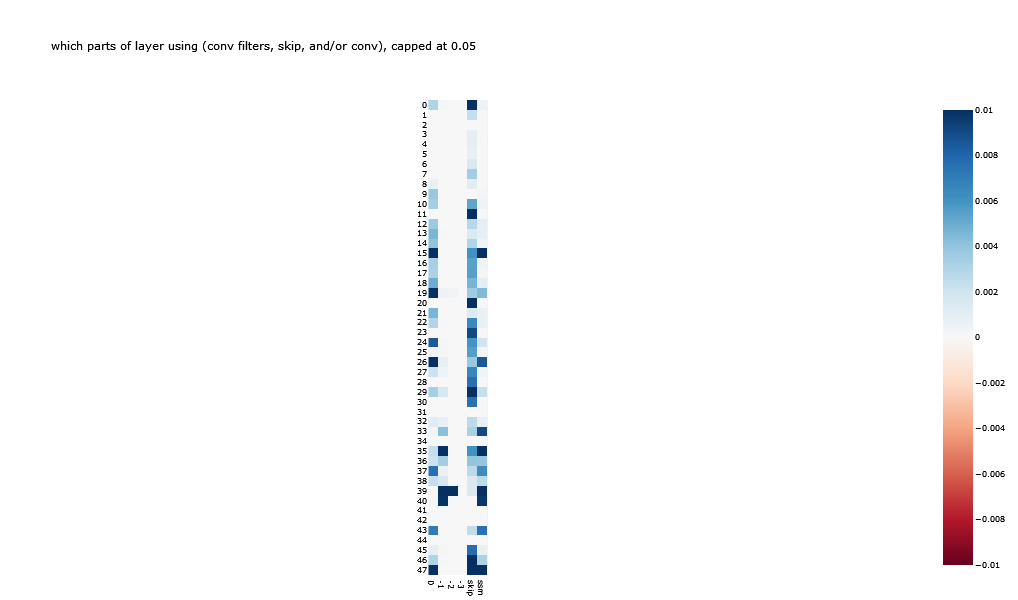

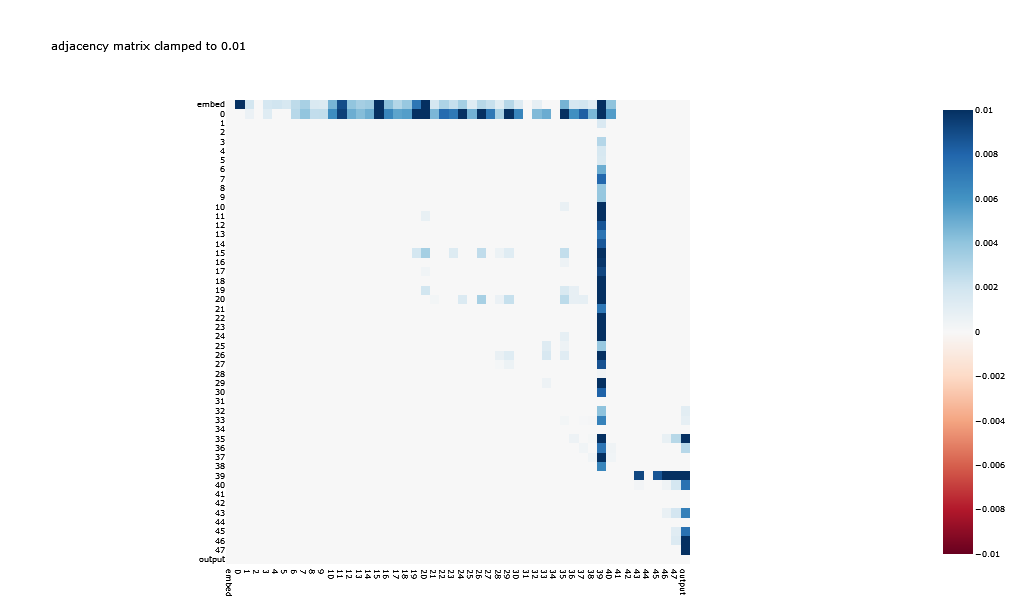

'\ndot = acdc.get_graphviz_graph(edges=edges, cfg=cfg)\noutput_name = \'first pass result\'\ndot.render(output_name, format="png") # it automatically appends png\ndisplay(Image(filename=output_name + ".png"))\ndisplay(FileLink(output_name + ".png"))\n'

In [47]:
from acdc import ACDCEvalData
from transformer_lens.hook_points import HookPoint
import torch
from jaxtyping import Float
global storage
def storage_hook(
    x,
    hook: HookPoint,
    **kwargs,
):
    global storage
    #if hook.name == 'hook_embed':
    #    for k in list(storage.keys()):
    #        del storage[k]
    storage[hook.name] = x
    return x

def resid_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    global storage
    x_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
    x_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
    if position is None: # if position not specified, apply to all positions
        x[batch_start:batch_end:2] = x[batch_start:batch_end:2] - x_uncorrupted + x_corrupted
    else:
        x[batch_start:batch_end:2,position] = x[batch_start:batch_end:2,position] - x_uncorrupted[:,position] + x_corrupted[:,position]
    return x

def overwrite_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    x_corrupted = x[batch_start+1:batch_end:2]
    if position is None: # if position not specified, apply to all positions
        x[batch_start:batch_end:2] = x_corrupted
    else:
        if x_corrupted.size()[1] != L: raise ValueError(f'warning: in hook {hook.name} with input_hook_name {input_hook_name} you are patching on position in the second index but size is {x_corrupted.size()}')
        x[batch_start:batch_end:2,position] = x_corrupted[:,position]
    return x


def overwrite_h_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
    position: int = None,
):
    x[batch_start:batch_end:2] = x[batch_start+1:batch_end:2]
    return x

# we do a hacky thing where this first hook clears the global storage
# second hook stores all the hooks
# then third hook computes the output (over all the hooks)
# this avoids recomputing and so is much faster
CONV_HOOKS = "conv hooks"
CONV_BATCHES = "conv batches"
def conv_patching_init_hook(
    x,
    hook: HookPoint,
    batch_start: int,
    batch_end: int,
    **kwargs
):
    # we need to clear this here
    # i tried having a "current layer" variable in the conv_storage that only clears when it doesn't match
    # but that doesn't work if you only patch the same layer over and over,
    # as stuff gets carried over
    # this way of doing things is much safer and lets us assume it'll be empty
    # well not quite, note that conv_patching_hook will be called with different batch_start and batch_end inputs during one forward pass
    # so we need to account for that in the keys we use
    global conv_storage
    conv_storage = {CONV_BATCHES: set()}
    return x

# hook h has a weird index!!!!!

def conv_patching_storage_hook(
    x,
    hook: HookPoint,
    conv_filter_i: int,
    position: int,
    layer: int,
    batch_start: int,
    batch_end: int,
    **kwargs,
):
    global storage
    storage[hook.name] = x
    global conv_storage
    hooks_key = (CONV_HOOKS, batch_start, batch_end)
    if not hooks_key in conv_storage:
        conv_storage[hooks_key] = [] # we can't do this above because it'll be emptied again on the next batch before this is called
    conv_storage[hooks_key].append({"position": position, "conv_filter_i": conv_filter_i})
    conv_storage[CONV_BATCHES].add((batch_start, batch_end))
    return x

from jaxtyping import Float
from einops import rearrange

global conv_storage
def conv_patching_hook(
    conv_output: Float[torch.Tensor, "B L E"],
    hook: HookPoint,
    input_hook_name: str,
    layer: int,
    **kwargs,
) -> Float[torch.Tensor, "B L E"]:
    global conv_storage
    global storage
    ### This is identical to what the conv is doing
    # but we break it apart so we can patch on individual filters

    # we have two input hooks, the second one is the one we want
    input_hook_name = input_hook_name[1]
    
    D_CONV = model.cfg.d_conv

    
    # [E,1,D_CONV]
    conv_weight = model.blocks[layer].conv1d.weight
    # [E]
    conv_bias = model.blocks[layer].conv1d.bias
    
    # don't recompute these if we don't need to
    # because we stored all the hooks and batches in conv_storage, we can just do them all at once
    output_key = f'output' # they need to share an output because they write to the same output tensor
    if not output_key in conv_storage:
        #print("layer", layer, "keys", conv_storage)
        apply_to_all_hooks = [] # this is important because otherwise the [0:None] would overwrite the previous results (or vice versa)
        apply_to_all_key = (CONV_HOOKS, 0, None)
        if apply_to_all_key in conv_storage:
            apply_to_all_hooks = conv_storage[apply_to_all_key]
        for batch_start, batch_end in conv_storage[CONV_BATCHES]:
            if batch_start == 0 and batch_end == None: continue # we cover this in the apply to all hooks above
            def get_filter_key(i):
                return f'filter_{i}'
            conv_input_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
            conv_input_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
            B, L, E = conv_input_uncorrupted.size()
            
            conv_input_uncorrupted = rearrange(conv_input_uncorrupted, 'B L E -> B E L')
            conv_input_corrupted = rearrange(conv_input_corrupted, 'B L E -> B E L')
            
            # pad zeros in front
            # [B,E,D_CONV-1+L]
            padded_input_uncorrupted = torch.nn.functional.pad(conv_input_uncorrupted, (D_CONV-1,0), mode='constant', value=0)
            padded_input_corrupted = torch.nn.functional.pad(conv_input_corrupted, (D_CONV-1,0), mode='constant', value=0)
    
            # compute the initial filter values
            for i in range(D_CONV):
                filter_key = get_filter_key(i)
                # [B,E,L]                      [E,1]                      [B,E,L]
                filter_contribution = conv_weight[:,0,i].view(E,1)*padded_input_uncorrupted[:,:,i:i+L]
                conv_storage[filter_key] = filter_contribution
            
            # apply all the hooks
            for hook in conv_storage[(CONV_HOOKS, batch_start, batch_end)] + apply_to_all_hooks:
                position = hook['position']
                conv_filter_i = hook['conv_filter_i']
                #print(f"position {position} conv_filter_i {conv_filter_i} batch_start {batch_start} batch_end {batch_end}")
                filter_key = get_filter_key(conv_filter_i)
                # [1,E,L]                                   [E,1]                          # [B,E,L]
                corrupted_filter_contribution = conv_weight[:,0,conv_filter_i].view(E,1)*padded_input_corrupted[:,:,conv_filter_i:conv_filter_i+L]
                filter_contribution = conv_storage[filter_key]
                if position is None:
                    # [B,E,L]                    [B,E,L]
                    filter_contribution = corrupted_filter_contribution
                else:
                    # [B,E]                                                  [B,E]
                    filter_contribution[:,:,position] = corrupted_filter_contribution[:,:,position]
                conv_storage[filter_key] = filter_contribution
            
            # compute the output
            output = torch.zeros([B,E,L], device=model.cfg.device)
            #print(f'B {B} B2 {B2} E {E} L {L} conv_storage keys {conv_storage.keys()} filter sizes {[(k,v.size()) for (k,v) in conv_storage.items() if not type(v) is int]}')
            for i in range(D_CONV):
                filter_key = get_filter_key(i)
                output += conv_storage[filter_key]
                del conv_storage[filter_key] # clean up now we are done with it, just to be safe
            # bias is not dependent on input so no reason to patch on it, just apply it as normal
            output += conv_bias.view(E, 1)
            output = rearrange(output, 'B E L -> B L E')
            # interleave it back with the corrupted as every other
            conv_output[batch_start:batch_end:2] = output
        conv_storage[output_key] = conv_output
    return conv_storage[output_key]

def normalized_logit_diff_acdc_metric(data: ACDCEvalData, printing=False):
    B,V = data.patched.logits.size()

    # [batch_size]
    patched_correct = data.patched.correct[:,0]
    #print(data.unpatched.logits.size(), data.patched.logits.size(), data.corrupted.logits.size())
    A_logits_unpatched = data.unpatched.logits[torch.arange(B), patched_correct]
    A_logits_patched = data.patched.logits[torch.arange(B), patched_correct]
    A_logits_corrupted = data.corrupted.logits[torch.arange(B), patched_correct]

    corrupted_correct = data.corrupted.correct[:,0]
    B_logits_unpatched = data.unpatched.logits[torch.arange(B), corrupted_correct]
    B_logits_patched = data.patched.logits[torch.arange(B), corrupted_correct]
    B_logits_corrupted = data.corrupted.logits[torch.arange(B), corrupted_correct]
    
    min_diff = A_logits_corrupted - B_logits_corrupted
    max_diff = A_logits_unpatched - B_logits_unpatched

    possible_range = (max_diff-min_diff)
    possible_range[possible_range == 0] = 1.0 # prevent divide by zero
    
    diff = A_logits_patched - B_logits_patched
    normalized_diff = (diff-min_diff)/torch.abs(possible_range) # abs prevents incorrect data from wanting to be more incorrect

    # as described, 1.0 corresponds to acting like unpatched,
    # and 0.0 corresponds to acting like corrupted

    return torch.mean(normalized_diff)
from IPython.display import display, FileLink, Image
import acdc
from importlib import reload
reload(acdc.acdc)
reload(acdc)
cfg, edges = acdc.load_checkpoint("kd14416w/checkpoint 107 final.pkl")
by_filters = torch.zeros([model.cfg.d_conv+2, model.cfg.n_layers])
def filter_score(score):
    return min(score, 0.01)
for edge in edges:
    if not edge.patching and edge.checked:
        if '.conv' in edge.output_node:
            filter = int(edge.label.split("]")[0][1:])        
            layer = edge.output_node.split(".")[0]
            by_filters[abs(int(filter)),int(layer)] = filter_score(edge.score_diff_when_patched)
        if '.skip' in edge.output_node:        
            layer = edge.output_node.split(".")[0]
            by_filters[model.cfg.d_conv,int(layer)] = filter_score(edge.score_diff_when_patched)
        if '.ssm' in edge.output_node:
            layer = edge.output_node.split(".")[0]
            by_filters[model.cfg.d_conv+1,int(layer)] = filter_score(edge.score_diff_when_patched)
            

def layer_to_i(node):
    if node == INPUT_NODE:
        return 0
    elif node == OUTPUT_NODE:
        return model.cfg.n_layers+1 # because embed is 0
    else:
        return int(node)+1 # because embed is 0

adj_mat = torch.zeros([model.cfg.n_layers+2, model.cfg.n_layers+2])
for edge in edges:
    if edge.patching: continue
    is_between_layers = False
    layer_input = None
    layer_output = None
    if edge.input_node == INPUT_NODE:
        is_between_layers = True
        layer_input = INPUT_NODE
    if edge.output_node == OUTPUT_NODE:
        is_between_layers = True
        layer_output = OUTPUT_NODE

    if '.' in edge.input_node:
        input_layer, input_type = edge.input_node.split(".")
        if edge.input_node == output(input_layer):
            is_between_layers = True
            layer_input = str(input_layer)
    if '.' in edge.output_node:
        output_layer, output_type = edge.output_node.split(".")
        if edge.output_node == input(output_layer):
            is_between_layers = True
            layer_output = str(output_layer)
    if is_between_layers:
        adj_mat[layer_to_i(layer_input), layer_to_i(layer_output)] = filter_score(edge.score_diff_when_patched)
        
        


def imshow(tensor, renderer=None, xaxis="", yaxis="", font_size=None, show=True, color_continuous_midpoint=0.0, **kwargs):
    import plotly.express as px
    import transformer_lens.utils as utils
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=color_continuous_midpoint, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
    if not font_size is None:
        if 'x' in kwargs:
            fig.update_layout(
              xaxis = dict(
                tickmode='array',
                tickvals = kwargs['x'],
                ticktext = kwargs['x'], 
                ),
               font=dict(size=font_size, color="black"))
        if 'y' in kwargs:
            fig.update_layout(
              yaxis = dict(
                tickmode='array',
                tickvals = kwargs['y'],
                ticktext = kwargs['y'], 
                ),
               font=dict(size=font_size, color="black"))
    plot_args = {
        'width': 800,
        'height': 600,
        "autosize": False,
        'showlegend': True,
        'margin': {"l":0,"r":0,"t":100,"b":0}
    }
    
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    if show:
        fig.show(renderer)
    else:
        return fig

def to_str(lis):
    return [str(x) for x in lis]
x_labels = to_str([-x for x in range(model.cfg.d_conv)]) + ['skip'] + ['ssm']
imshow(by_filters.T, y=to_str(range(model.cfg.n_layers)), x=x_labels, title='which parts of layer using (conv filters, skip, and/or conv), capped at 0.05', font_size=8)

labels = ['embed'] + [str(x) for x in range(model.cfg.n_layers)] + ['output']
imshow(adj_mat, y=labels, x=labels, title='adjacency matrix clamped to 0.01', font_size=8)


'''
dot = acdc.get_graphviz_graph(edges=edges, cfg=cfg)
output_name = 'first pass result'
dot.render(output_name, format="png") # it automatically appends png
display(Image(filename=output_name + ".png"))
display(FileLink(output_name + ".png"))
'''

In [2]:
import acdc
acdc

<module 'acdc' from '/home/dev/ACDC/acdc/__init__.py'>

In [14]:
# import acdc
import acdc
from importlib import reload
from transformer_lens.hook_points import HookPoint
from acdc import Edge, ACDCConfig, LOG_LEVEL_INFO, LOG_LEVEL_DEBUG, run_acdc, ACDCEvalData

global storage
storage = {}
def storage_hook(
    x,
    hook: HookPoint,
    **kwargs,
):
    global storage
    storage[hook.name] = x
    return x

def resid_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
):
    global storage
    x_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
    x_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
    x[batch_start:batch_end:2] = x[batch_start:batch_end:2] - x_uncorrupted + x_corrupted
    return x

layers = list(range(model.cfg.n_layers))

## Setup edges for ACDC
edges = []

B,L = data.data.size()

INPUT_HOOK = f'hook_embed'
INPUT_NODE = 'input'

last_layer = max(layers)
OUTPUT_HOOK = f'blocks.{last_layer}.hook_resid_post'
OUTPUT_NODE = 'output'

def layer_node(layer):
    return f'{layer}'

# direct connection from embed to output
edges.append(Edge(
        input_node=INPUT_NODE,
        input_hook=(INPUT_HOOK, storage_hook),
        output_node=OUTPUT_NODE,
        output_hook=(OUTPUT_HOOK, resid_patching_hook),
))

for layer in layers:
    # edge from embed to layer input
    edges.append(Edge(
            input_node=INPUT_NODE,
            input_hook=(INPUT_HOOK, storage_hook),
            output_node=layer_node(layer),
            output_hook=(f'blocks.{layer}.hook_layer_input', resid_patching_hook),
    ))

    # edge from some other earlier layer to this layer
    for other_layer in layers:
        if other_layer < layer:
            edges.append(Edge(
                    input_node=layer_node(other_layer),
                    input_hook=(f'blocks.{other_layer}.hook_out_proj', storage_hook),
                    output_node=layer_node(layer),
                    output_hook=(f'blocks.{layer}.hook_layer_input', resid_patching_hook),
            ))

    # edge from layer output to final layer output
    edges.append(Edge(
            input_node=layer_node(layer),
            input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
            output_node=OUTPUT_NODE,
            output_hook=(OUTPUT_HOOK, resid_patching_hook),
    ))

model_kwargs = {
    'fast_ssm': True,
    'fast_conv': True,
}

def normalized_logit_diff_metric(data: ACDCEvalData):
    B,V = data.patched.logits.size()

    # [batch_size]
    patched_correct = data.patched.correct[:,0]
    A_logits_unpatched = data.unpatched.logits[torch.arange(B), patched_correct]
    A_logits_patched = data.patched.logits[torch.arange(B), patched_correct]
    A_logits_corrupted = data.corrupted.logits[torch.arange(B), patched_correct]

    corrupted_correct = data.corrupted.correct[:,0]
    B_logits_unpatched = data.unpatched.logits[torch.arange(B), corrupted_correct]
    B_logits_patched = data.patched.logits[torch.arange(B), corrupted_correct]
    B_logits_corrupted = data.corrupted.logits[torch.arange(B), corrupted_correct]

    # A and B are two potential outputs
    # if A patched > B patched, we are correct
    # else we are incorrect

    # thus we could just return A_logits_patched - B_logits_patched

    # however it is useful to "normalize" these values

    # in the worst case, our patching causes us to act like corrupted, and our diff will be
    # A_logits_corrupted - B_logits_corrupted
    # this will result in a small, negative value
    
    # in the best case, our patching will do nothing (cause us to act like unpatched), and our diff will be
    # A_logits_unpatched - B_logits_unpatched
    # this will result in a large, positive value

    # thus we can treat those as the "min" and "max" and normalize accordingly
    
    min_diff = A_logits_corrupted - B_logits_corrupted
    max_diff = A_logits_unpatched - B_logits_unpatched

    possible_range = (max_diff-min_diff)
    possible_range[possible_range == 0] = 1.0 # prevent divide by zero
    
    diff = A_logits_patched - B_logits_patched
    normalized_diff = (diff-min_diff)/possible_range

    # as described, 1.0 corresponds to acting like unpatched,
    # and 0.0 corresponds to acting like corrupted

    return torch.mean(normalized_diff)

# set all edges to checked and patching
for edge in edges:
    # EAP doesn't consider these ones
    if not edge.input_node == INPUT_NODE and not edge.output_node == OUTPUT_NODE:
        edge.patching = True
        edge.checked = True

# now unset all the ones that EAP found
for input_layer, output_layer in edges_to_keep:
    input_node = layer_node(input_layer)
    output_node = layer_node(output_layer)
    found = False
    for edge in edges:
        if edge.input_node == input_node and edge.output_node == output_node:
            edge.patching = False
            edge.checked = False
            found = True
            break
    if not found:
        raise ValueError(f"Could not find edge {input_layer, output_layer} with attr {score}")            




from acdc import get_most_recent_checkpoint
from typing import Any
import os
import wandb

job_name_text = "attr patching ioi.txt"

if os.path.exists(job_name_text):
    with open(job_name_text, "r") as f:
        wandb_id = f.read().strip()
    print(f"resuming from {wandb_id}")
    resume = True
else:
    wandb_id = wandb.util.generate_id()
    with open(job_name_text, "w") as f:
        f.write(wandb_id)
    print(f"starting new run {wandb_id}")
    resume = False


cfg = ACDCConfig(
    ckpt_directory = wandb_id,
    thresh = 0.00001,
    rollback_thresh = 0.00001,
    metric=normalized_logit_diff_metric,
    # extra inference args
    model_kwargs=model_kwargs,
    # these are needed for doing graph pruning
    input_node=INPUT_NODE,
    output_node=OUTPUT_NODE,
    # batch size for evaluating data points
    batch_size=1,
    log_level=LOG_LEVEL_INFO,
    # if False, will be equivalent to batch_size=1
    batched = True,
    # set these two to false to use traditional ACDC
    # recursive will try patching multiple at a time (this is faster sometimes)
    recursive = False,
    # try_patching_multiple_at_same_time will evaluate many different patchings before commiting to any
    # and includes a rollback scheme if after patching one, the others get worse
    try_patching_multiple_at_same_time = False,
    ## if true, you metric will also have the logits from a run with no patching available
    # (useful for normalized logit diff)
    store_unpatched_logits = True,
)



wandb_resume = None
if resume:
    try:
        most_recent_checkpoint_path, is_done = get_most_recent_checkpoint(checkpoint_dir=cfg.ckpt_directory)
        if is_done:
            print(f"run {cfg.ckpt_directory} is completed")
        else:
            print(f"resuming from checkpoint {most_recent_checkpoint_path}")
            old_cfg, edges = load_checkpoint(path=most_recent_checkpoint_path)
            cfg.iter = old_cfg.iter
            wandb_resume = 'must'
    except FileNotFoundError:
        print(f"no checkpoints available at {cfg.ckpt_directory}, starting from scratch")


class InterruptedException(Exception):
    pass

def interrupt_callback(sig_num: Any, stack_frame: Any):
    raise InterruptedException()
import signal
try:
    wandb.init(
        project="mamba-acdc",
        config=cfg,
        name=job_name_text.replace(".txt", "") + f' thresh={cfg.thresh} rollback_thresh={cfg.rollback_thresh}',
        resume=wandb_resume,
        id=wandb_id,
    )
    # signal handlers (if preempted)
    signal.signal(signal.SIGINT, interrupt_callback)
    signal.signal(signal.SIGTERM, interrupt_callback)
    result_edges = run_acdc(model=model, data=data, cfg=cfg, edges=edges)
except (KeyboardInterrupt, InterruptedException):
    print("interrupted")

result_edges = run_acdc(model=model, data=data, cfg=cfg, edges=edges)


NameError: name 'edges_to_keep' is not defined

num edges 279


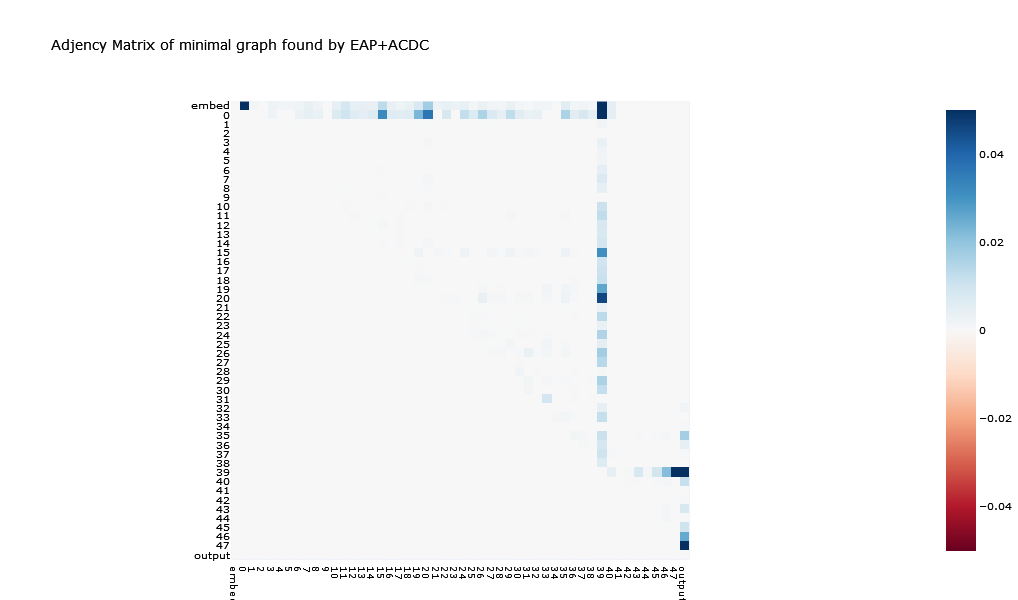

In [47]:
    
adjacency_matrix = torch.zeros([model.cfg.n_layers+2,model.cfg.n_layers+2])
nodes = [INPUT_NODE] + [layer_node(layer) for layer in range(model.cfg.n_layers)] + [OUTPUT_NODE]
layer_names = ['embed'] + [str(i) for i in range(model.cfg.n_layers)] + ['output']
def node_to_i(node):
    return nodes.index(node)

num_edges = 0
for edge in result_edges:
    if edge.checked and not edge.patching:
        num_edges += 1
        adjacency_matrix[node_to_i(edge.input_node), node_to_i(edge.output_node)] = min(0.05,edge.score_diff_when_patched)
print(f"num edges {num_edges}")
imshow(adjacency_matrix, x=layer_names, y=layer_names, color_continuous_midpoint=0, font_size=10, title='Adjency Matrix of minimal graph found by EAP+ACDC')






In [52]:


job_name_text = "IOI attr patching phase 2.txt"

if os.path.exists(job_name_text):
    with open(job_name_text, "r") as f:
        wandb_id = f.read().strip()
    print(f"resuming from {wandb_id}")
    resume = True
else:
    wandb_id = wandb.util.generate_id()
    with open(job_name_text, "w") as f:
        f.write(wandb_id)
    print(f"starting new run {wandb_id}")
    resume = False
    
wandb_resume = None
if resume:
    try:
        most_recent_checkpoint_path, is_done = get_most_recent_checkpoint(checkpoint_dir=cfg.ckpt_directory)
        if is_done:
            print(f"run {cfg.ckpt_directory} is completed")
        else:
            print(f"resuming from checkpoint {most_recent_checkpoint_path}")
            old_cfg, edges = load_checkpoint(path=most_recent_checkpoint_path)
            cfg.iter = old_cfg.iter
            wandb_resume = 'must'
    except FileNotFoundError:
        print(f"no checkpoints available at {cfg.ckpt_directory}, starting from scratch")

cfg.ckpt_directory = wandb_id
cfg.iter = 0
class InterruptedException(Exception):
    pass

def interrupt_callback(sig_num: Any, stack_frame: Any):
    raise InterruptedException()
import signal
wandb.login()
try:
    wandb.init(
        project="mamba-acdc",
        config=cfg,
        name=job_name_text.replace(".txt", "") + f' thresh={cfg.thresh} rollback_thresh={cfg.rollback_thresh}',
        resume=wandb_resume,
        id=wandb_id,
    )
    # signal handlers (if preempted)
    signal.signal(signal.SIGINT, interrupt_callback)
    signal.signal(signal.SIGTERM, interrupt_callback)
    result_edges = run_acdc(model=model, data=data, cfg=cfg, edges=edges)
except (KeyboardInterrupt, InterruptedException):
    print("interrupted")

# reset them for another run
for edge in result_edges:
    if edge.checked and not edge.patching:
        edge.checked = False

result_edges_2 = run_acdc(model=model, data=data, cfg=cfg, edges=result_edges)
wandb.finish()

resuming from qxd30tuf
no checkpoints available at da97mk6s, starting from scratch


Problem at: /tmp/ipykernel_227813/1627976331.py 39 <module>
interrupted


NameError: name 'result_edges' is not defined

num edges 270


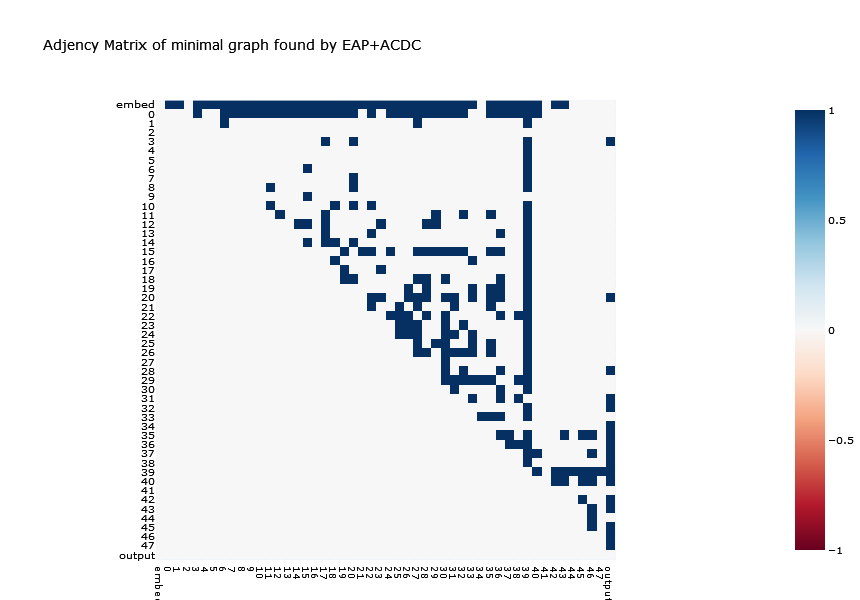

In [50]:
    
adjacency_matrix = torch.zeros([model.cfg.n_layers+2,model.cfg.n_layers+2])
nodes = [INPUT_NODE] + [layer_node(layer) for layer in range(model.cfg.n_layers)] + [OUTPUT_NODE]
layer_names = ['embed'] + [str(i) for i in range(model.cfg.n_layers)] + ['output']
def node_to_i(node):
    return nodes.index(node)

num_edges = 0
for edge in result_edges_2:
    if edge.checked and not edge.patching:
        num_edges += 1
        adjacency_matrix[node_to_i(edge.input_node), node_to_i(edge.output_node)] = 1
print(f"num edges {num_edges}")
imshow(adjacency_matrix, x=layer_names, y=layer_names, color_continuous_midpoint=0, font_size=10, title='Adjency Matrix of minimal graph found by EAP+ACDC')






starting new run ut2w30i2


all nodes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '5', '6', '7', '8', '9', 'input', 'output']
patching 959 edges, keeping 1 edges, 265 remain
patching 959 edges, keeping 1 edges, 265 remain
baseline score 0.8539336919784546
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8524], device='cuda:0')
keeping edge edge  32 -> output (('blocks.32.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.47.hook_resid_post', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8523723483085632 which has diff 0.0015613436698913574 > 0.0001
patching 959 edges, keeping 2 edges, 264 remain
baseline score 0.8539336919784546
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8528], device='cuda

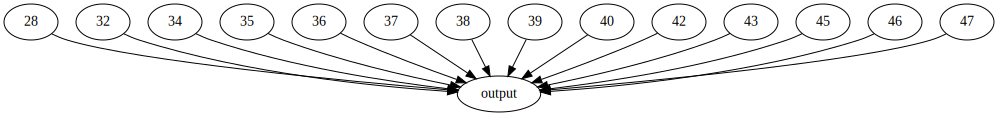

saved to checkpoint ut2w30i2/checkpoint 0.pkl
patching 959 edges, keeping 14 edges, 252 remain
patching 959 edges, keeping 14 edges, 252 remain
baseline score 0.8539336919784546
[1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8531], device='cuda:0')
keeping edge edge  35 -> 46 (('blocks.35.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.46.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8530993461608887 which has diff 0.000834345817565918 > 0.0001
patching 959 edges, keeping 15 edges, 251 remain
baseline score 0.8539336919784546
[1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8321], device='cuda:0')
keeping edge edge  39 -> 46 (('blocks.39.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.46.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8321119546890259 which has diff 0.02182173728942871 > 0.0001
patching 959 edges, keeping 16 edge

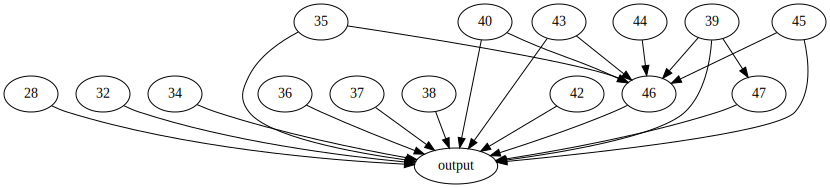

saved to checkpoint ut2w30i2/checkpoint 1.pkl
patching 959 edges, keeping 21 edges, 245 remain
patching 959 edges, keeping 21 edges, 245 remain
baseline score 0.8539336919784546
[1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8538], device='cuda:0')
keeping edge edge  input -> 43 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.43.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8538326621055603 which has diff 0.00010102987289428711 > 0.0001
patching 959 edges, keeping 22 edges, 244 remain
baseline score 0.8539336919784546
[1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8535], device='cuda:0')
keeping edge edge  35 -> 43 (('blocks.35.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.43.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8535189628601074 which has diff 0.00041472911834716797 > 0.0001
patching 959 edges, keeping 

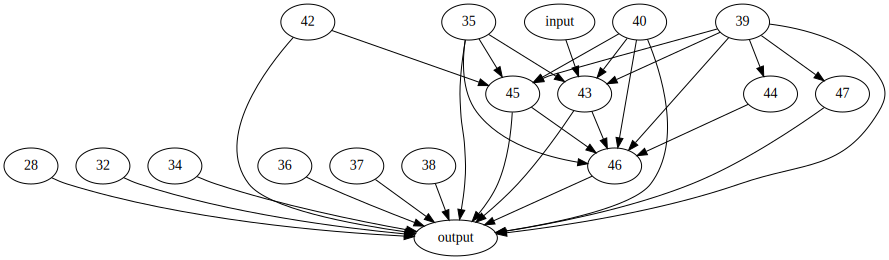

saved to checkpoint ut2w30i2/checkpoint 2.pkl
patching 959 edges, keeping 30 edges, 236 remain
patching 959 edges, keeping 30 edges, 236 remain
baseline score 0.8539336919784546
[1, 1, 1] sized edge sets remaining
got scores tensor([0.8539], device='cuda:0')
patching 1 edges with score 0.8538790941238403 with diff of 5.459785461425781e-05
patching 960 edges, keeping 30 edges, 235 remain
baseline score 0.8538790941238403
[1, 1] sized edge sets remaining
got scores tensor([0.8534], device='cuda:0')
keeping edge edge  39 -> 42 (('blocks.39.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.42.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.853421688079834 which has diff 0.00045740604400634766 > 0.0001
patching 960 edges, keeping 31 edges, 234 remain
baseline score 0.8538790941238403
[1] sized edge sets remaining
got scores tensor([0.8536], device='cuda:0')
keeping edge edge  40 -> 42 (('blocks.40.hook_out_proj', <function storage_hoo

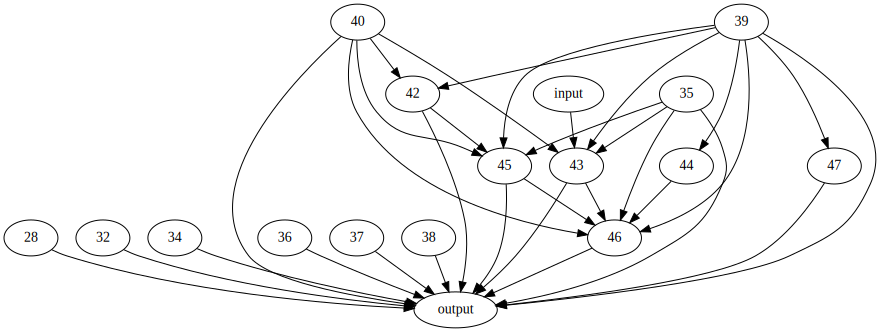

saved to checkpoint ut2w30i2/checkpoint 3.pkl
patching 960 edges, keeping 32 edges, 233 remain
patching 960 edges, keeping 32 edges, 233 remain
baseline score 0.8538790941238403
[1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8491], device='cuda:0')
keeping edge edge  input -> 40 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.40.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8490759134292603 which has diff 0.004803180694580078 > 0.0001
patching 960 edges, keeping 33 edges, 232 remain
baseline score 0.8538790941238403
[1, 1, 1] sized edge sets remaining
got scores tensor([0.8488], device='cuda:0')
keeping edge edge  0 -> 40 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.40.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8488306999206543 which has diff 0.005048394203186035 > 0.0001
patching 960 edges, keeping 34 edges, 231 remain
baseline score 

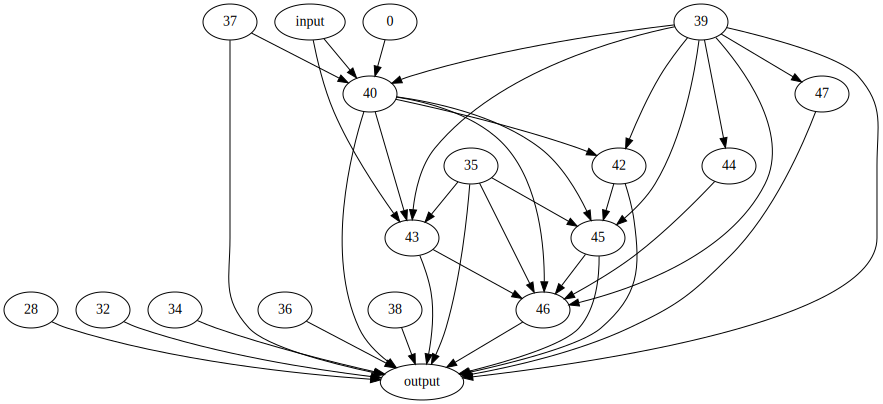

saved to checkpoint ut2w30i2/checkpoint 4.pkl
patching 960 edges, keeping 36 edges, 229 remain
patching 960 edges, keeping 36 edges, 229 remain
baseline score 0.8538790941238403
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.7453], device='cuda:0')
keeping edge edge  input -> 39 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.39.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.7452870011329651 which has diff 0.10859209299087524 > 0.0001
patching 960 edges, keeping 37 edges, 228 remain
baseline score 0.8538790941238403
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.4928], device='cuda:0')
keeping edge edge  0 -> 39 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.39.hook_layer_input', 

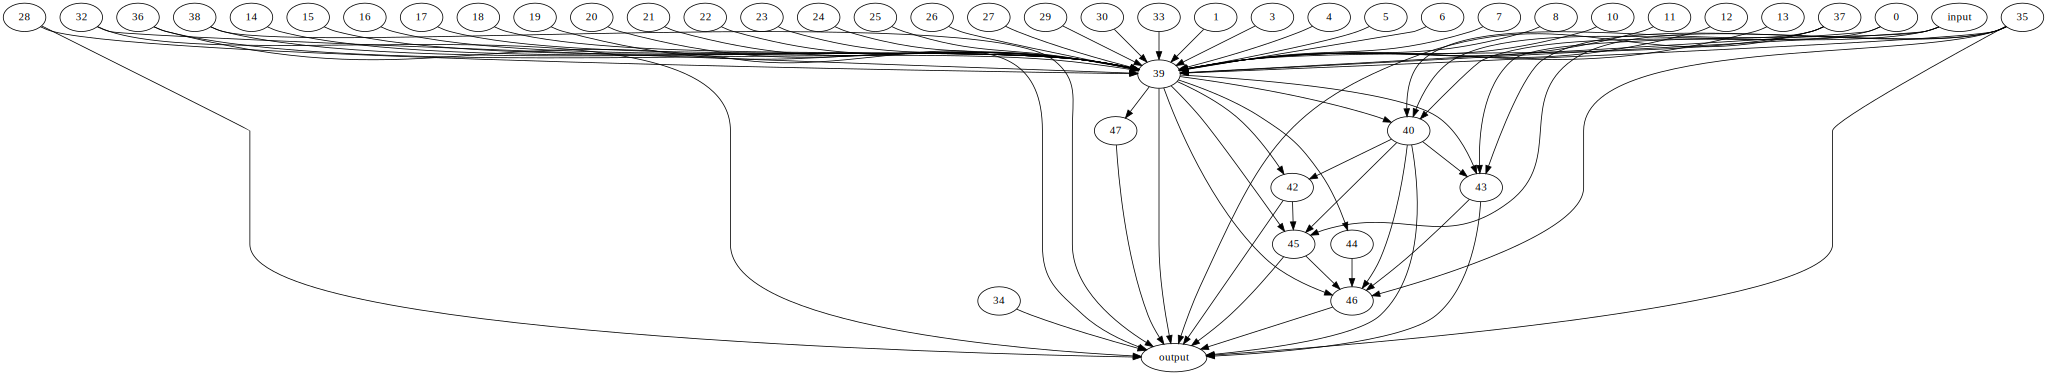

saved to checkpoint ut2w30i2/checkpoint 5.pkl
patching 960 edges, keeping 72 edges, 193 remain
patching 960 edges, keeping 72 edges, 193 remain
baseline score 0.8538790941238403
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8520], device='cuda:0')
keeping edge edge  input -> 37 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.37.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8520107865333557 which has diff 0.0018683075904846191 > 0.0001
patching 960 edges, keeping 73 edges, 192 remain
baseline score 0.8538790941238403
[1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8453], device='cuda:0')
keeping edge edge  0 -> 37 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.37.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8452807664871216 which has diff 0.00859832763671875 > 0.0001
patching 960 edges, keeping 

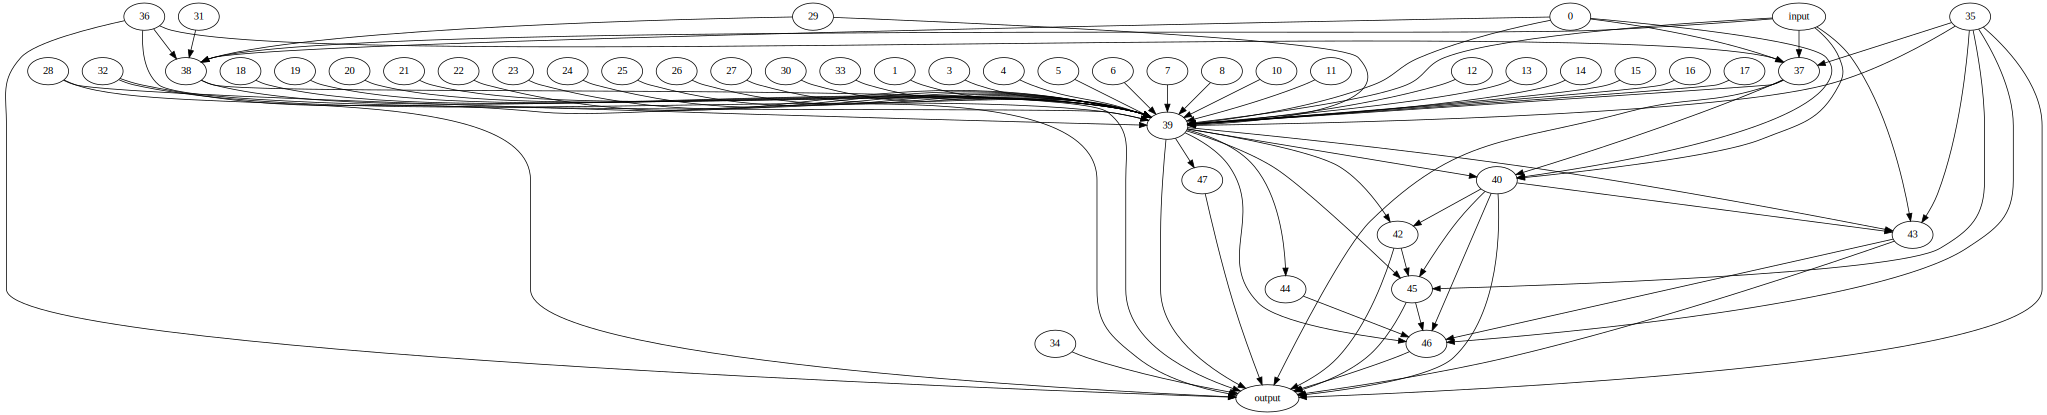

saved to checkpoint ut2w30i2/checkpoint 6.pkl
patching 961 edges, keeping 81 edges, 183 remain
patching 961 edges, keeping 81 edges, 183 remain
baseline score 0.8538023233413696
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8525], device='cuda:0')
keeping edge edge  input -> 36 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.36.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8524729609489441 which has diff 0.0013293623924255371 > 0.0001
patching 961 edges, keeping 82 edges, 182 remain
baseline score 0.8538023233413696
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8481], device='cuda:0')
keeping edge edge  0 -> 36 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.36.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8481469750404358 which has diff 0.005655348300933838 > 0.0001
patching 

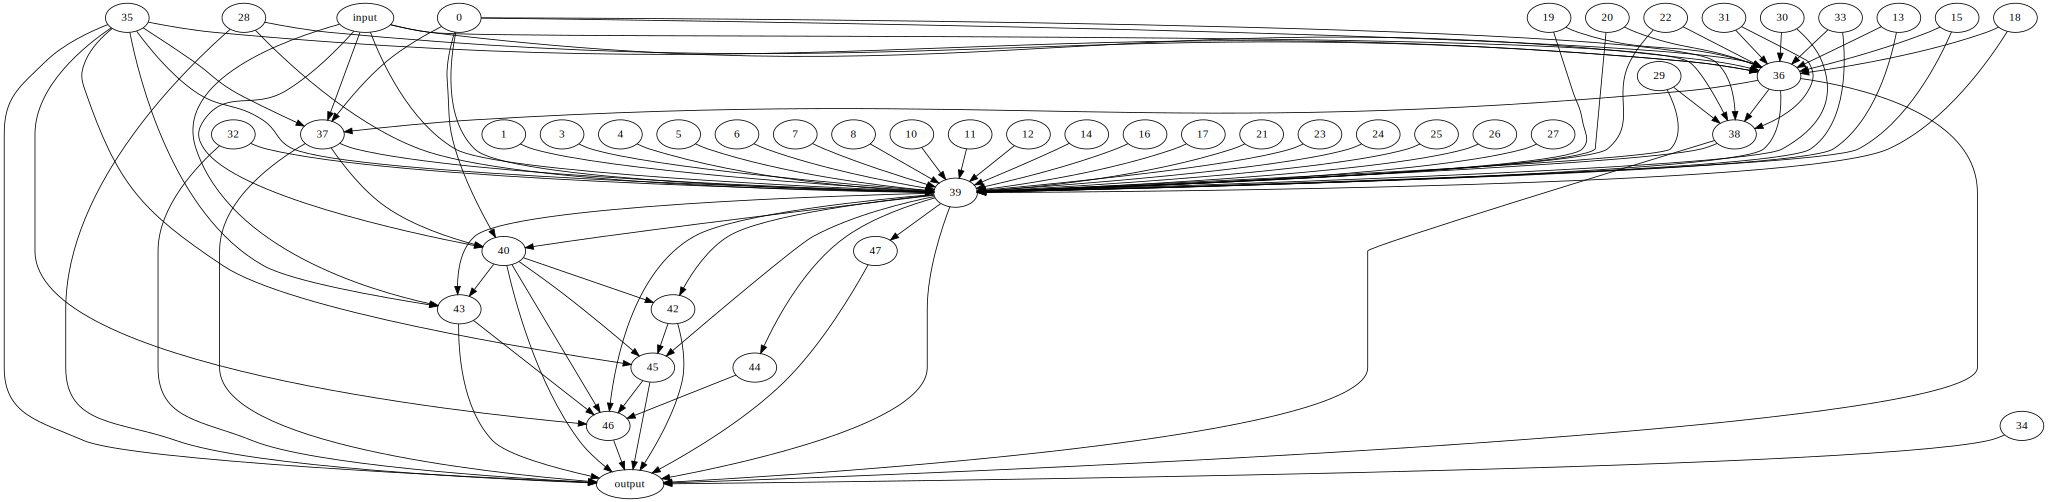

saved to checkpoint ut2w30i2/checkpoint 7.pkl
patching 961 edges, keeping 94 edges, 170 remain
patching 961 edges, keeping 94 edges, 170 remain
baseline score 0.8538023233413696
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8537], device='cuda:0')
keeping edge edge  29 -> 34 (('blocks.29.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.34.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8536565899848938 which has diff 0.00014573335647583008 > 0.0001
patching 961 edges, keeping 95 edges, 169 remain
baseline score 0.8538023233413696
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8528], device='cuda:0')
keeping edge edge  33 -> 34 (('blocks.33.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.34.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8528451323509216 which has diff 0.000957190990447998 > 0.0

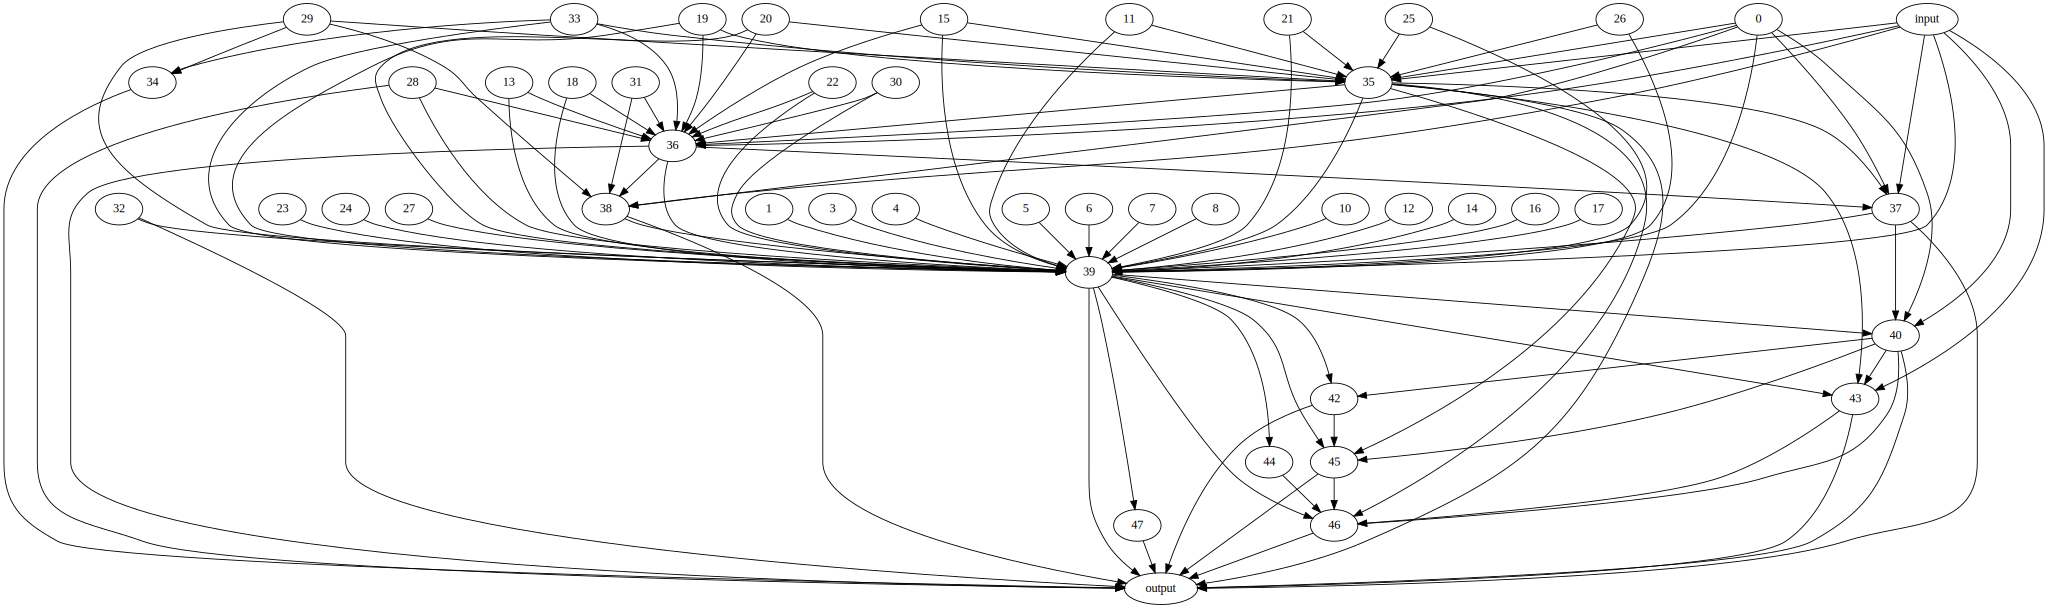

saved to checkpoint ut2w30i2/checkpoint 8.pkl
patching 961 edges, keeping 107 edges, 157 remain
patching 961 edges, keeping 107 edges, 157 remain
baseline score 0.8538023233413696
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8525], device='cuda:0')
keeping edge edge  input -> 32 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.32.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8525335788726807 which has diff 0.0012687444686889648 > 0.0001
patching 961 edges, keeping 108 edges, 156 remain
baseline score 0.8538023233413696
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8506], device='cuda:0')
keeping edge edge  0 -> 32 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.32.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8506377935409546 which has diff 0.0031645298

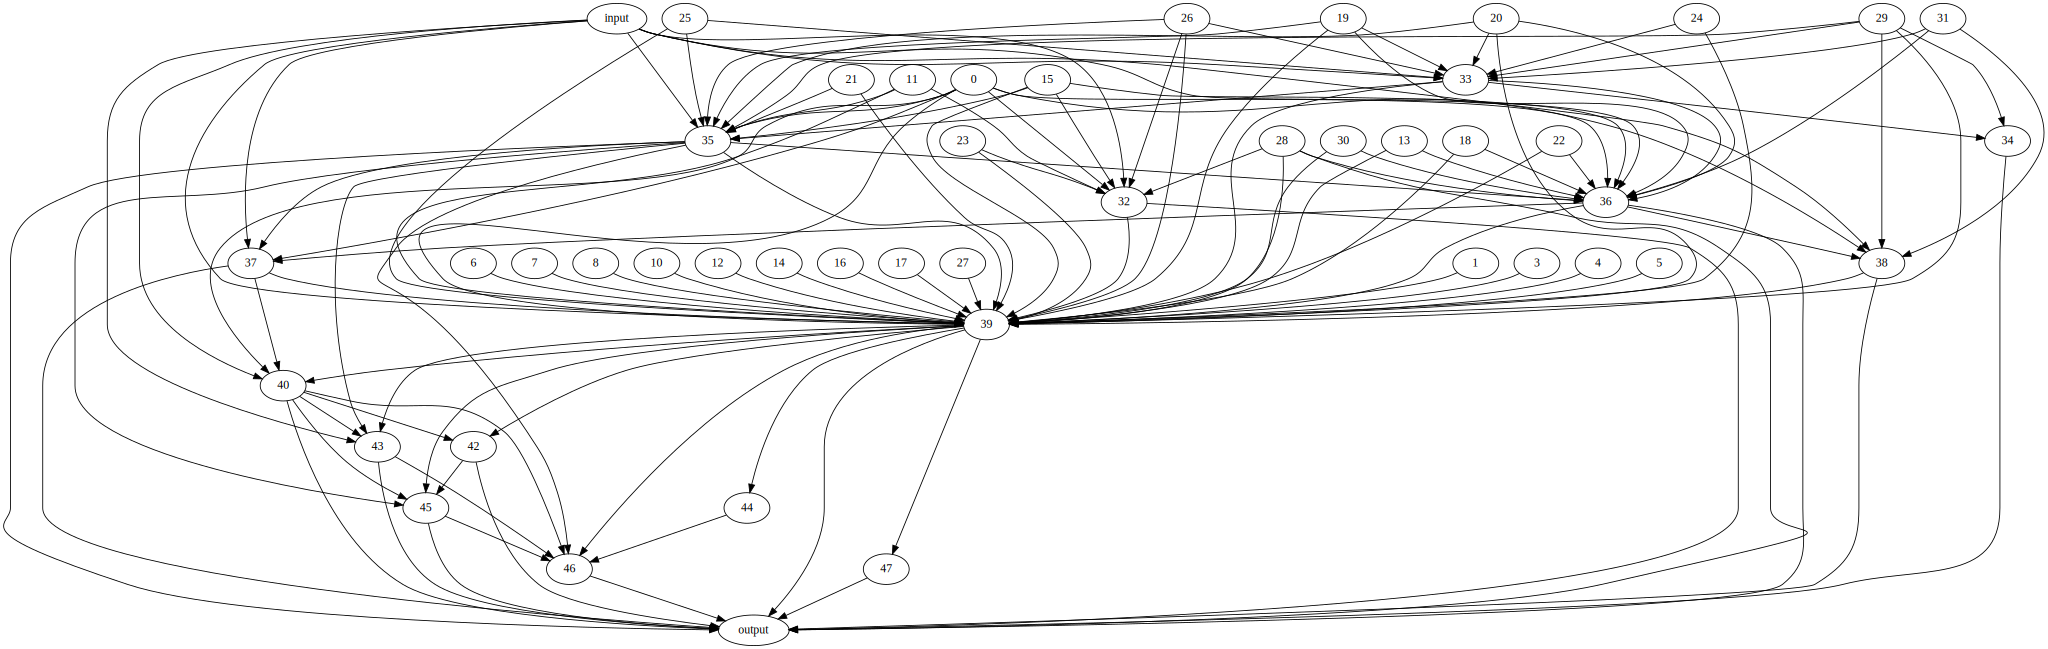

saved to checkpoint ut2w30i2/checkpoint 9.pkl
patching 963 edges, keeping 122 edges, 140 remain
patching 963 edges, keeping 122 edges, 140 remain
baseline score 0.8536489605903625
[1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8531], device='cuda:0')
keeping edge edge  input -> 31 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.31.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8531105518341064 which has diff 0.0005384087562561035 > 0.0001
patching 963 edges, keeping 123 edges, 139 remain
baseline score 0.8536489605903625
[1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8502], device='cuda:0')
keeping edge edge  0 -> 31 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.31.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8501865863800049 which has diff 0.003462374210357666 > 0.0001
patching 963 edges, keeping 12

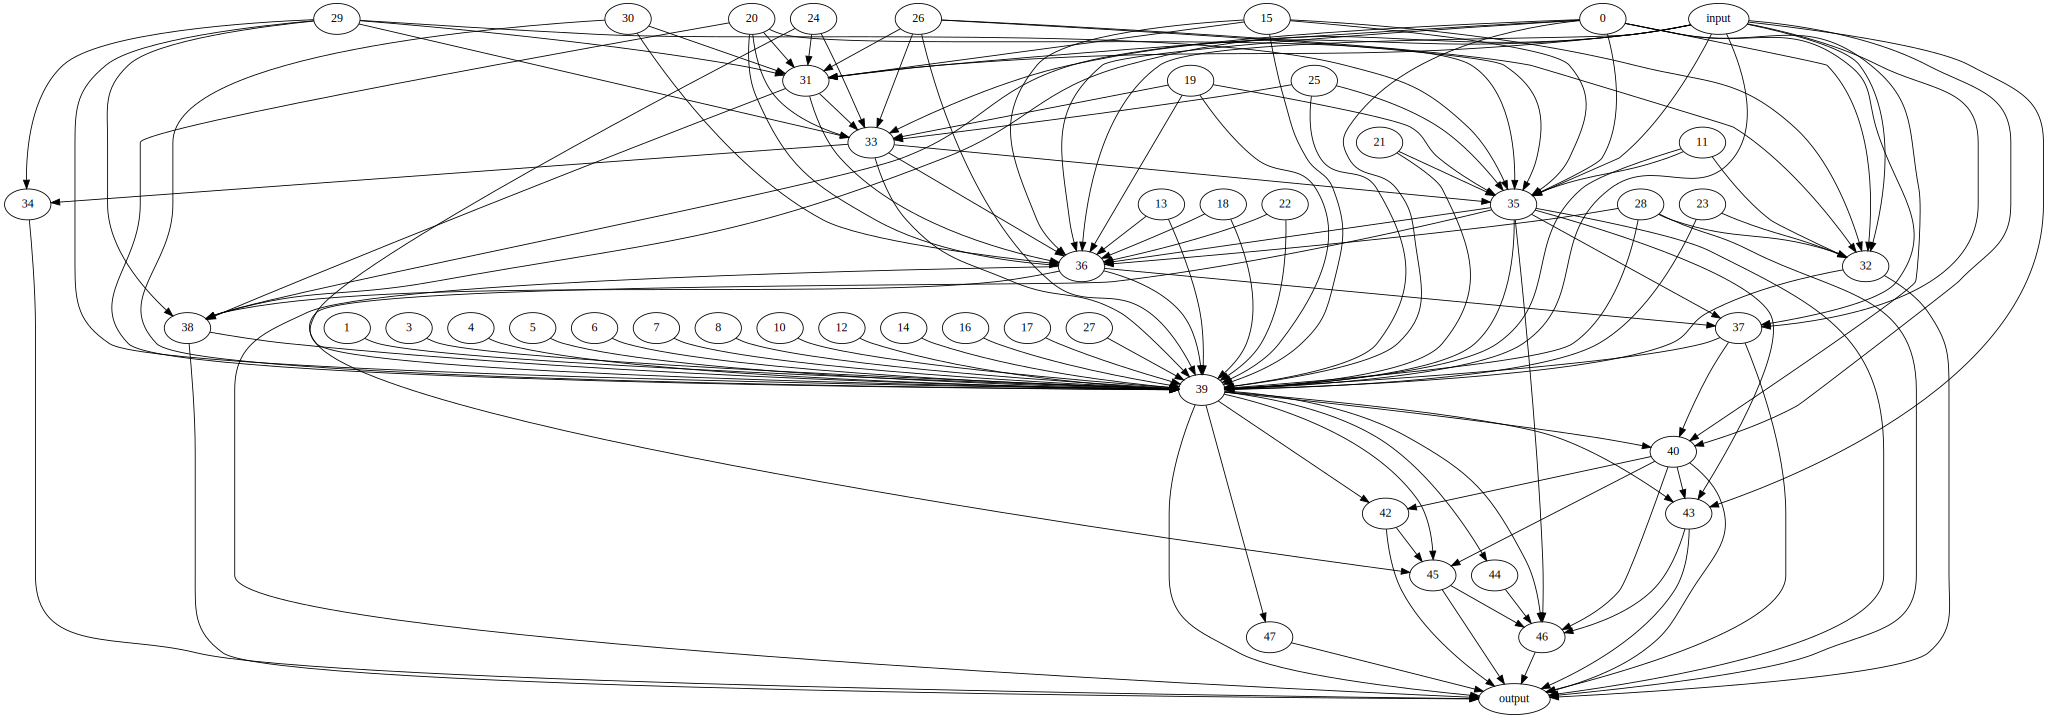

saved to checkpoint ut2w30i2/checkpoint 10.pkl
patching 964 edges, keeping 130 edges, 131 remain
patching 964 edges, keeping 130 edges, 131 remain
baseline score 0.8535865545272827
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8521], device='cuda:0')
keeping edge edge  input -> 30 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.30.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8521378040313721 which has diff 0.0014487504959106445 > 0.0001
patching 964 edges, keeping 131 edges, 130 remain
baseline score 0.8535865545272827
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8477], device='cuda:0')
keeping edge edge  0 -> 30 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.30.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8476529717445374 which has diff 0.005933582782745361 > 0.0001
patch

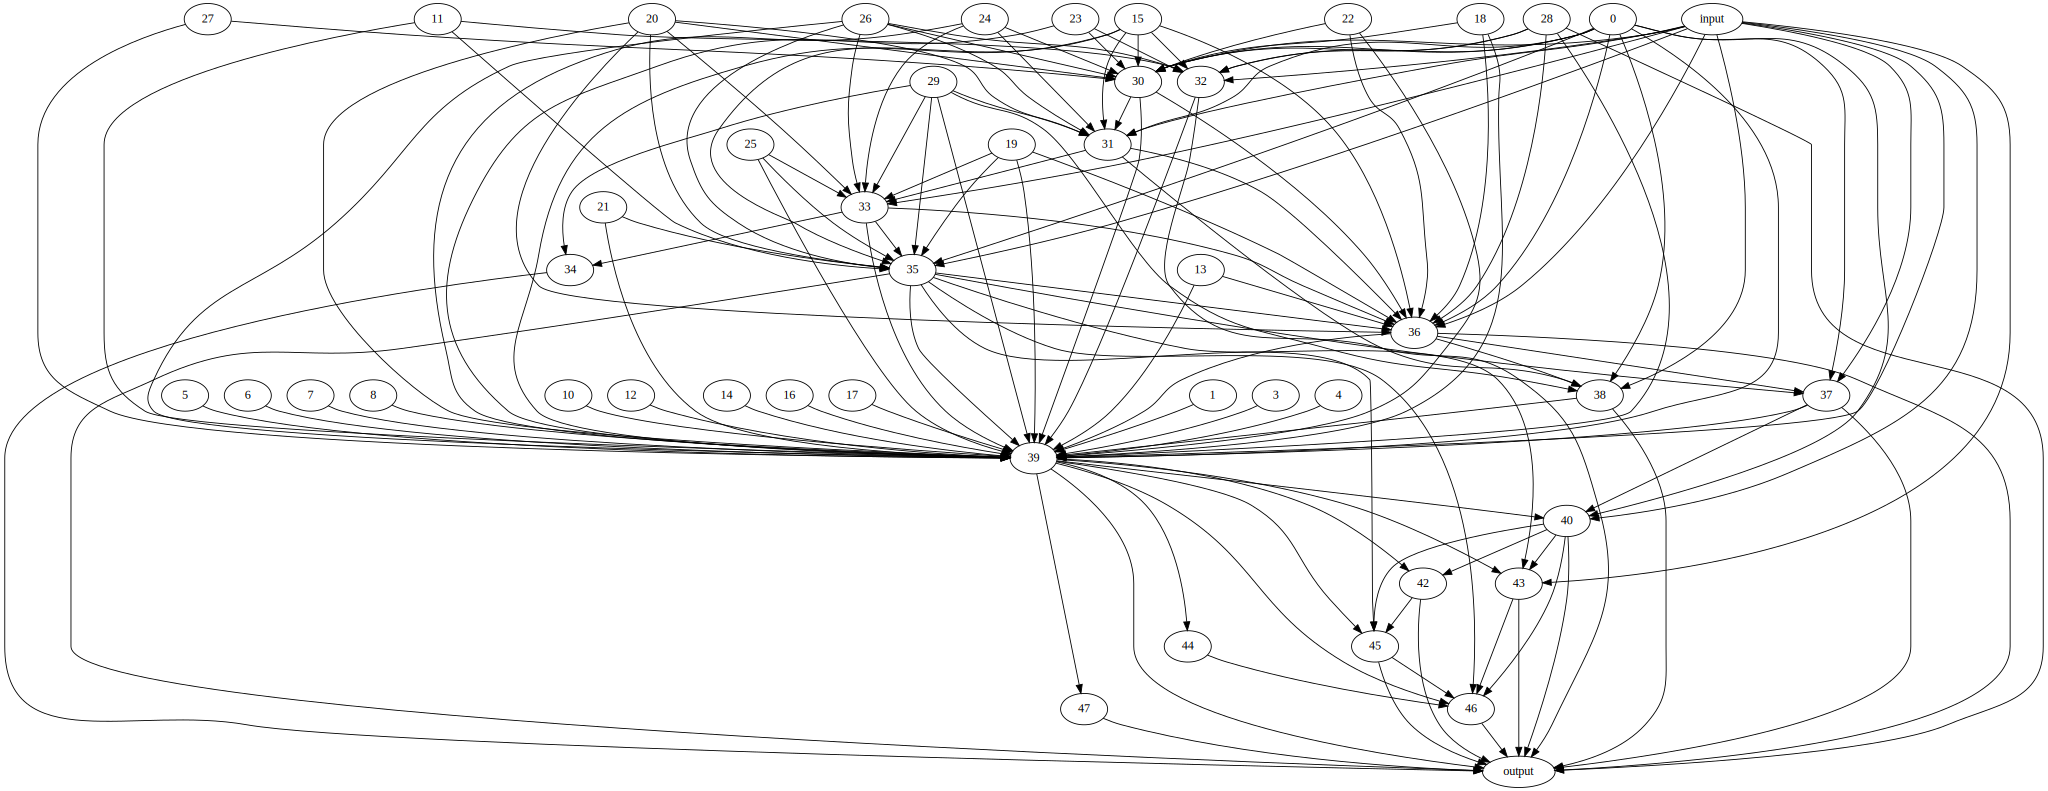

saved to checkpoint ut2w30i2/checkpoint 11.pkl
patching 966 edges, keeping 141 edges, 118 remain
patching 966 edges, keeping 141 edges, 118 remain
baseline score 0.853479266166687
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8515], device='cuda:0')
keeping edge edge  input -> 27 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.27.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8515049815177917 which has diff 0.0019742846488952637 > 0.0001
patching 966 edges, keeping 142 edges, 117 remain
baseline score 0.853479266166687
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8458], device='cuda:0')
keeping edge edge  0 -> 27 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.27.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with

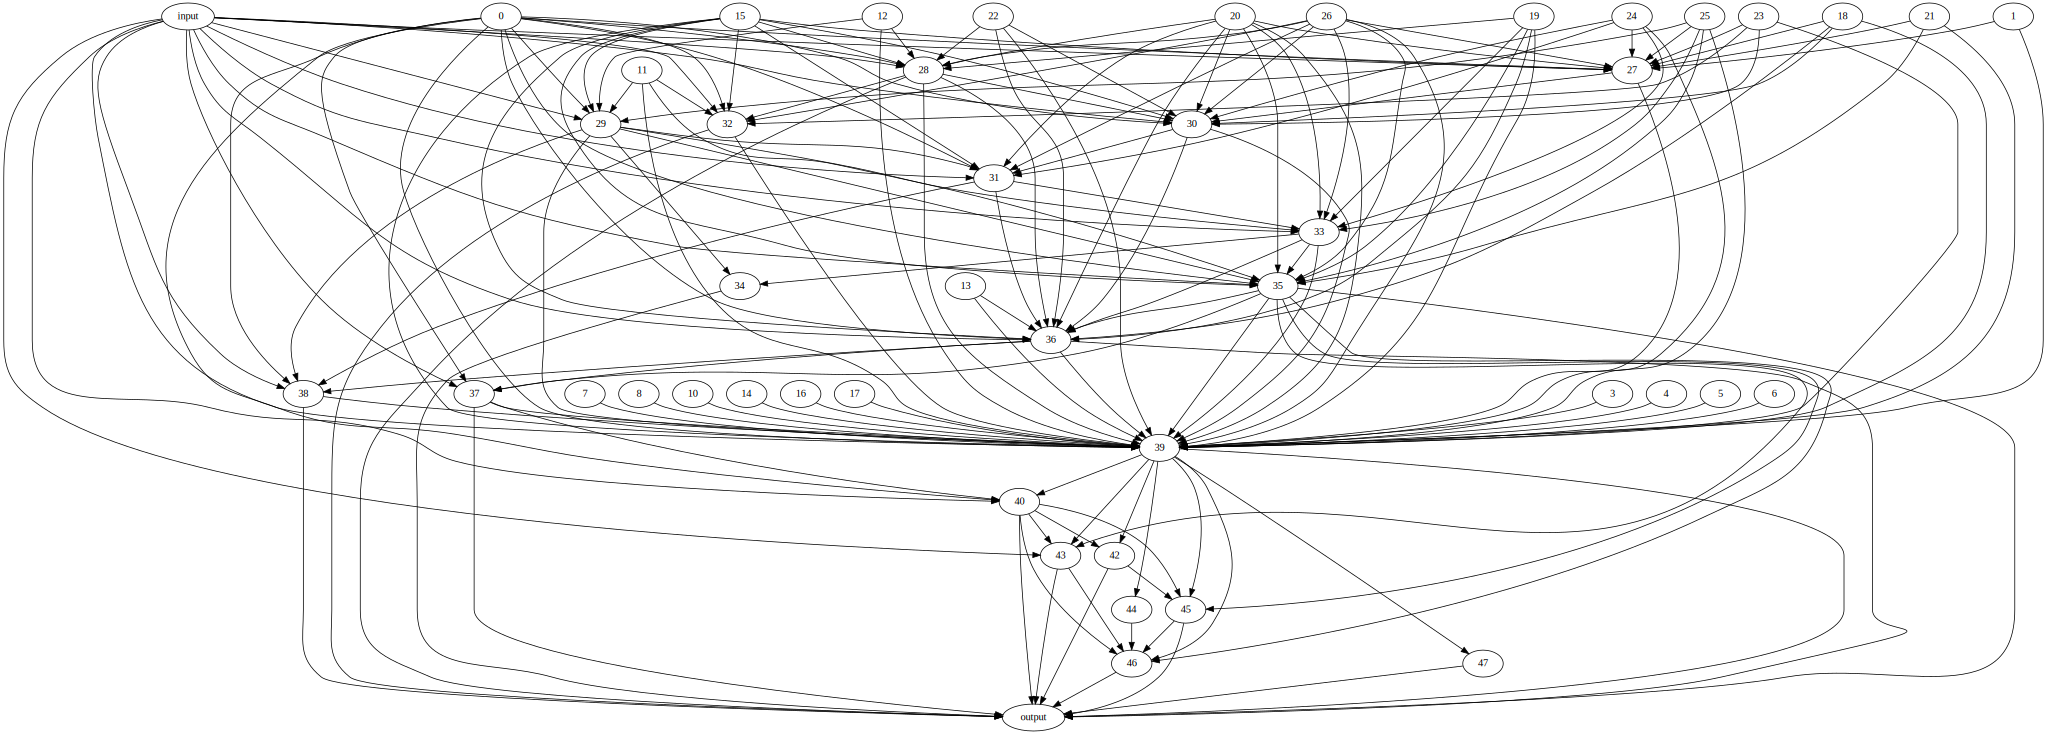

saved to checkpoint ut2w30i2/checkpoint 12.pkl
patching 967 edges, keeping 166 edges, 92 remain
patching 967 edges, keeping 166 edges, 92 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8521], device='cuda:0')
keeping edge edge  input -> 25 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.25.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8521310091018677 which has diff 0.0012576580047607422 > 0.0001
patching 967 edges, keeping 167 edges, 91 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8465], device='cuda:0')
keeping edge edge  0 -> 25 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.25.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8464881181716919 which has diff 0.0069005489349365234 > 0.0001
patchin

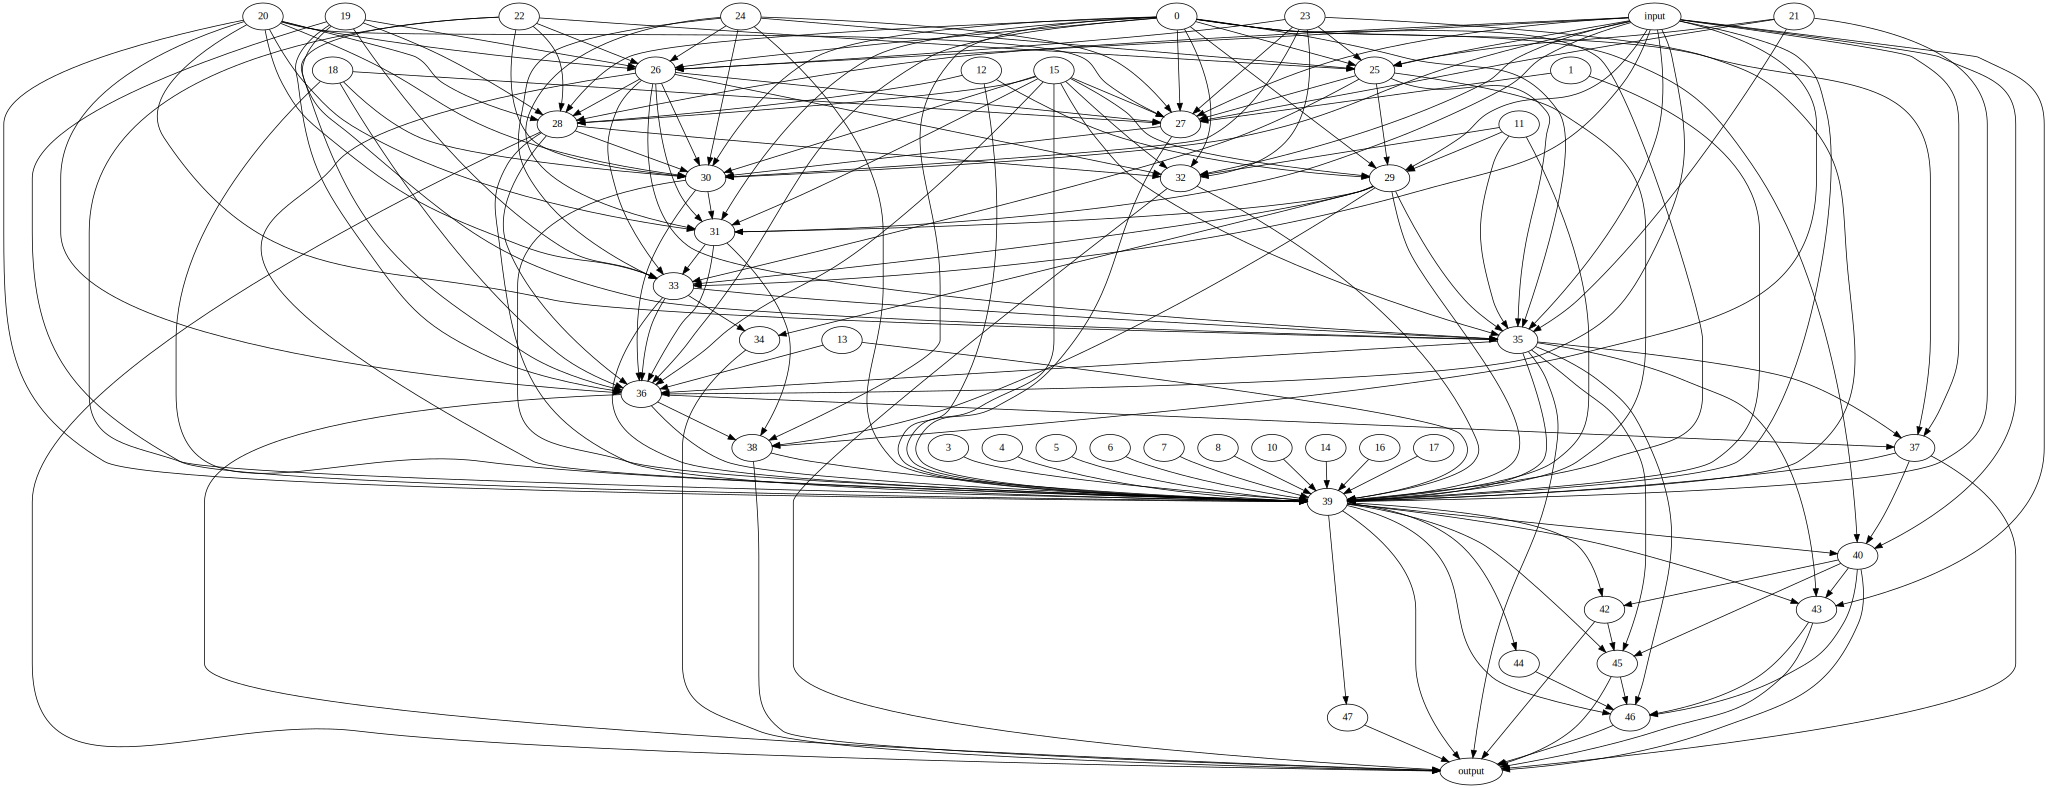

saved to checkpoint ut2w30i2/checkpoint 13.pkl
patching 967 edges, keeping 179 edges, 79 remain
patching 967 edges, keeping 179 edges, 79 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8502], device='cuda:0')
keeping edge edge  input -> 23 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.23.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8501508831977844 which has diff 0.003237783908843994 > 0.0001
patching 967 edges, keeping 180 edges, 78 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8528], device='cuda:0')
keeping edge edge  12 -> 23 (('blocks.12.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.23.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8527839183807373 which has diff 0.0006047487258911133 > 0.0001
patching 967 edges, keeping 181 edge

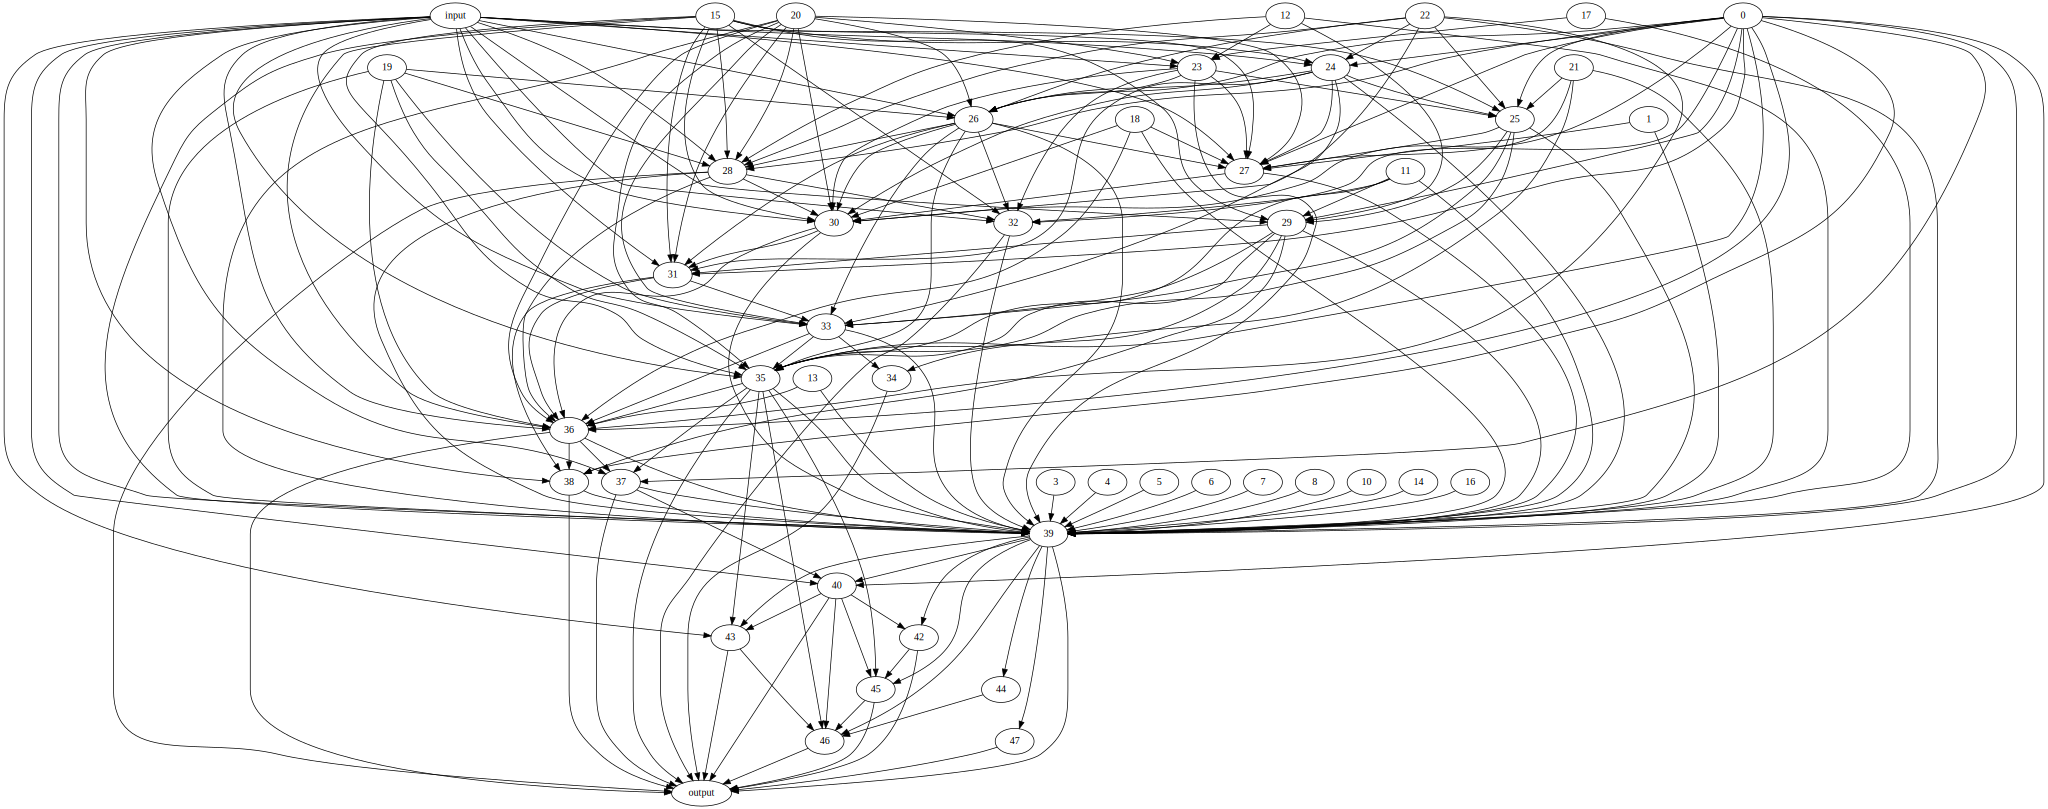

saved to checkpoint ut2w30i2/checkpoint 14.pkl
patching 967 edges, keeping 187 edges, 71 remain
patching 967 edges, keeping 187 edges, 71 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8492], device='cuda:0')
keeping edge edge  input -> 22 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.22.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8492206931114197 which has diff 0.00416797399520874 > 0.0001
patching 967 edges, keeping 188 edges, 70 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8448], device='cuda:0')
keeping edge edge  0 -> 22 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.22.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8448150157928467 which has diff 0.008573651313781738 > 0.0001
patching 967 edges, keeping 189 edges, 69 rema

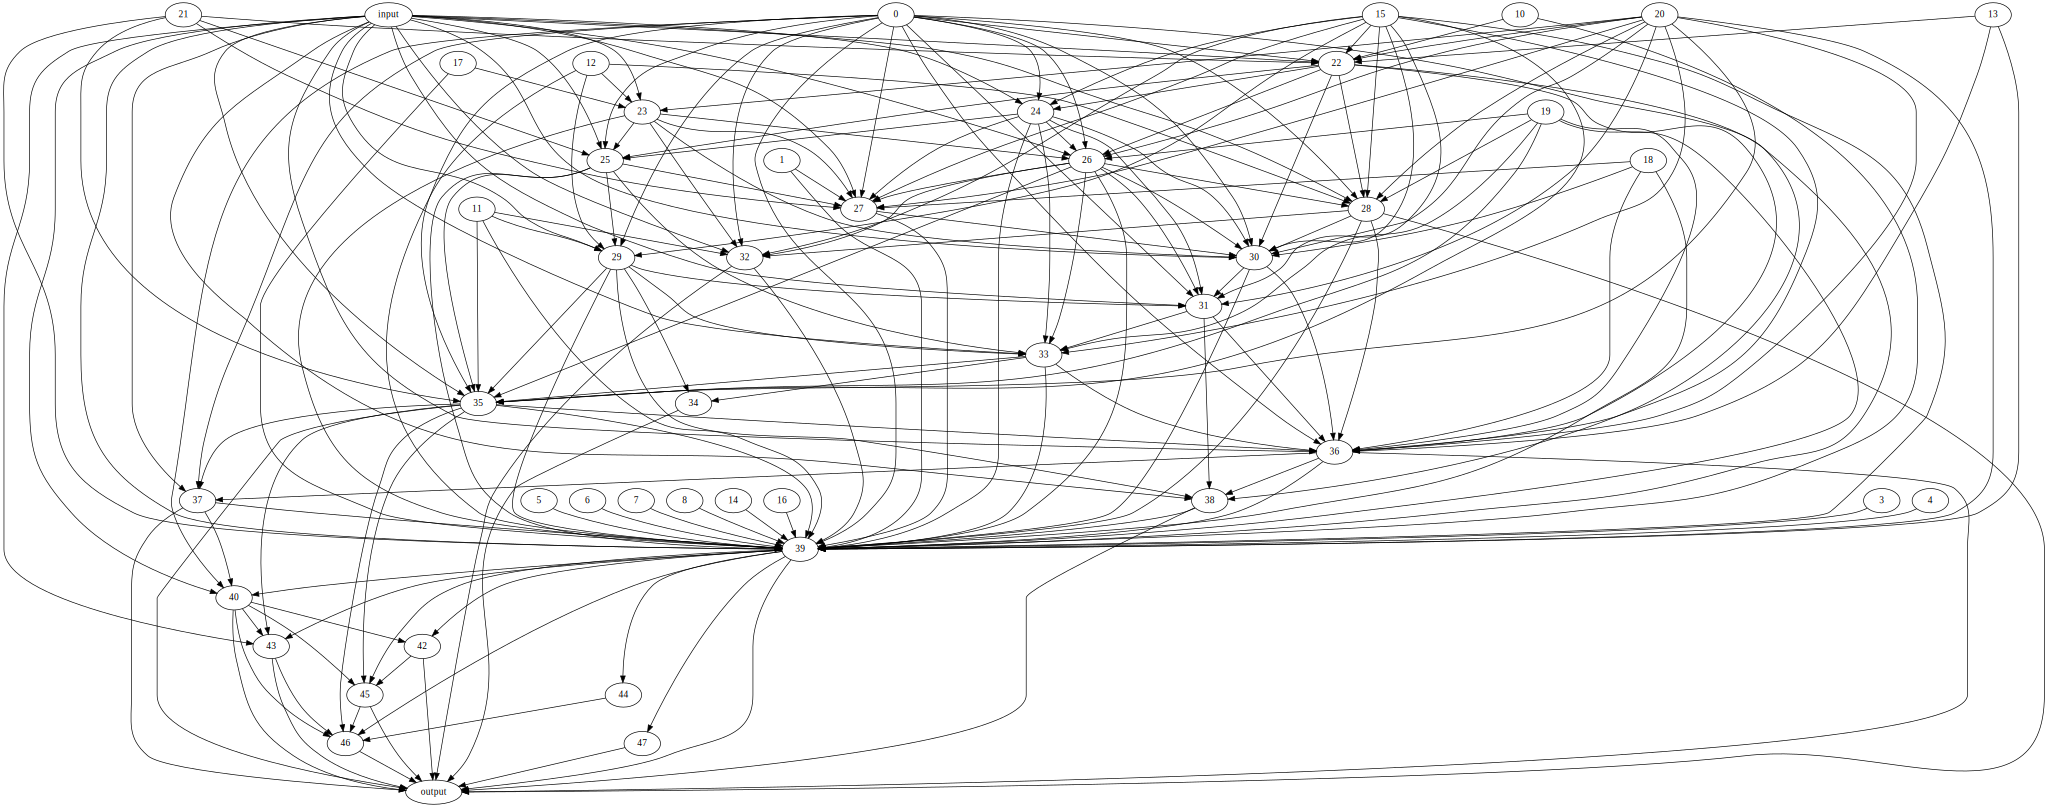

saved to checkpoint ut2w30i2/checkpoint 15.pkl
patching 967 edges, keeping 194 edges, 64 remain
patching 967 edges, keeping 194 edges, 64 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8454], device='cuda:0')
keeping edge edge  input -> 19 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.19.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8453577160835266 which has diff 0.008030951023101807 > 0.0001
patching 967 edges, keeping 195 edges, 63 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8299], device='cuda:0')
keeping edge edge  0 -> 19 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.19.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8299111127853394 which has diff 0.023477554321289062 > 0.00

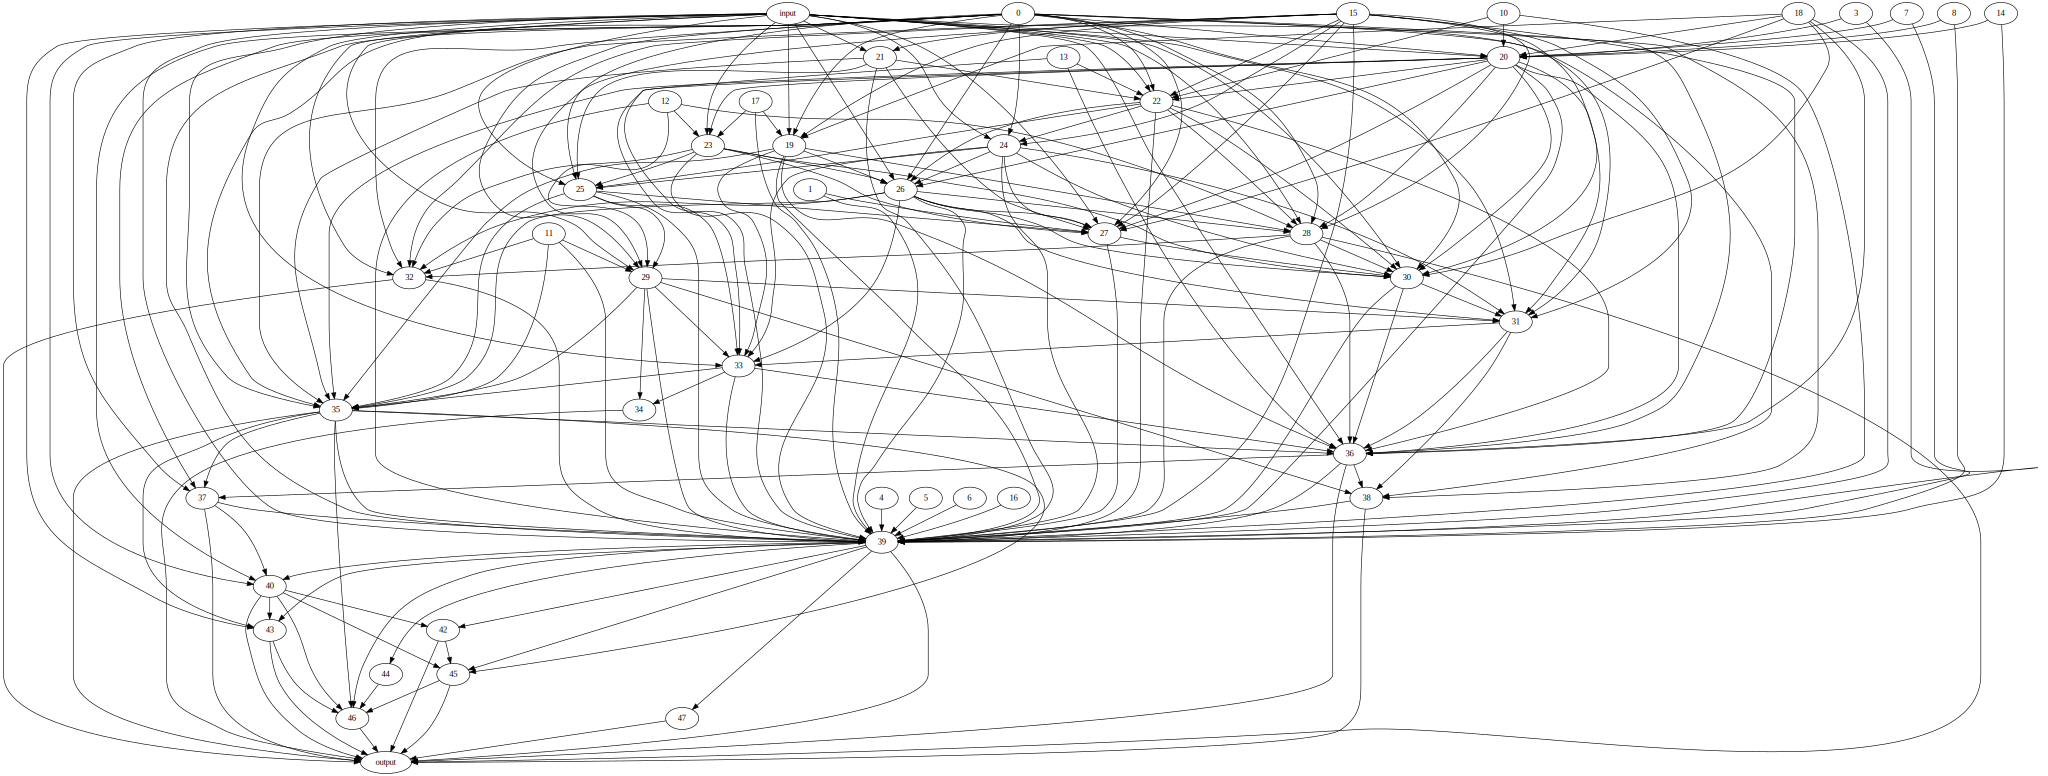

saved to checkpoint ut2w30i2/checkpoint 16.pkl
patching 967 edges, keeping 209 edges, 49 remain
patching 967 edges, keeping 209 edges, 49 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8511], device='cuda:0')
keeping edge edge  input -> 17 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.17.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8510920405387878 which has diff 0.002296626567840576 > 0.0001
patching 967 edges, keeping 210 edges, 48 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8474], device='cuda:0')
keeping edge edge  0 -> 17 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.17.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8473986387252808 which has diff 0.005990028381347656 > 0.0001
patching 967 ed

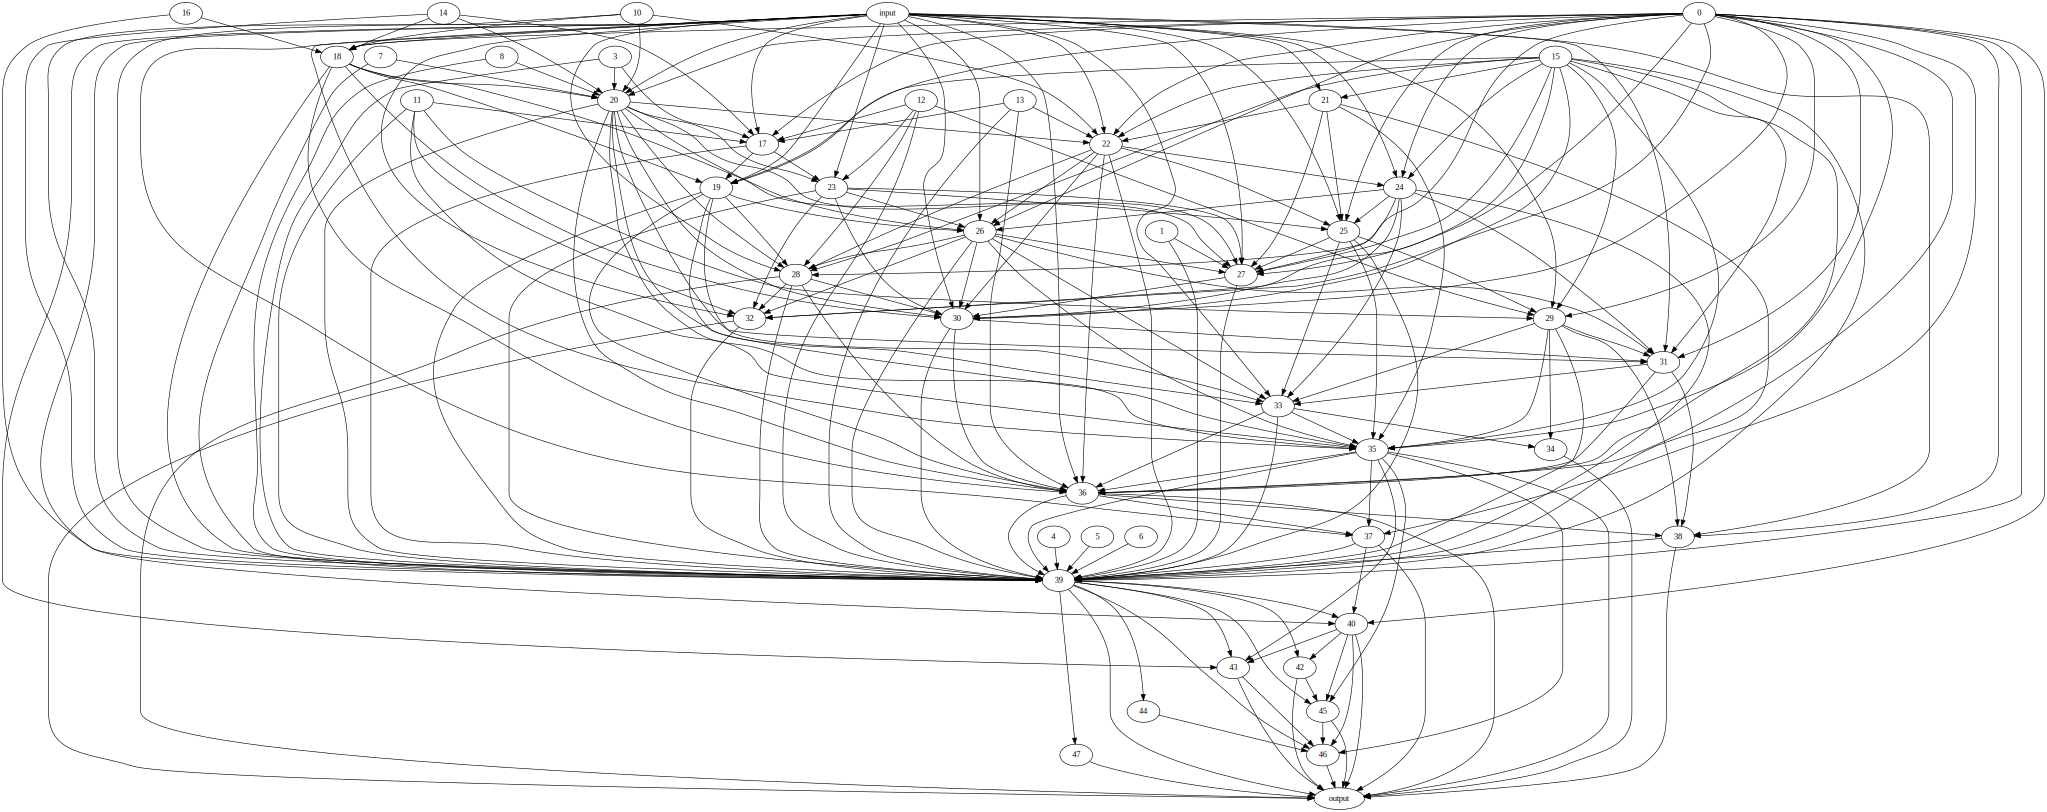

saved to checkpoint ut2w30i2/checkpoint 17.pkl
patching 967 edges, keeping 221 edges, 37 remain
patching 967 edges, keeping 221 edges, 37 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8390], device='cuda:0')
keeping edge edge  input -> 15 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.15.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8390284776687622 which has diff 0.014360189437866211 > 0.0001
patching 967 edges, keeping 222 edges, 36 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8199], device='cuda:0')
keeping edge edge  0 -> 15 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.15.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8199267387390137 which has diff 0.033461928367614746 > 0.0001
patching 967 edges, keeping 223 edges, 

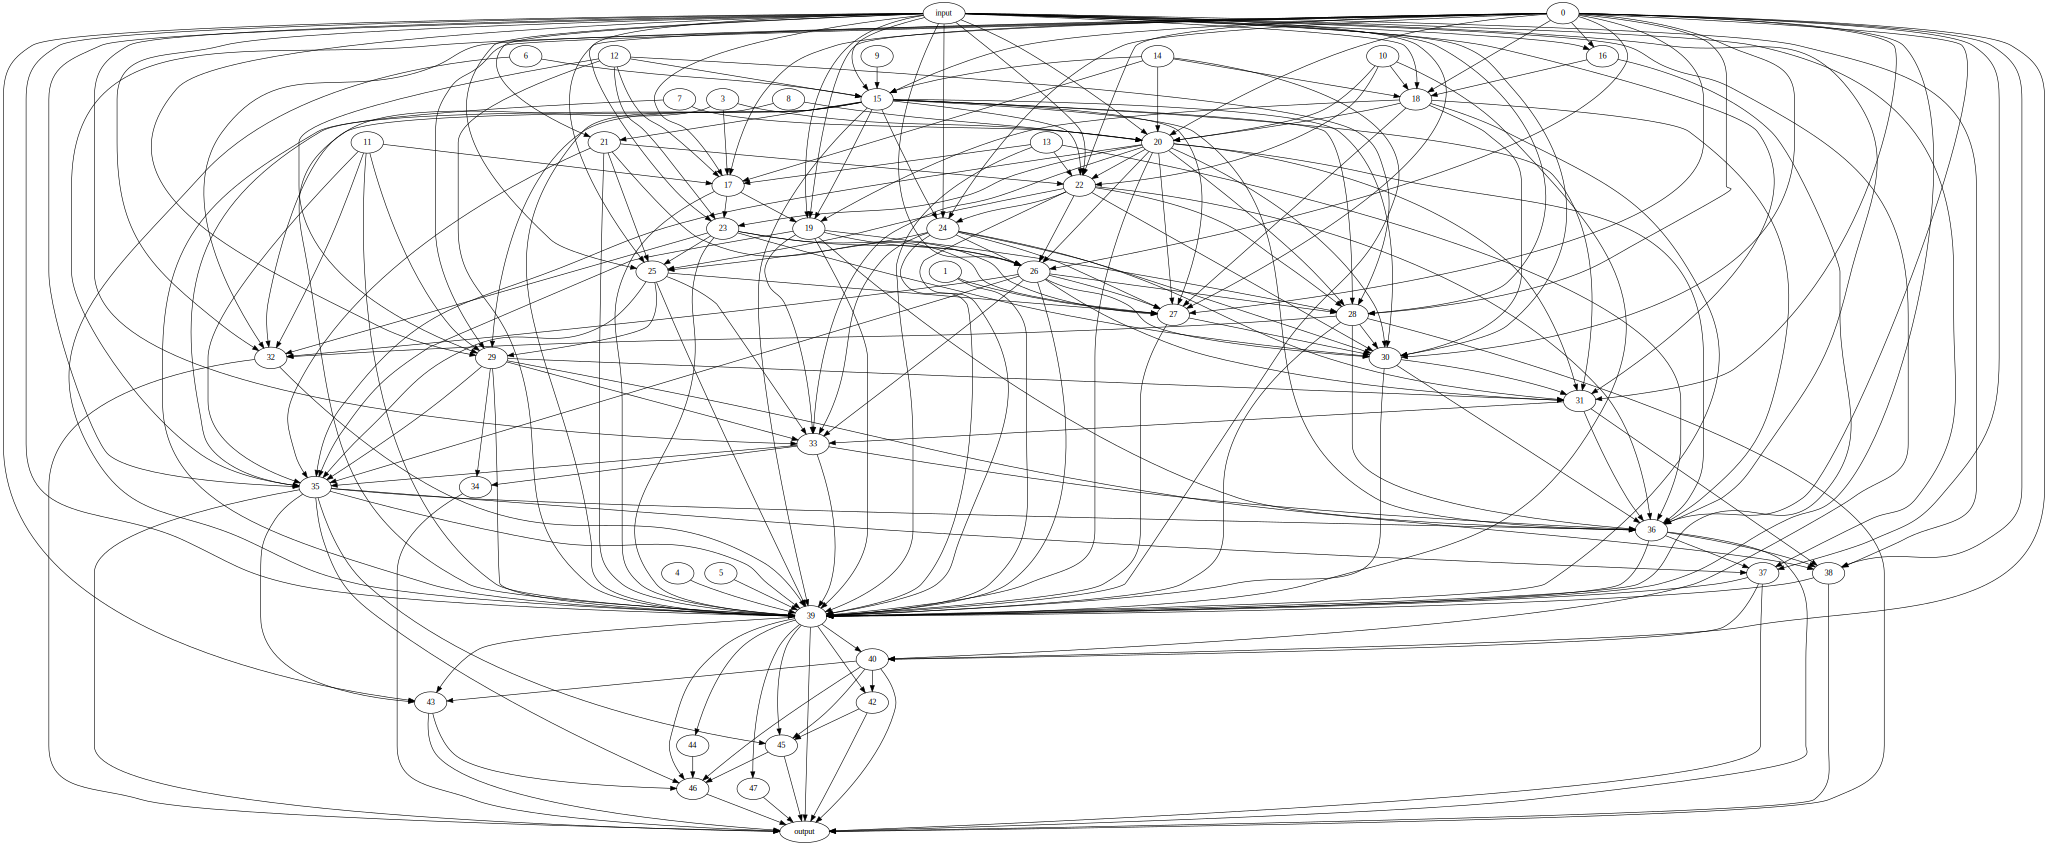

saved to checkpoint ut2w30i2/checkpoint 18.pkl
patching 967 edges, keeping 229 edges, 29 remain
patching 967 edges, keeping 229 edges, 29 remain
baseline score 0.8533886671066284
[1, 1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8490], device='cuda:0')
keeping edge edge  input -> 13 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.13.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8490012884140015 which has diff 0.004387378692626953 > 0.0001
patching 967 edges, keeping 230 edges, 28 remain
baseline score 0.8533886671066284
[1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8486], device='cuda:0')
keeping edge edge  0 -> 13 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.13.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8486301302909851 which has diff 0.0047585368156433105 > 0.0001
patching 967 edges, keeping 231 edges, 27 remain
baselin

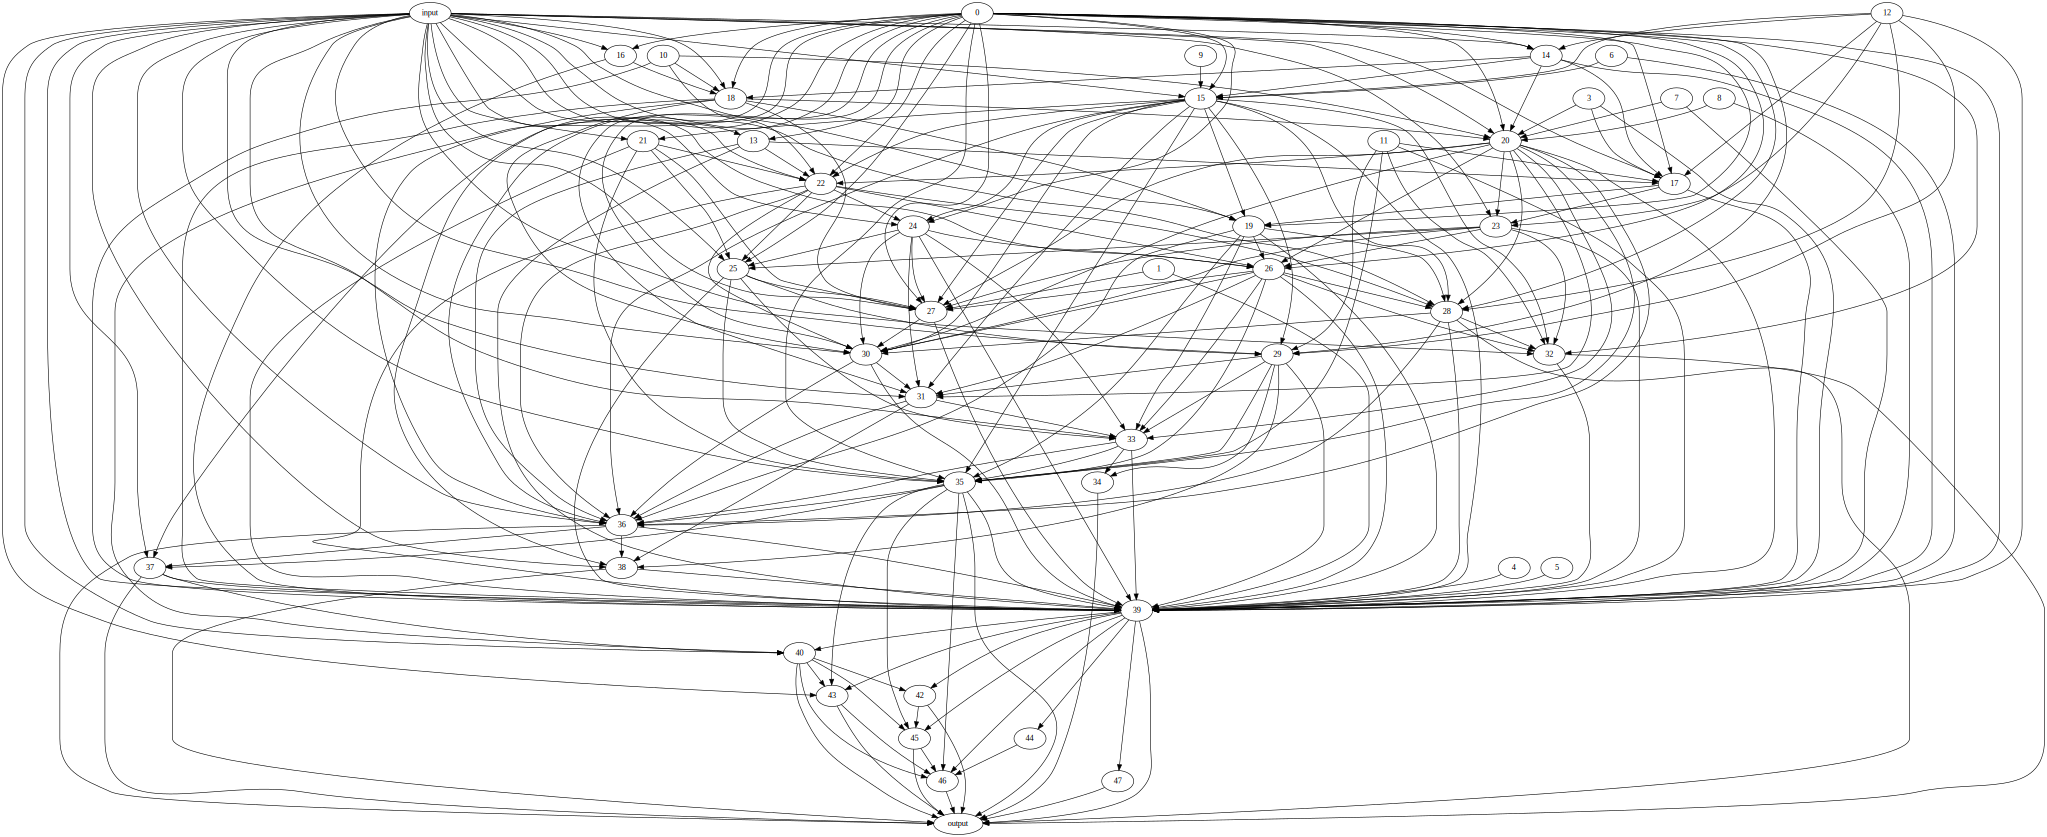

saved to checkpoint ut2w30i2/checkpoint 19.pkl
patching 967 edges, keeping 234 edges, 24 remain
patching 967 edges, keeping 234 edges, 24 remain
baseline score 0.8533886671066284
[1, 1, 1] sized edge sets remaining
got scores tensor([0.8489], device='cuda:0')
keeping edge edge  input -> 12 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.12.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8489415049552917 which has diff 0.00444716215133667 > 0.0001
patching 967 edges, keeping 235 edges, 23 remain
baseline score 0.8533886671066284
[1, 1] sized edge sets remaining
got scores tensor([0.8475], device='cuda:0')
keeping edge edge  0 -> 12 (('blocks.0.hook_out_proj', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.12.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8475301861763 which has diff 0.005858480930328369 > 0.0001
patching 967 edges, keeping 236 edges, 22 remain
baseline score 0.8533886

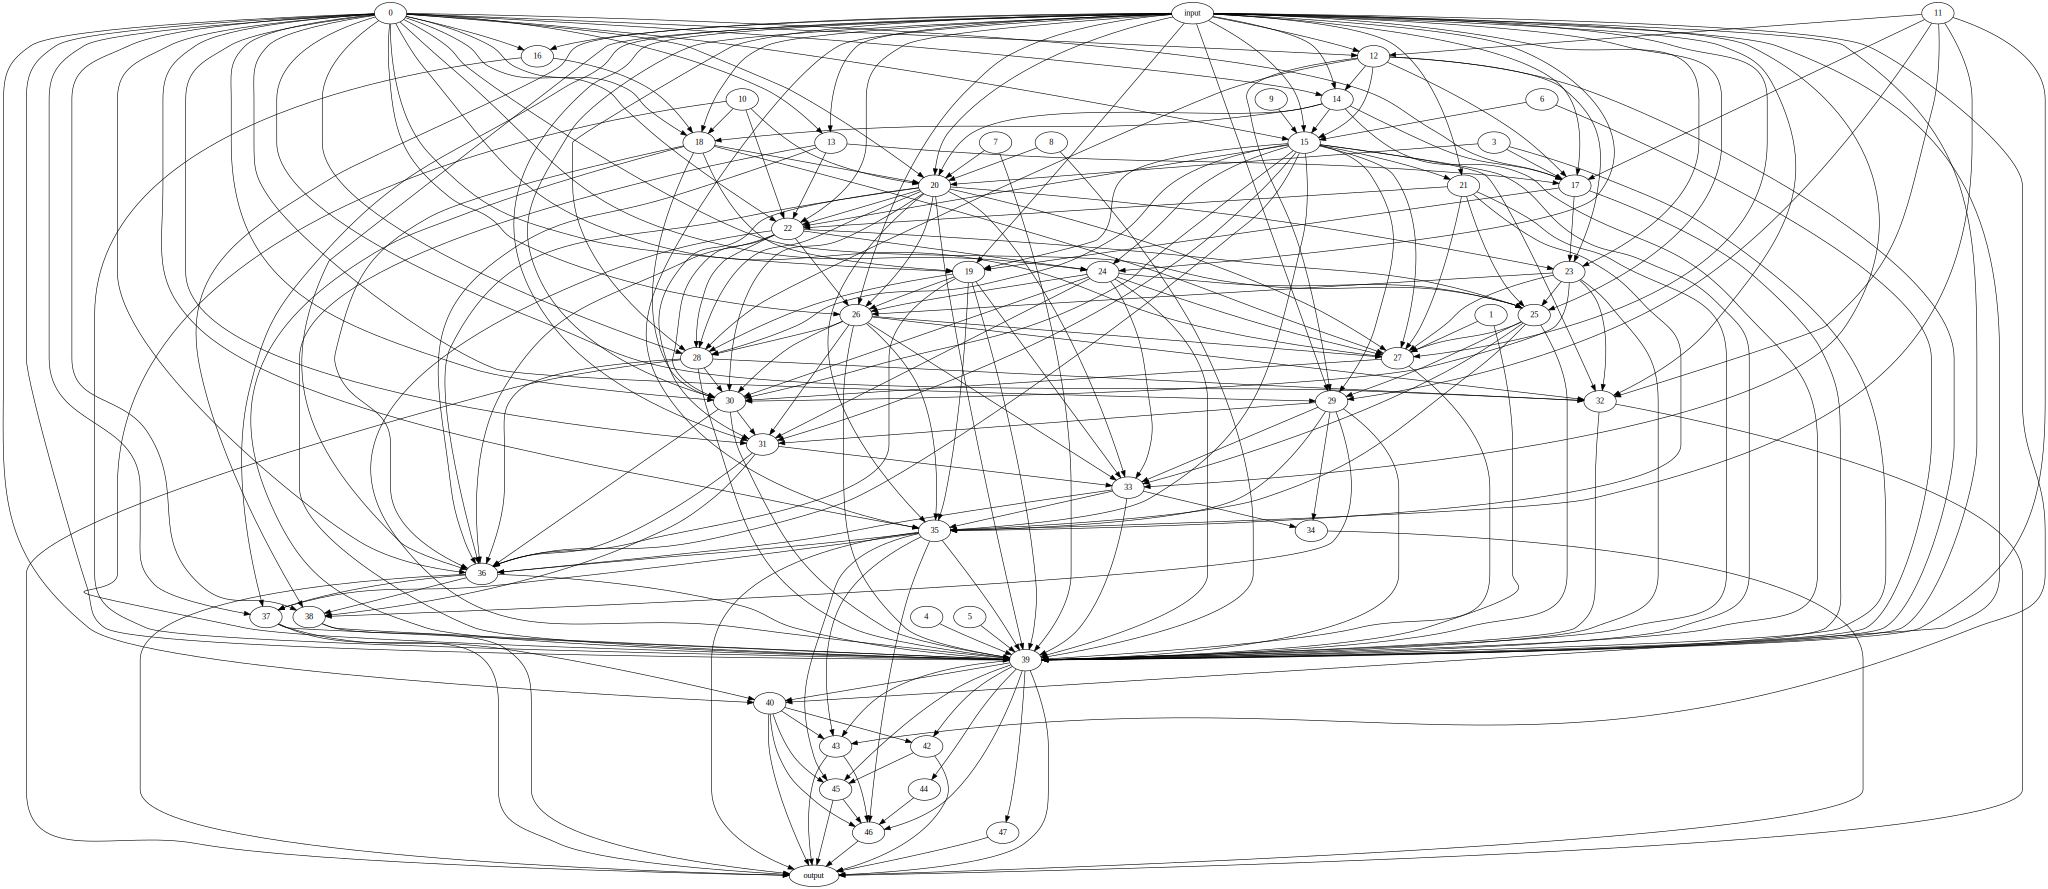

saved to checkpoint ut2w30i2/checkpoint 20.pkl
patching 967 edges, keeping 237 edges, 21 remain
patching 967 edges, keeping 237 edges, 21 remain
baseline score 0.8533886671066284
[1, 1, 1, 1] sized edge sets remaining
got scores tensor([0.8467], device='cuda:0')
keeping edge edge  input -> 11 (('hook_embed', <function storage_hook at 0x7f8b798d6440>) -> ('blocks.11.hook_layer_input', <function resid_patching_hook at 0x7f9686f884c0>))) with score 0.8467483520507812 which has diff 0.006640315055847168 > 0.0001
patching 967 edges, keeping 238 edges, 20 remain
interrupted
all nodes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '5', '6', '7', '8', '9', 'input', 'output']
patching 967 edges, keeping 0 edges, 258 remain
patching 967 edges, keeping 0 edges, 258 remain
baseline score 0.853

InterruptedException: 

In [53]:


job_name_text = "IOI attr patcfhing phase 3.txt"

if os.path.exists(job_name_text):
    with open(job_name_text, "r") as f:
        wandb_id = f.read().strip()
    print(f"resuming from {wandb_id}")
    resume = True
else:
    wandb_id = wandb.util.generate_id()
    with open(job_name_text, "w") as f:
        f.write(wandb_id)
    print(f"starting new run {wandb_id}")
    resume = False
    
wandb_resume = None
if resume:
    try:
        most_recent_checkpoint_path, is_done = get_most_recent_checkpoint(checkpoint_dir=cfg.ckpt_directory)
        if is_done:
            print(f"run {cfg.ckpt_directory} is completed")
        else:
            print(f"resuming from checkpoint {most_recent_checkpoint_path}")
            old_cfg, edges = load_checkpoint(path=most_recent_checkpoint_path)
            cfg.iter = old_cfg.iter
            wandb_resume = 'must'
    except FileNotFoundError:
        print(f"no checkpoints available at {cfg.ckpt_directory}, starting from scratch")

cfg.ckpt_directory = wandb_id
cfg.iter = 0
class InterruptedException(Exception):
    pass

def interrupt_callback(sig_num: Any, stack_frame: Any):
    raise InterruptedException()
import signal
try:
    wandb.finish()
    wandb.init(
        project="mamba-acdc",
        config=cfg,
        name=job_name_text.replace(".txt", "") + f' thresh={cfg.thresh} rollback_thresh={cfg.rollback_thresh}',
        resume=wandb_resume,
        id=wandb_id,
    )
    # signal handlers (if preempted)
    signal.signal(signal.SIGINT, interrupt_callback)
    signal.signal(signal.SIGTERM, interrupt_callback)
    result_edges = run_acdc(model=model, data=data, cfg=cfg, edges=edges)
except (KeyboardInterrupt, InterruptedException):
    print("interrupted")

# reset them for another run
for edge in result_edges_2:
    if edge.checked and not edge.patching:
        edge.checked = False


#cfg.thresh = 0.00001,
#cfg.rollback_thresh = 0.00001,
cfg.thresh = 0.0001
cfg.rollback_thresh = 0.0001
result_edges_3 = run_acdc(model=model, data=data, cfg=cfg, edges=result_edges_2)
wandb.finish()